# General Backtester for Fees/Returns/IL on Vanilla LP 
On:
- Any Uni V3 Pool
- Any Time Period
- Any Range Factor
- Includes Subsample Testing

See associated #ResearchBite: https://twitter.com/Panoptic_xyz/status/1621252130815483904?s=20&t=iBDi7DAgEQFNQ_G24dYpwA

### Import Python Packages

In [1]:
import pandas as pd
import pandas_gbq
import pydata_google_auth
import numpy as np
import requests
import matplotlib.pyplot as plt
import math

from tqdm import tqdm
from io import StringIO
from datetime import datetime
pd.options.mode.chained_assignment = None

### Parse Data

In [2]:
class LP_Rebalance:
    def __init__(
        self,
        token_0: str,
        token_1: str,
        fee: int, # in bps
        local_dir: str,
        start_t: str,
        end_t: str,
        range_perc: float, # i.e. +/- 30%
        pool_data: pd.DataFrame=None,
        inverse_price: bool=True,
    ) -> None:
        """
        Initialize LP Rebalancing class
        
        :token_0 Token 0
        :token_1 Token 1
        :fee fee rate in bps
        :local_dir local directory to save plots
        :start_t start time (inclusive) (i.e. '2021-05-06 00:06:12' or '2021-05-06')
        :end_t end time (exclusive)
        :range_perc range percent (for +/- 30%, input 30)
        :inverse_price invert the price (if true: gets price of token_1 in terms of token_0)
        """
        self.token_0 = token_0
        self.token_1 = token_1
        self.fee_rate = fee / 10_000
        self.pool_address = LP_Rebalance.get_pool_address(self.token_0, self.token_1, fee)
        self.dec_0 = LP_Rebalance.get_token_dec(self.token_0)
        self.dec_1 = LP_Rebalance.get_token_dec(self.token_1)
        self.tick_spacing = LP_Rebalance.get_tick_spacing(fee)
        ''' Our_capital is 1 b/c it allows results to be interpreted as percentages
        Strategy does accounting in numeraire token
        I.e. start with 1 token of numeraire, split 50/50 to LP.
        At end of rebalancing period (e.g. 1 day), we sell everything back into the numeraire token
        And calculate the % change (return) on the numeraire token '''
        self.our_capital = 1 # in token y
        self.raw_dir = local_dir
        self.start_t = start_t
        self.end_t = end_t
        self.range_perc = (range_perc / 100) + 1
        self.tick_width = LP_Rebalance.convert_r_to_tick_width(self.range_perc)
        ''' If inverse_price, our numeraire is token_0
        Else, our numeraire is token_1
        Ex: For USDC/ETH pool:
        token 0 = USDC
        token 1 = ETH
        Inverse_price = True -> we calculate returns in terms of USDC
        Inverse_price = False -> we calculate returns in terms of ETH
        This will affect results! '''
        self.inverse_price = inverse_price
        self.BASE = 1.0001

        if pool_data is None:
            self.load_pool_data()
        else:
            self.data = pool_data
        

    def load_pool_data(self):
        """Loads Univ3 pool swap data"""
        # Replace this function with your own GBQ data fetcher
        # See: https://github.com/panoptic-labs/research/blob/JP/_research-bites/DataTutorial/tutorial.ipynb
        print("Loading Data...")

        SCOPES = [
            'https://www.googleapis.com/auth/cloud-platform',
            'https://www.googleapis.com/auth/drive',
        ]

        credentials = pydata_google_auth.get_user_credentials(
            SCOPES,
            auth_local_webserver=True,
        )

        query = f"""
        SELECT DISTINCT *
        FROM `arcane-world-371019.First_sync.1`
        WHERE address = '{self.pool_address}'
            AND block_timestamp >= '{self.start_t}'
            AND block_timestamp < '{self.end_t}'
        ORDER BY block_number, transaction_index
        """
        self.data = pandas_gbq.read_gbq(query, project_id = "arcane-world-371019", credentials=credentials)
        self.transform_pool_data()

    def transform_pool_data(self):
        """Transform amounts to human-readable format"""
        self.data['amount0'] = self.data['amount0'].apply(LP_Rebalance.get_twos_comp)
        self.data['amount1'] = self.data['amount1'].apply(LP_Rebalance.get_twos_comp)

        self.data['amount0'] = self.data['amount0'] / (10 ** self.dec_0)
        self.data['amount1'] = self.data['amount1'] / (10 ** self.dec_1)

        self.data['price'] = self.data['tick'].apply(self.convert_tick)

        # Note our GBQ query ordered by blocknumber, transaciton_index
        self.data.set_index('block_timestamp', inplace=True) # Assume block timestamps are accurate "enough" for our use-case
        self.data.index = pd.to_datetime(self.data.index)

        # Unpack sqrt price
        self.data['sqrtPrice'] = self.data['sqrtPrice'].apply(LP_Rebalance.unpack_sqrtprice)

        # Calculate sqrt price change
        self.data = LP_Rebalance.calc_sqrtprice_change(self.data)

    def run_strat(self):
        print("Running Strategy")
        self.create_strat()

        # Calculate liquidity per tick
        tqdm().pandas(desc='Step 1')
        self.daily['liq_per_tick'] = self.daily.progress_apply(self.calc_liq_per_tick, axis=1)
        self.weekly['liq_per_tick'] = self.weekly.progress_apply(self.calc_liq_per_tick, axis=1)
        self.monthly['liq_per_tick'] = self.monthly.progress_apply(self.calc_liq_per_tick, axis=1)

        # Calculate fees
        tqdm().pandas(desc='Step 2')
        self.daily[['our_fee', 'fee_asset']] = self.daily.progress_apply(self.calc_fees, axis=1)
        self.weekly[['our_fee', 'fee_asset']] = self.weekly.progress_apply(self.calc_fees, axis=1)
        self.monthly[['our_fee', 'fee_asset']] = self.monthly.progress_apply(self.calc_fees, axis=1)

        # Calculate daily fee returns to strategy
        self.daily_fees = self.get_fees(self.daily)
        self.weekly_fees = self.get_fees(self.weekly)
        self.monthly_fees = self.get_fees(self.monthly)

        # Calculate PnL
        tqdm().pandas(desc='Step 3')
        self.daily_pos = self.daily.groupby('date').progress_apply(self.calc_position)
        self.weekly_pos = self.weekly.groupby('date').progress_apply(self.calc_position)
        self.monthly_pos = self.monthly.groupby('date').progress_apply(self.calc_position)

    def create_strat(self):
        """
        Define Rebalancing Strategies
        Define 3 strategies: LP +/- X% of start price and rebalance (1) daily, (2) weekly, and (3) monthly
        -Assumes no rebalancing costs in terms of gas fees or slippage/swap fees
        -Assumes no reinvestment/LPing of collected fees
        """
        daily = self.data.copy()
        weekly = self.data.copy()
        monthly = self.data.copy()

        # Rather than lagging prices, we simply take the first available price of the day
        # (The data isn't uniform across time so we assume the first available price will
        # be close to the price at 00:00:00)
        daily['date'] = daily.index.date
        daily['price_start'] = daily.groupby('date')['price'].transform(lambda x: x[0])
        daily['tick_start'] = daily.groupby('date')['tick'].transform(lambda x: x[0])
        daily['sqrtPrice_start'] = daily.groupby('date')['sqrtPrice'].transform(lambda x: x[0])
        daily['price_a'] = daily['price_start'] / self.range_perc
        daily['price_b'] = daily['price_start'] * self.range_perc
        self.daily = daily

        # Rebalance every Monday (UTC)
        weekly['date'] = weekly.index.date
        weekly['price_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['price'].transform(lambda x: x[0])
        weekly['tick_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['tick'].transform(lambda x: x[0])
        weekly['sqrtPrice_start'] = weekly.groupby([pd.Grouper(level = 'block_timestamp', freq = 'W-MON', closed='left')])['sqrtPrice'].transform(lambda x: x[0])
        weekly['price_a'] = weekly['price_start'] / self.range_perc
        weekly['price_b'] = weekly['price_start'] * self.range_perc
        self.weekly = weekly

        # Rebalance on the 1st of the month
        monthly['date'] = monthly.index.date
        monthly['month'] = monthly.index.month
        monthly['year'] = monthly.index.year
        monthly['price_start'] = monthly.groupby(['year', 'month'])['price'].transform(lambda x: x[0])
        monthly['tick_start'] = monthly.groupby(['year', 'month'])['tick'].transform(lambda x: x[0])
        monthly['sqrtPrice_start'] = monthly.groupby(['year', 'month'])['sqrtPrice'].transform(lambda x: x[0])
        monthly['price_a'] = monthly['price_start'] / self.range_perc
        monthly['price_b'] = monthly['price_start'] * self.range_perc
        self.monthly = monthly

    def calc_fees(self, s: pd.Series) -> pd.Series:
        """Calculate fee collected by us per swap
        (Uses sqrtPrice and liq_per_tick)"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        # Our fees
        low_bound = np.sqrt(self.BASE ** (s['tick_start'] - self.tick_width))
        up_bound = np.sqrt(self.BASE ** (s['tick_start'] + self.tick_width))
        prev_adj = np.clip(s['prev_sqrtPrice'], low_bound, up_bound)
        curr_adj = np.clip(s['sqrtPrice'], low_bound, up_bound)

        if s['change_sqrtPrice'] >= 0: # price of token 0 in token 1 went up -> fee collected in token 1
            fee_asset = self.token_1
            our_fee = s['liq_per_tick'] * (curr_adj - prev_adj) * self.fee_rate
        
        else: # price of token 0 in token 1 went down -> fee collected in token 0
            fee_asset = self.token_0
            our_fee = s['liq_per_tick'] * ((1 / curr_adj) - (1 / prev_adj)) * self.fee_rate

        return pd.Series([our_fee, fee_asset])

    def get_fee_summary(self, df: pd.DataFrame) -> pd.Series:
        """Get daily summary statistics of our collected fees"""
        # We ignore decimals for sqrtPrice - they end up cancelling out in calc_liq_per_tick(), calc_fees(), and get_fee_summary()
        price_close = df['price'][-1]
        sqrtPrice_close = df['sqrtPrice'][-1]

        # Our performance
        our_fees_0 = df.loc[df['fee_asset'] == self.token_0, 'our_fee'].sum()
        our_fees_1 = df.loc[df['fee_asset'] == self.token_1, 'our_fee'].sum()

        our_fees = our_fees_1 + our_fees_0 * (sqrtPrice_close ** 2) # in terms of token 1 (with dec_1)

        if self.inverse_price:
            our_fees *= price_close # in terms of token 0

        return pd.Series([
                        price_close,
                        our_fees
                        ])

    def get_fees(self, df: pd.DataFrame) -> pd.DataFrame:
        """Gets daily collected fees"""
        rets = pd.DataFrame(index=df['date'].unique())

        rets[[
            'price_close',
            'our_fees']] = df.groupby('date').apply(self.get_fee_summary)
        return rets

    def calc_position(self, df: pd.DataFrame) -> pd.Series:
        """
        Calculates strategy position in token y, the numeraire
        (if inverse_price then this is token_0, else token_1)
        and daily returns (excluding fees).
        Expects df to be LP data from *one* day of swaps.

        p_a: lower price range
        p_b: upper price range
        p_0: mid-price (initial price)
        x_0: initial amount of token x
        y_0: initial amount of token y

        p_1: price at beginning of day (same as p_0
            for daily rebalancing but different for
            weekly and monthly rebalancing)
        x_1: amount of token x at BOD
        y_1: amount of token y at BOD

        p: current (close) price at EOD
        x: current amount of token x
        y: current amount of token y
        IL: impermanent loss (loss compared to HODLing)

        """
        # Initial LP price range and positions
        p_a = df['price_a'][-1]
        p_b = df['price_b'][-1]
        p_0 = df['price_start'][-1]
        x_0 = (self.our_capital / p_0) / 2 # Start with 1 unit of token y. Split between x and y
        y_0 = self.our_capital / 2 # In the case of USDC this is just $0.50

        # Beginning of day position due to IL
        # (differs from initial positions for weekly and monthly rebalancing)
        p_1 = df['price'][0]
        p_1_adj = np.clip(p_1, p_a, p_b) # ensures price used for calculating token amts d/n exceed price range
        # https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf
        L_x = x_0 * ((np.sqrt(p_0) * np.sqrt(p_b)) / (np.sqrt(p_b) - np.sqrt(p_0)))
        L_y = y_0 / (np.sqrt(p_0) - np.sqrt(p_a))
        L = min(L_x, L_y)

        x_1 = L * (np.sqrt(p_b) - np.sqrt(p_1_adj)) / (np.sqrt(p_1_adj) * np.sqrt(p_b))
        y_1 = L * (np.sqrt(p_1_adj) - np.sqrt(p_a))
        pos_1 = x_1 * p_1 + y_1 # in token y

        # End of day position due to IL
        p = df['price'][-1] # close (current) price
        p_adj = np.clip(p, p_a, p_b) # ensures price used for calculating token amts d/n exceed price range
        x = L * (np.sqrt(p_b) - np.sqrt(p_adj)) / (np.sqrt(p_adj) * np.sqrt(p_b))
        y = L * (np.sqrt(p_adj) - np.sqrt(p_a))
        pos = x * p + y # in token y
        pnl = pos - pos_1 # in token y
        pos_hodl = x_1 * p + y_1 # in token y
        pnl_hodl = pos_hodl - pos_1 # in token y
        IL = pos - pos_hodl

        pnl_perc = pnl / pos_1 
        IL_perc = IL / pos_1
        
        return pd.Series({
            'x_0': x_0,
            'y_0': y_0,
            'x_bod': x_1,
            'y_bod': y_1,
            'pos_bod': pos_1,
            'x': x,
            'y': y,
            'pos': pos,
            'pnl': pnl,
            'pos_hodl': pos_hodl,
            'pnl_hodl': pnl_hodl,
            'IL': IL,
            'pnl_perc': pnl_perc,
            'IL_perc': IL_perc
        })

    def convert_price(self, p: float) -> float:
        """Gets (inverse) price (convenient for pairs like USDC/ETH)
        Inverse price: price of token1 in terms of token0
        Regular price: price of token0 in terms of token1"""
        if self.inverse_price:
            return 10 ** (self.dec_1 - self.dec_0) / p
        else:
            return p / (10 ** (self.dec_1 - self.dec_0))

    def convert_tick(self, tick: int) -> float:
        """Converts tick to price"""
        return self.convert_price(self.BASE ** tick)

    def convert_price_to_tick(self, p: float) -> float:
        """Converts price to tick"""    
        return math.log(self.convert_price(p), self.BASE)

    def calc_liq_per_tick(self, s: pd.Series) -> float:
        """
        Calculates our liquidity per tick
        (see https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf)
        """
        ''' Do not invert prices for calculating liquidity per tick
        (This is an input to self.calc_fees() which uses sqrtPrice and assumes no inverted price)
        Note that sqrtPrice should be multiplied by 10 ^ [(dec0 - dec1) / 2]
        (or alternative multiply sqrtPrice ^2 by 10 ^ (dec0 - dec1))
        to achieve correct decimal places
        But we ignore decimals here, as they end up cancelling out in anyway in calc_liq_per_tick(), calc_fees(), and get_fee_summary() '''
        price = s['sqrtPrice_start'] ** 2
        p_a = price / self.range_perc

        p_0 = s['price_start']
        if self.inverse_price:
            y_0 = (self.our_capital / p_0) / 2
        else:
            y_0 = self.our_capital / 2 # In the case of USDC this is just $0.50

        # # Initial liquidity per tick
        L = y_0 / (np.sqrt(price) - np.sqrt(p_a))
        return L

    @staticmethod
    def convert_r_to_tick_width(r: float) -> float:
        """Converts range factor to tick width
        
        :r range factor
        """
        return math.log(r, 1.0001)

    @staticmethod
    def calc_sqrtprice_change(df: pd.DataFrame) -> pd.DataFrame:
        """Stores previous sqrt price and calculates delta"""
        df['prev_sqrtPrice'] = df['sqrtPrice'].shift()
        df['change_sqrtPrice'] = df['sqrtPrice'] - df['prev_sqrtPrice']
        return df

    @staticmethod
    def unpack_sqrtprice(sqrt_p: str) -> float:
        """Unpacks sqrt price from raw UNI V3 pool data"""
        return int(sqrt_p, 16) / (2 ** 96)

    @staticmethod
    def get_twos_comp(hex_str: str, bits: int=256) -> float:
        """Calculate two's complement"""
        num = int(hex_str, 16)
        if (num & (1 << (bits - 1))) != 0: # Check if first bit is set
            num = num - (1 << bits)        # Get two's complement
        return num

    @staticmethod
    def get_pool_address(token_0: str, token_1: str, fee: int) -> str:
        """Gets Univ3 Pool Address"""
        # Source: https://info.uniswap.org/#/pools
        # Feel free to add additional pools
        # (make sure token0 and token1 are specified in the same order as on Uniswap!)
        # Ex: '[token0]/[token1] [fee]bps': '[pool_address]',
        pools = {
            '1INCH/ETH 100bps': '0xe931b03260b2854e77e8da8378a1bc017b13cb97',
            'AAVE/ETH 30bps': '0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb',
            'APE/ETH 30bps': '0xac4b3dacb91461209ae9d41ec517c2b9cb1b7daf',
            'BIT/ETH 30bps': '0x5c128d25a21f681e678cb050e551a895c9309945',
            'BUSD/USDC 5bps': '0x00cef0386ed94d738c8f8a74e8bfd0376926d24c',
            'cbETH/ETH 5bps': '0x840deeef2f115cf50da625f7368c24af6fe74410',
            'DAI/ETH 5bps': '0x60594a405d53811d3bc4766596efd80fd545a270',
            'DAI/ETH 30bps': '0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8',
            'DAI/USDC 1bps': '0x5777d92f208679db4b9778590fa3cab3ac9e2168',
            'DAI/USDC 5bps': '0x6c6bc977e13df9b0de53b251522280bb72383700',
            'DAI/FRAX 5bps': '0x97e7d56a0408570ba1a7852de36350f7713906ec',
            'ETH/BTT 30bps': '0x64a078926ad9f9e88016c199017aea196e3899e1',
            'ETH/ENS 30bps': '0x92560c178ce069cc014138ed3c2f5221ba71f58a',
            'ETH/LOOKS 30bps': '0x4b5ab61593a2401b1075b90c04cbcdd3f87ce011',
            'ETH/sETH2 30bps': '0x7379e81228514a1d2a6cf7559203998e20598346',
            'ETH/USDT 5bps': '0x11b815efb8f581194ae79006d24e0d814b7697f6',
            'ETH/USDT 30bps': '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36',
            'FRAX/USDC 5bps': '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52',
            'GNO/ETH 30bps': '0xf56d08221b5942c428acc5de8f78489a97fc5599',
            'HEX/USDC 30bps': '0x69d91b94f0aaf8e8a2586909fa77a5c2c89818d5',
            'LDO/ETH 30bps': '0xa3f558aebaecaf0e11ca4b2199cc5ed341edfd74',
            'LINK/ETH 30bps': '0xa6cc3c2531fdaa6ae1a3ca84c2855806728693e8',
            'MATIC/ETH 30bps': '0x290a6a7460b308ee3f19023d2d00de604bcf5b42',
            'MKR/ETH 30bps': '0xe8c6c9227491c0a8156a0106a0204d881bb7e531',
            'SHIB/ETH 30bps': '0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec',
            'UNI/ETH 30bps': '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801',
            'USDC/ETH 1bps': '0xe0554a476a092703abdb3ef35c80e0d76d32939f',
            'USDC/ETH 5bps': '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640',
            'USDC/ETH 30bps': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8',
            'USDC/ETH 100bps': '0x7bea39867e4169dbe237d55c8242a8f2fcdcc387',
            'USDC/USDT 1bps': '0x3416cf6c708da44db2624d63ea0aaef7113527c6',
            'USDC/USDT 5bps': '0x7858e59e0c01ea06df3af3d20ac7b0003275d4bf',
            'USDC/USDM 5bps': '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc',
            'WBTC/ETH 5bps': '0x4585fe77225b41b697c938b018e2ac67ac5a20c0',    
            'WBTC/ETH 30bps': '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed',
            'WBTC/USDC 30bps': '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35',
            'WOOF/ETH 100bps': '0x666ed8c2151f00e7e58b4d941f65a9df68d2245b',
        }

        pool_name = f"{token_0}/{token_1} {str(fee)}bps"
        try:
            pool_address = pools[pool_name]
        except KeyError:
            return None
        return pool_address

    @staticmethod
    def get_token_dec(token: str) -> int:
        """Gets number of decimals corresponding to token"""
        # Source: https://apiv5.paraswap.io/tokens/?network=1 & https://etherscan.io/tokens
        decimals = {
            '1INCH': 18,
            'AAVE': 18,
            'APE': 18,
            'BIT': 18,
            'BTT': 18,
            'BUSD': 18,
            'cbETH': 18,
            'DAI': 18,
            'ENS': 18,
            'ETH': 18,
            'FRAX': 18,
            'GNO': 18,
            'HEX': 8,
            'LDO': 18,
            'LINK': 18,
            'LOOKS': 18,
            'MATIC': 18,
            'MKR': 18,
            'sETH2': 18,
            'SHIB': 18,
            'UNI': 18,
            'USDC': 6,
            'USDM': 18,
            'USDT': 6,
            'WBTC': 8,
            'WOOF': 18,
        }
        try:
            dec = decimals[token]
        except KeyError:
            return None
        return dec

    @staticmethod
    def get_tick_spacing(fee: int) -> int:
        """
        Gets Univ3 tick spacing corresponding to fee-tier

        :fee fee-tier in bps
        """
        spacing = {
            1: 1,
            5: 10,
            30: 60,
            100: 200
        }
        try:
            space = spacing[fee]
        except KeyError:
            return None
        return spacing[fee]

In [4]:
# Create as many strategies as you want!
local_dir = "[YOUR_OUTPUT_DIRECTORY_HERE/]" # notebook will save a bazillion (ok...<100) graphs/spreadsheets under this directory so be careful!
# Alternatively you can comment out code for plots you don't care about
# Or comment out plt.savefig(dir)!

# Use Panoptic stylesheet. See - https://github.com/panoptic-labs/research/blob/main/stylesheet/panoptic-dark-2_1.mplstyle
plt.style.use('[YOUR_DIRECTORY_HERE/]stylesheet/panoptic-dark-2_1.mplstyle')

strat_1 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2021-06-01',
            end_t = '2023-01-30',
            range_perc = 5, # r = 1.05
            pool_data = None,
            inverse_price = True
)

strat_2 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2021-06-01',
            end_t = '2023-01-30',
            range_perc = 20, # r = 1.2
            pool_data = strat_1.data.copy(deep=True),
            inverse_price = True
)

strat_3 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2021-06-01',
            end_t = '2023-01-30',
            range_perc = 50, # r = 1.5
            pool_data = strat_1.data.copy(deep=True),
            inverse_price = True
)

strat_4 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2021-06-01',
            end_t = '2023-01-30',           
            range_perc = 75, # r = 1.75
            pool_data = strat_1.data.copy(deep=True),
            inverse_price = True
)

strat_5 = LP_Rebalance(
            token_0 = 'USDC',
            token_1 = 'ETH',
            fee = 30,
            local_dir = local_dir,
            start_t = '2021-06-01',
            end_t = '2023-01-30',           
            range_perc = 99_900, # equivalent to r = 1,000
            pool_data = strat_1.data.copy(deep=True),
            inverse_price = True
)

'''
Choose strategy rebalancing periods that you want to plot.
You can update these later without having to re-run the strategies.

'a' = all (daily, weekly, and monthly)
'd' = daily
'w' = weekly
'm' = monthly
'''
strategies = {strat_1: ('d'),
              strat_2: ('d'),
              strat_3: ('d'),
              strat_4: ('d'),
              strat_5: ('d'),
             }

[x.run_strat() for x in strategies]

Loading Data...
Downloading: 100%|██████████|
Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 348949/348949 [00:06<00:00, 52182.09it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 348949/348949 [00:53<00:00, 6462.03it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 608/608 [00:00<00:00, 2344.92it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 348949/348949 [00:07<00:00, 47615.31it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 348949/348949 [01:00<00:00, 5782.20it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 608/608 [00:00<00:00, 2048.07it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 348949/348949 [00:06<00:00, 58108.85it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 348949/348949 [01:06<00:00, 5236.62it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 608/608 [00:00<00:00, 1816.50it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 348949/348949 [00:06<00:00, 50693.89it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 348949/348949 [01:01<00:00, 5698.97it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 608/608 [00:00<00:00, 2386.30it/s]


Running Strategy


0it [00:00, ?it/s]
Step 1: 100%|██████████| 348949/348949 [00:05<00:00, 62695.37it/s]
0it [00:00, ?it/s]
Step 2: 100%|██████████| 348949/348949 [01:03<00:00, 5496.56it/s]
0it [00:00, ?it/s]
Step 3: 100%|██████████| 608/608 [00:00<00:00, 2102.52it/s]


[None, None, None, None, None]

In [5]:
# For weekly/monthly results, update the below values and rerun notebook starting from this cell!

pool_name = 'ETH-USDC 0.3%'
reb_period = 'Daily'

strategies = {strat_1: ('d'),
              strat_2: ('d'),
              strat_3: ('d'),
              strat_4: ('d'),
              strat_5: ('d'),
             }

# Plots

In [7]:
def plot_hist(s: pd.Series, xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to LP each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)
    plt.hist(s, bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)

    plt.axvline(s.median(), color='w', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(0, max_ylim*1.01, f"Median: {round(s.median(), 1)}")

    plt.savefig(dir)

def plot_hist_all(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, bins=100) -> None:
    """
    Plots histogram of data

    :s series of data
    :xlabel x-axis label
    :ylabel y-axis label
    :title title of plot
    :dir local directory to save plot under
    :bins number of bins for histogram

    """
    # Since we assume a starting capital of $1 to LP each day, the fees can be interpreted as raw values AND percent of capital
    plt.figure(dpi=750)

    for name, r in rets.items():
        plt.hist(r, label=name + f', med = {round(r.median(), 1)}', bins=bins)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, pad=20)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)

def plot_cum_rets(rets: dict[str: pd.Series], xlabel: str, ylabel: str, title: str, dir: str, label: bool=False) -> None:
    colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e', '#f8d120','#efefef'] # from stylesheet
    plt.figure(dpi=750)
    for name, r in rets.items():
        cum_rets = ((1 + r).cumprod() - 1) * 100
        plt.plot(cum_rets, label=name)
        if label:
            plt.plot(cum_rets.index[-1], cum_rets[-1], 'o', zorder=4, ms=2.5, mec='#efefef', color=colors[i])
            plt.text(cum_rets.index[-1] + timedelta(days = 3), cum_rets[-1] + 1, f"{round(cum_rets[-1])}%", ha='left', va='center', fontsize=2.5, color=colors[i])

    plt.xticks(rotation=45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(prop={'size': 2})

    plt.savefig(dir)

def strat_name(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for plot title
    
    :strat strategy object
    """
    return f"({strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps, {strat.start_t} - {strat.end_t}, r = {strat.range_perc})"


def strat_file(strat: LP_Rebalance) -> str:
    """
    Creates name for strategy for saving file
    
    :strat strategy object
    """
    return f"{strat.token_0}-{strat.token_1}-{int(strat.fee_rate * 10_000)}bps-{strat.start_t}-{strat.end_t}-r={int((strat.range_perc - 1) * 100)}"


def strat_label(strat: LP_Rebalance, reb_freq: str) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    :reb_freq rebalancing frequency (e.g. "daily", "weekly", or "monthly")
    """
    return f"{strat.token_0}-{strat.token_1} {int(strat.fee_rate * 10_000)} bps (r = {strat.range_perc}, reb = {reb_freq})"

def strat_label_2(strat: LP_Rebalance) -> str:
    """
    Creates label for strategy for plot legend

    :strat strategy object
    """
    return f"r = {strat.range_perc}"

### Fees

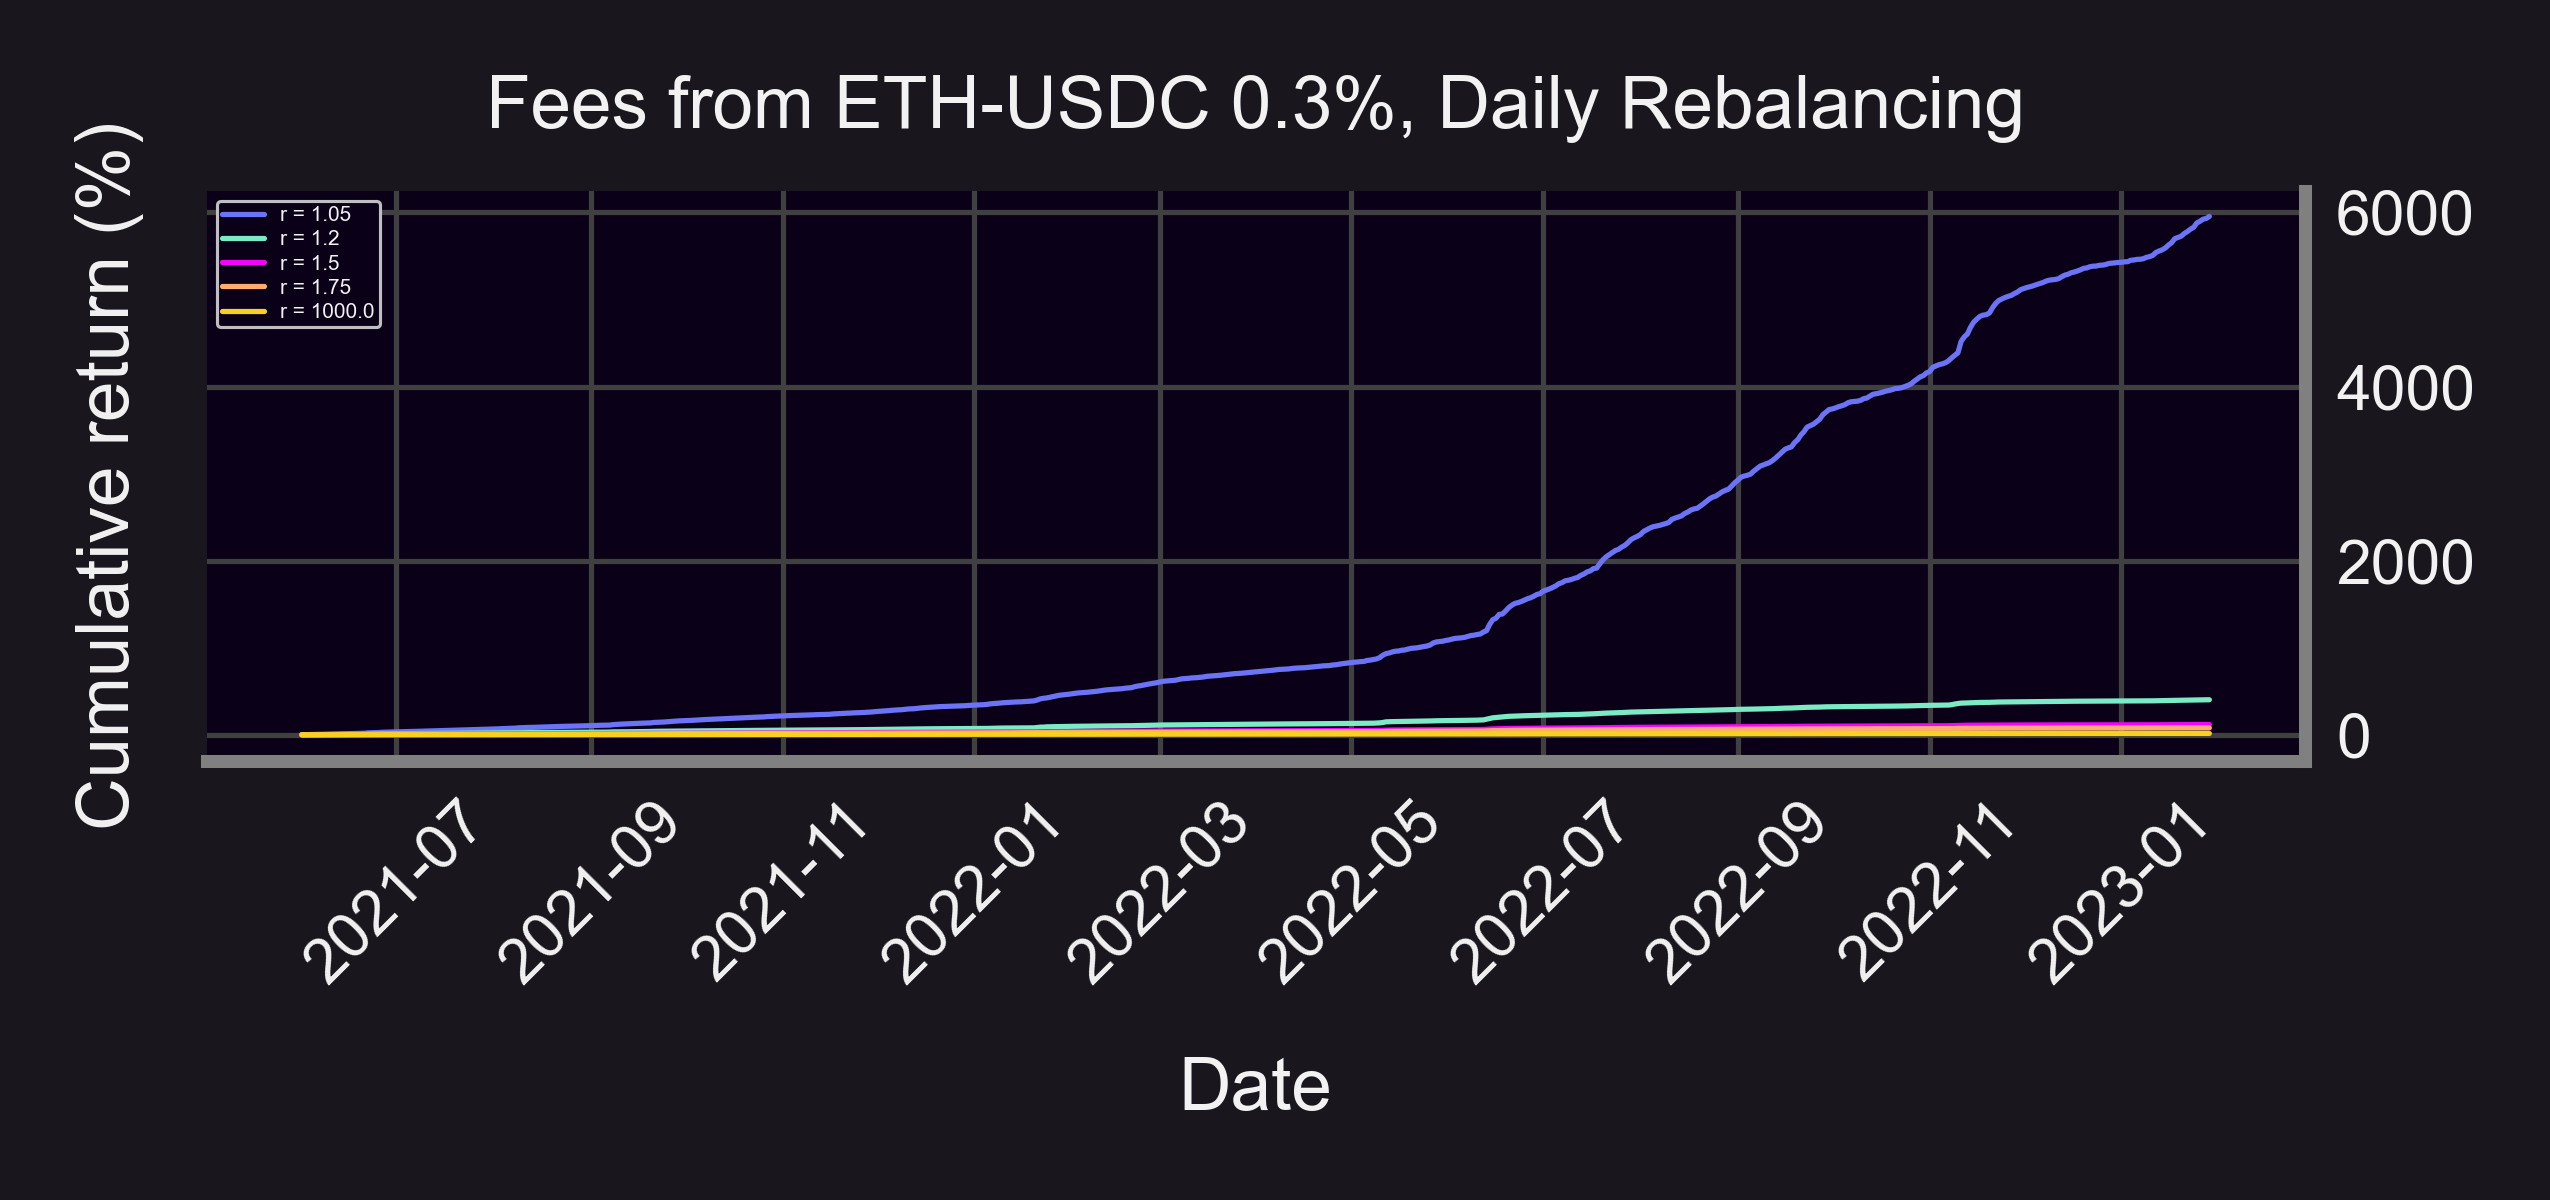

In [8]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees']
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees']
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees']

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_fees_FULL"
)

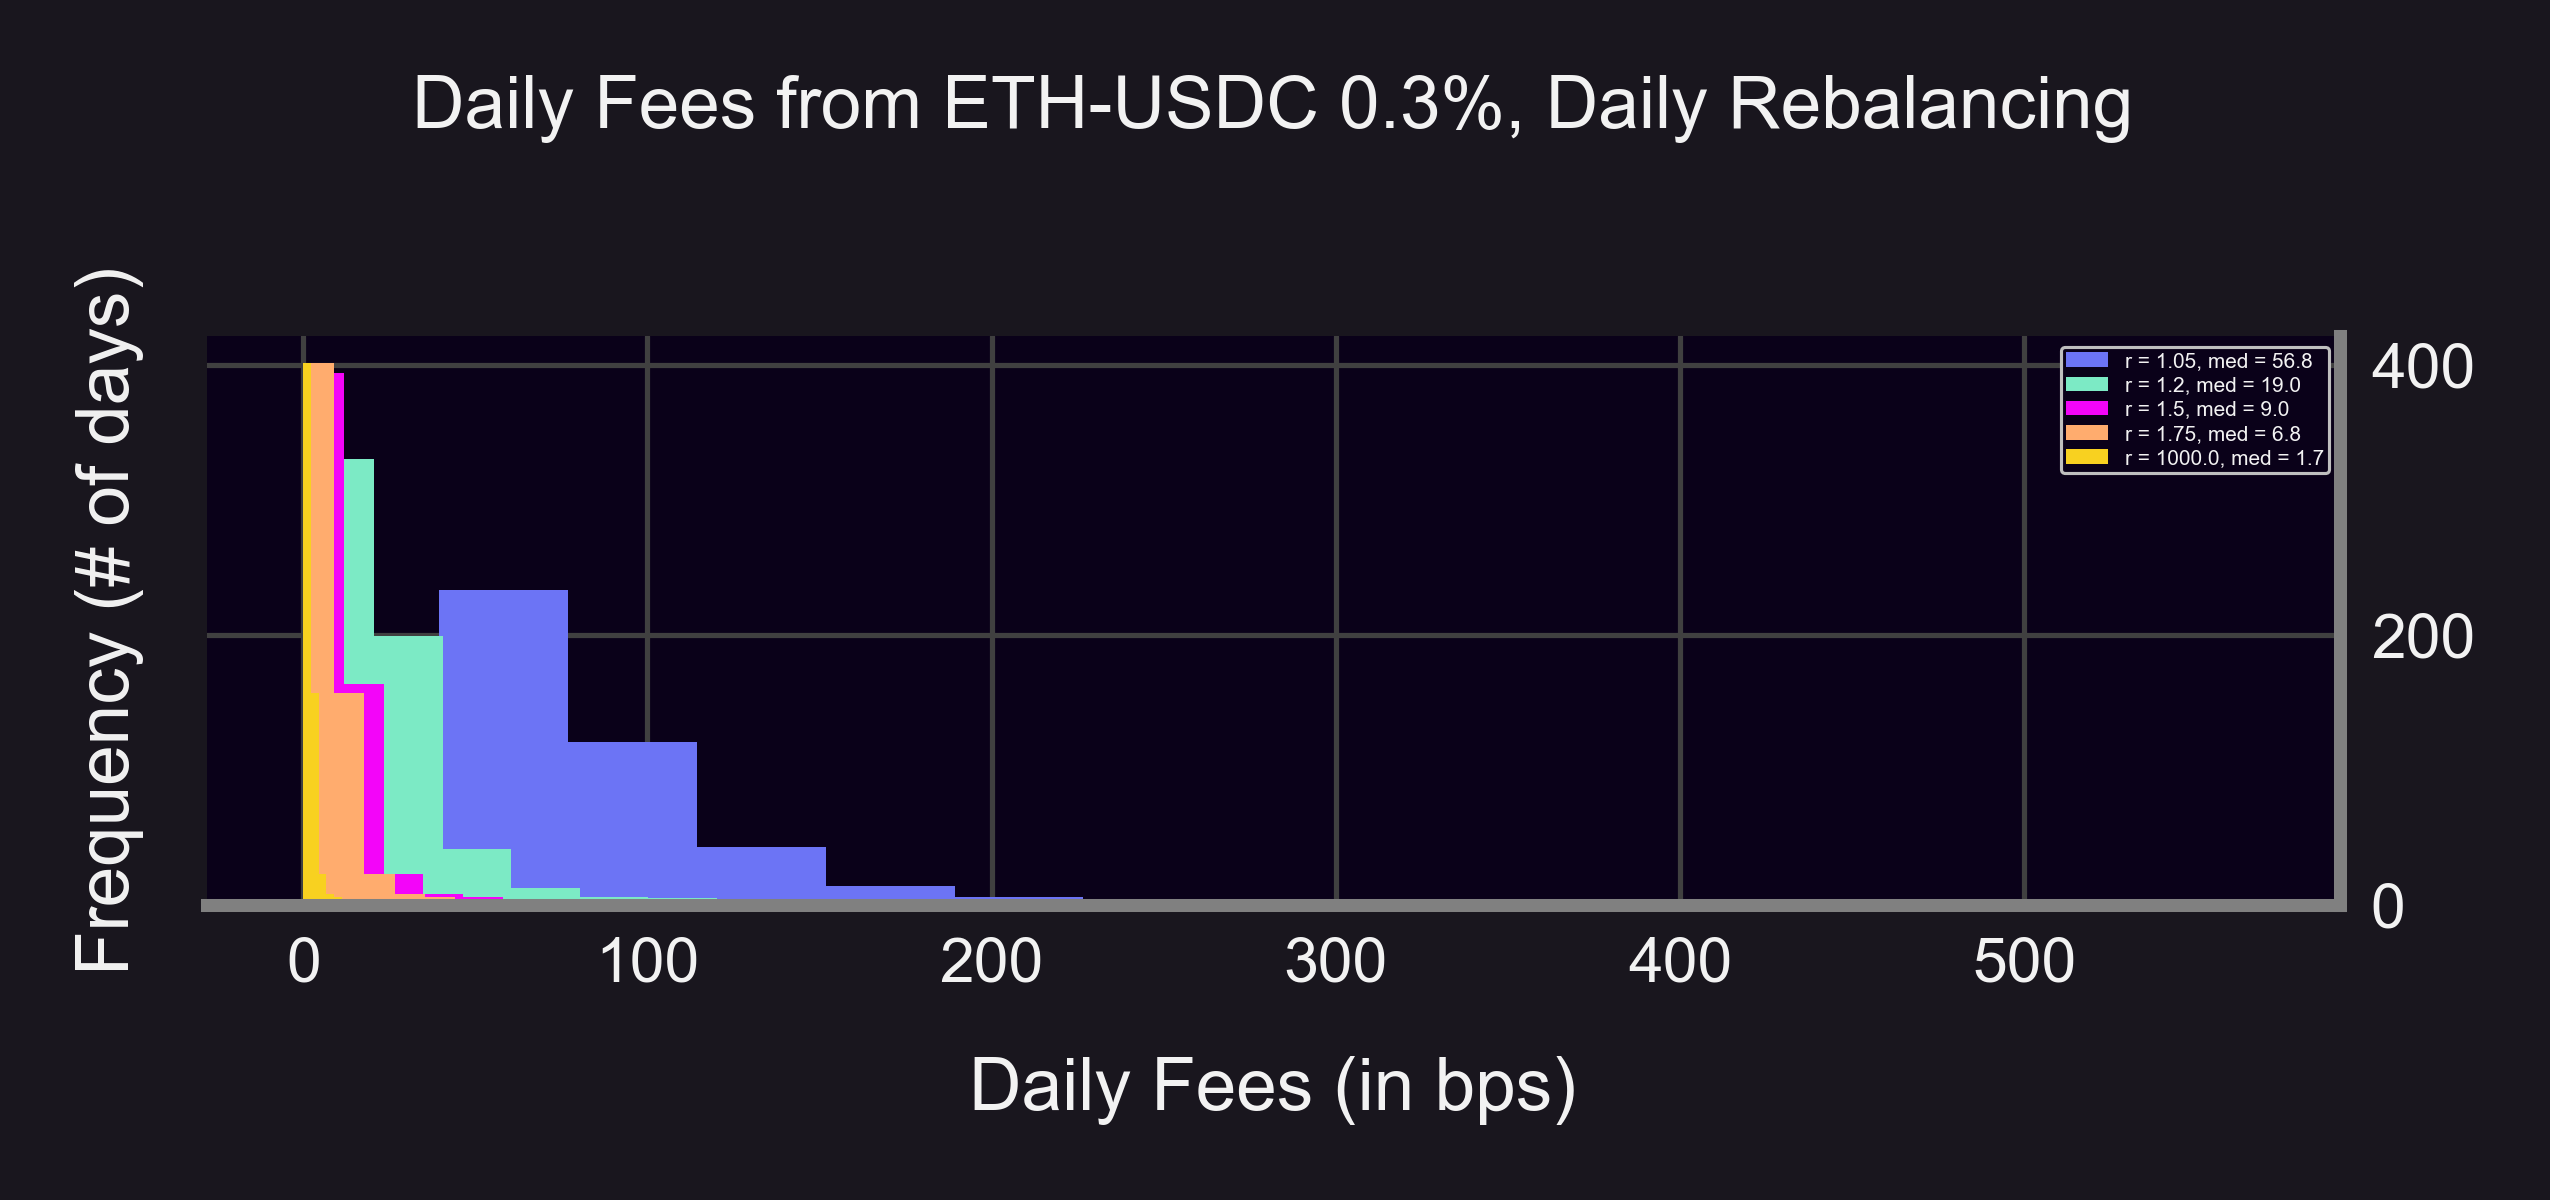

In [9]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'] * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'] * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'] * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_fees_FULL",
          bins = 15,
)

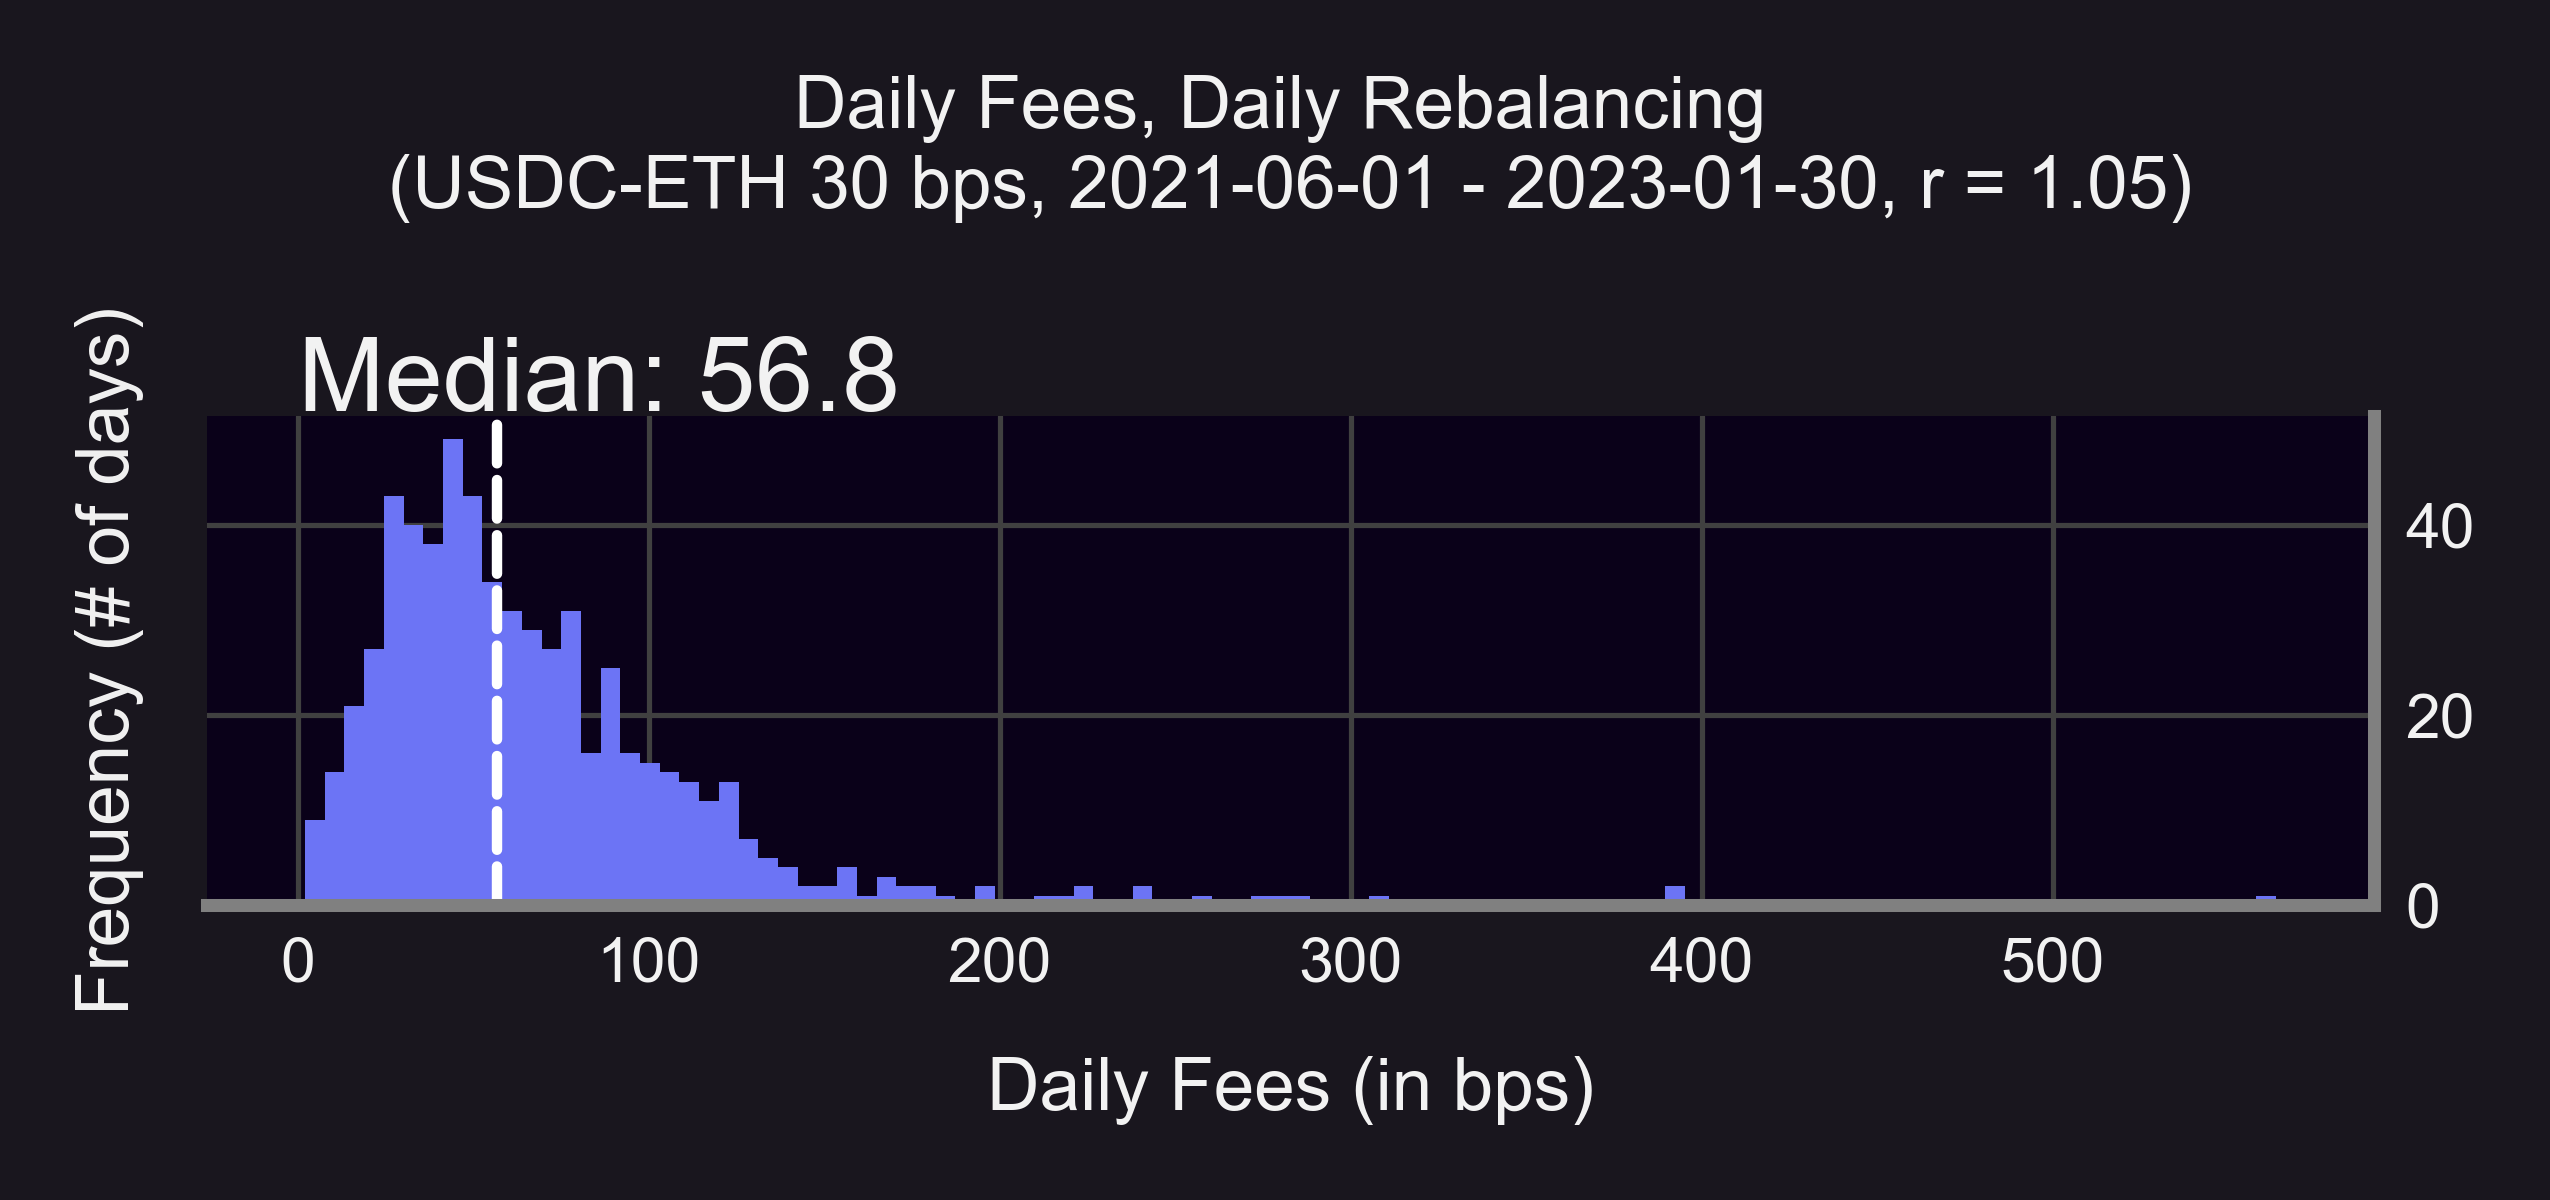

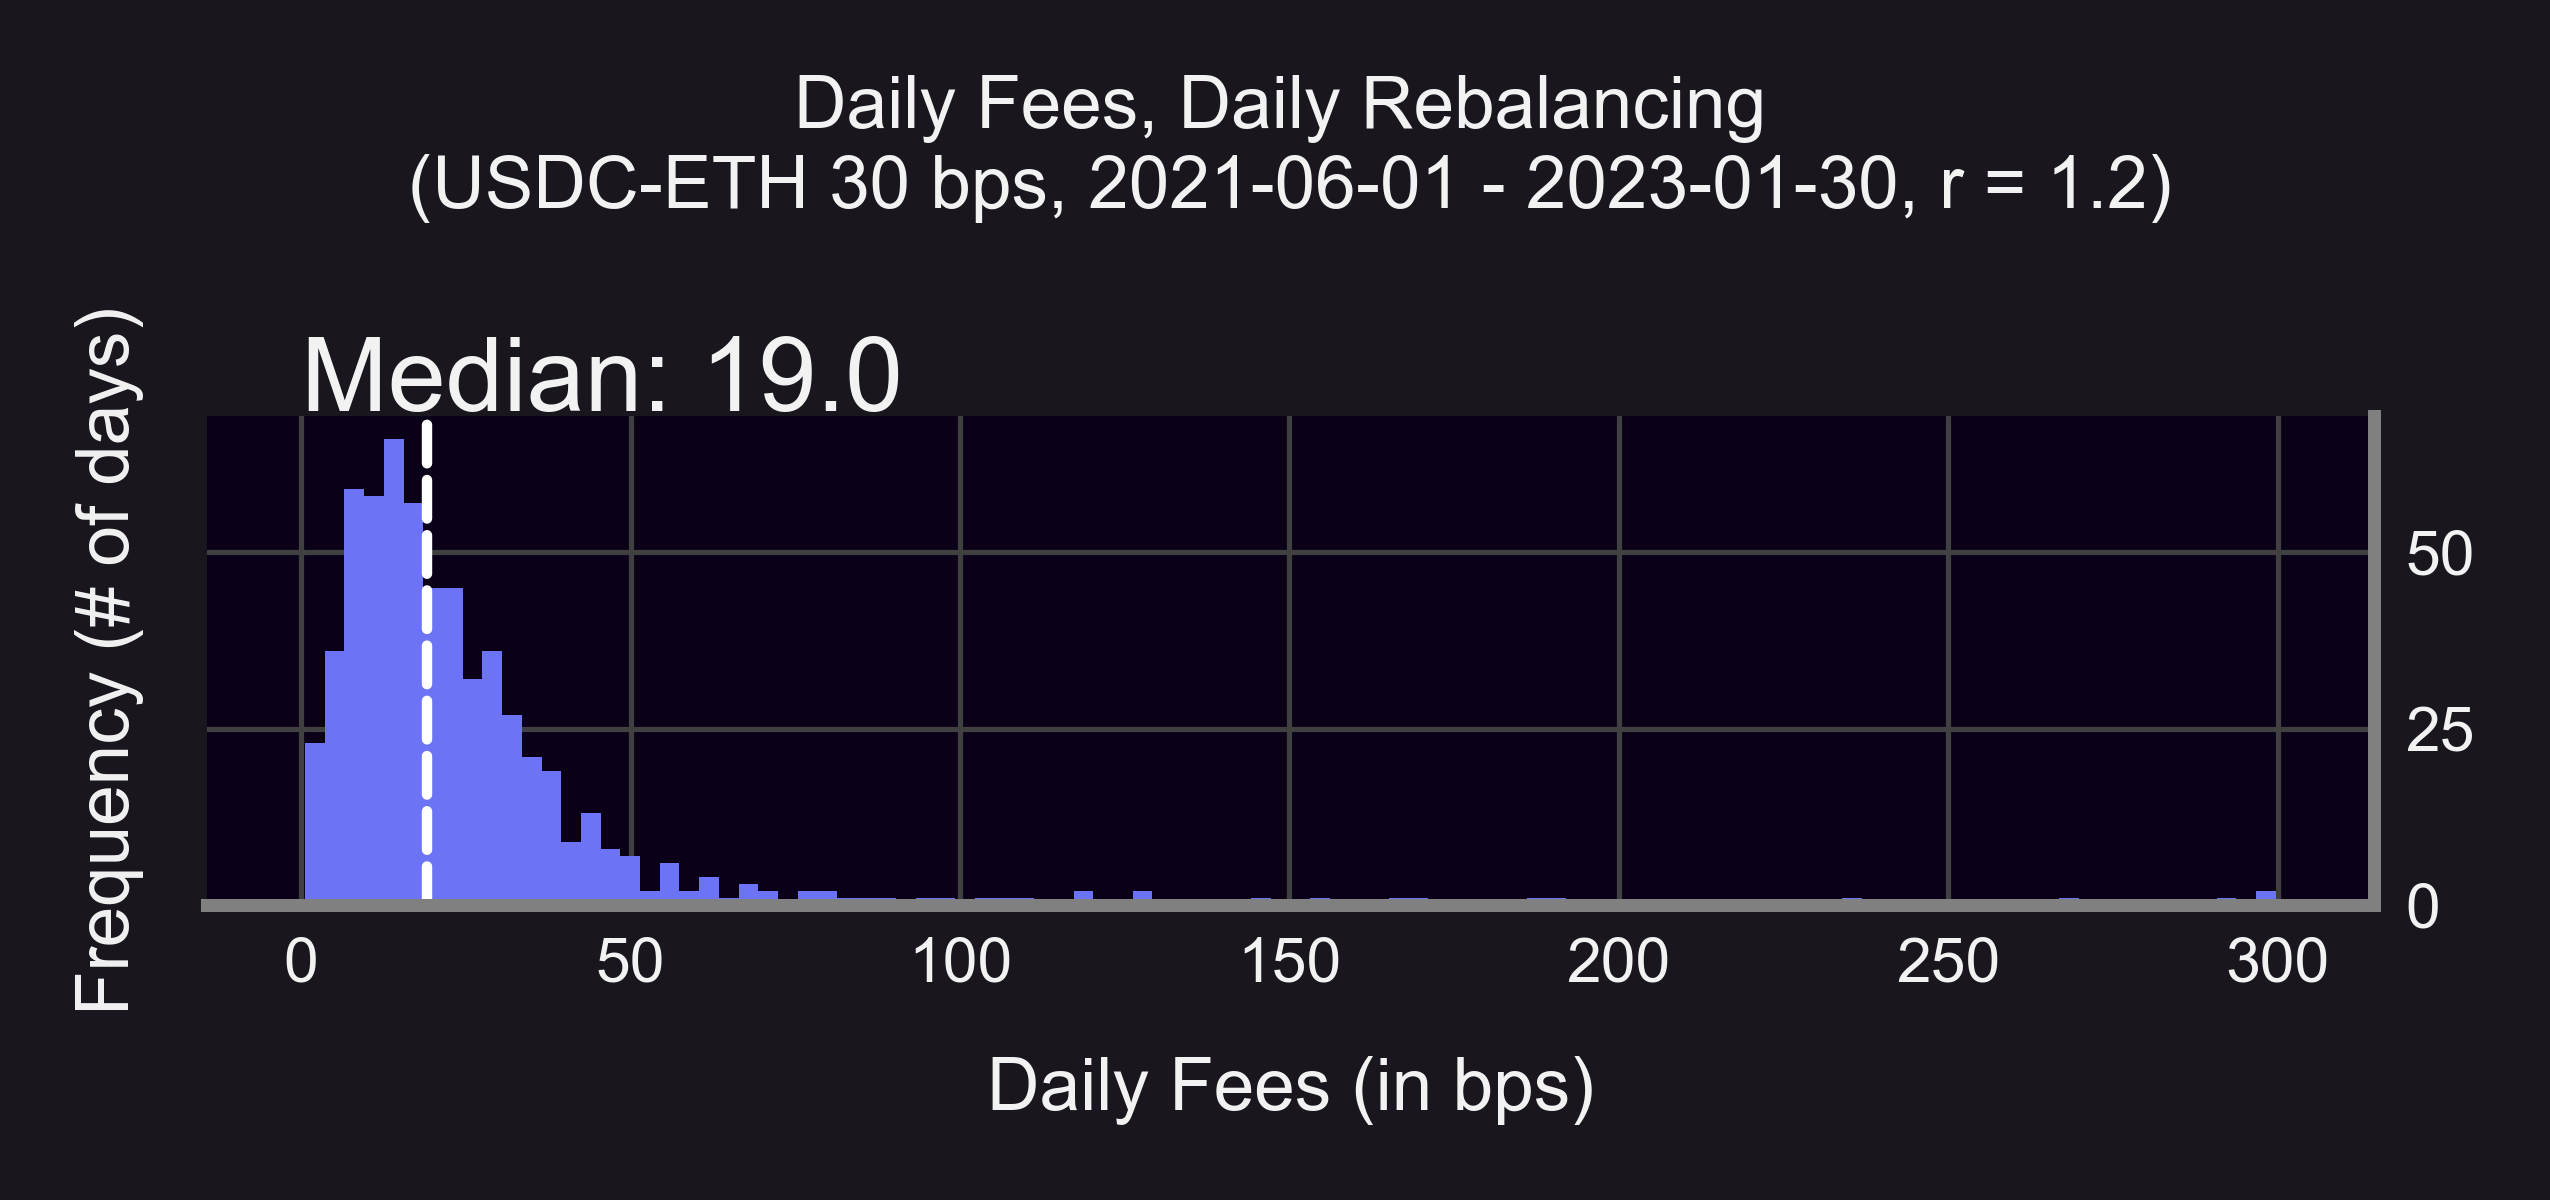

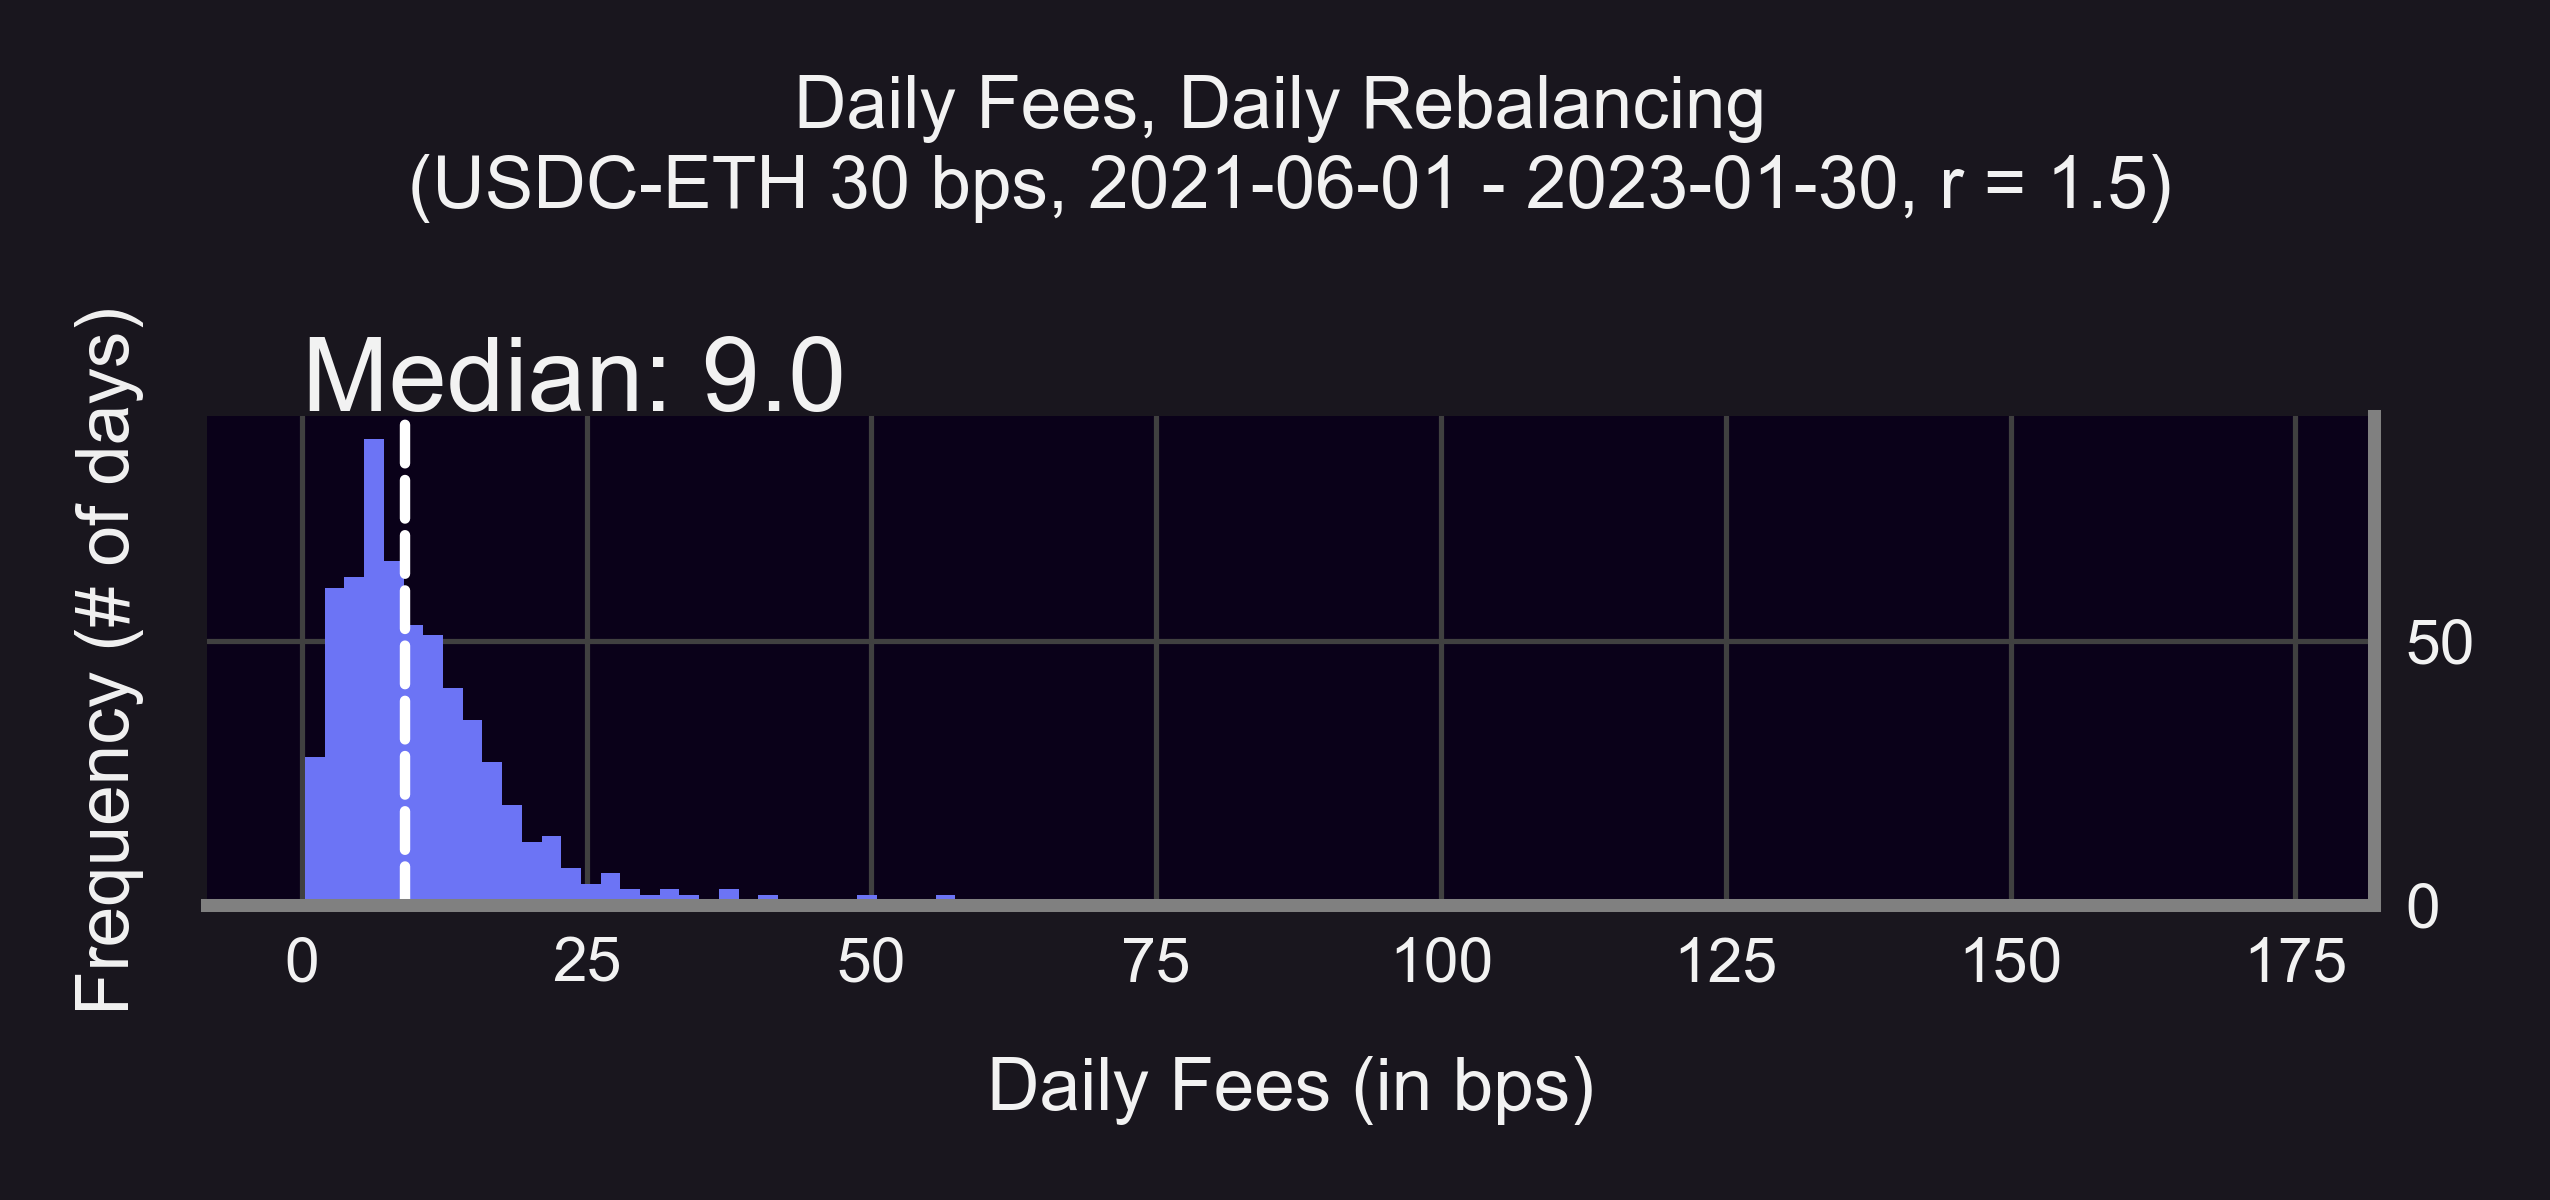

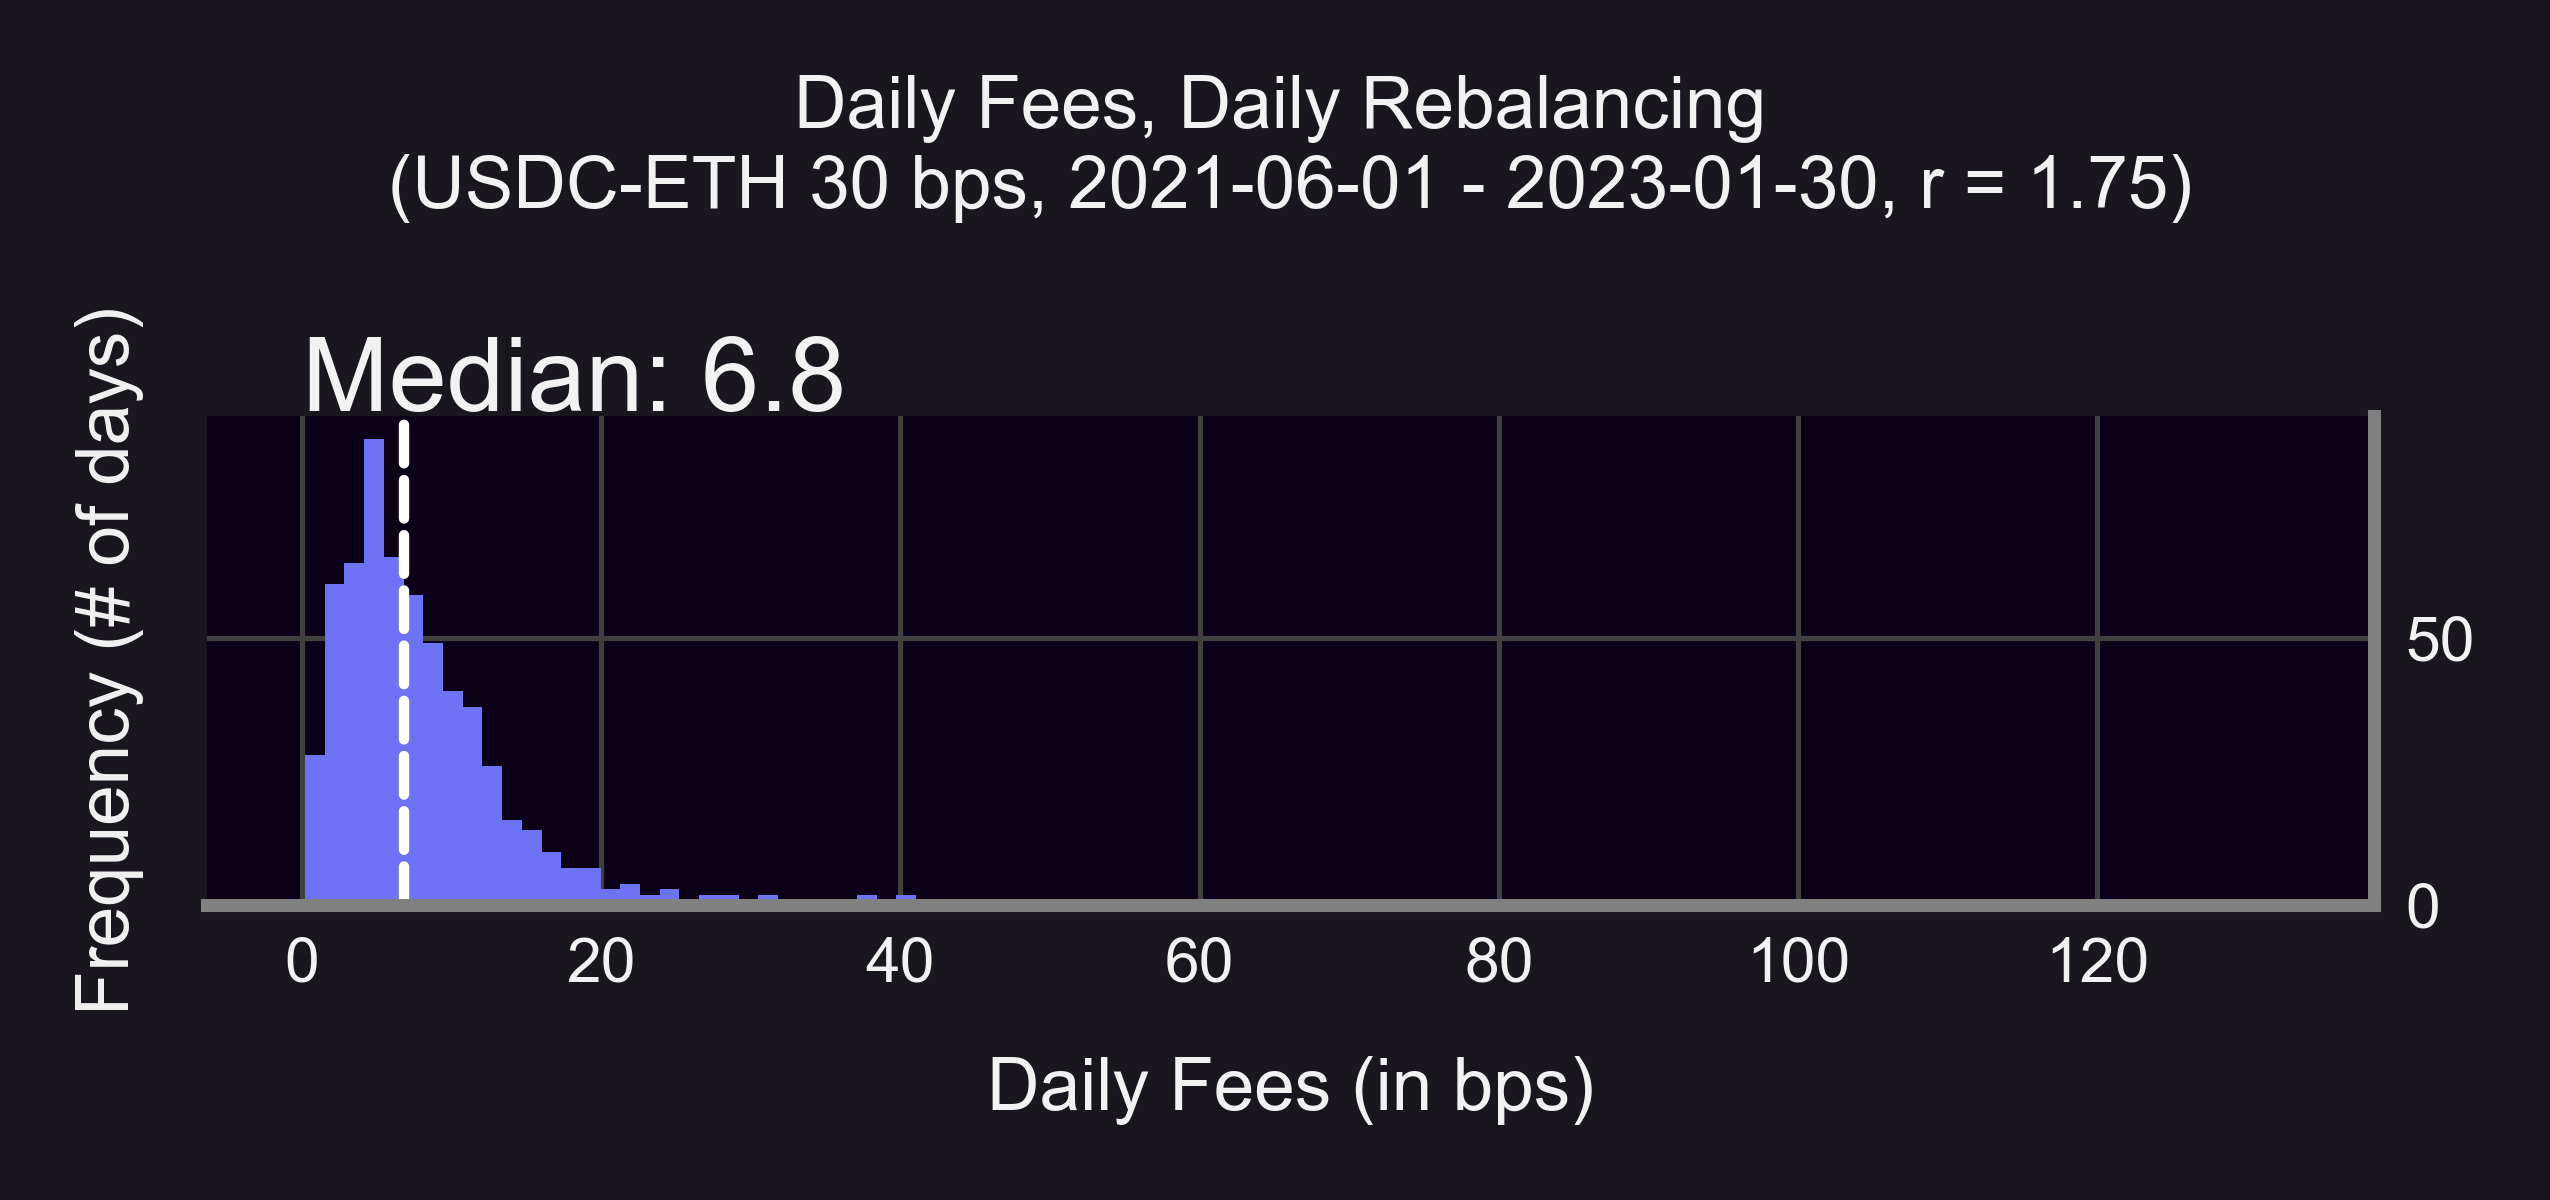

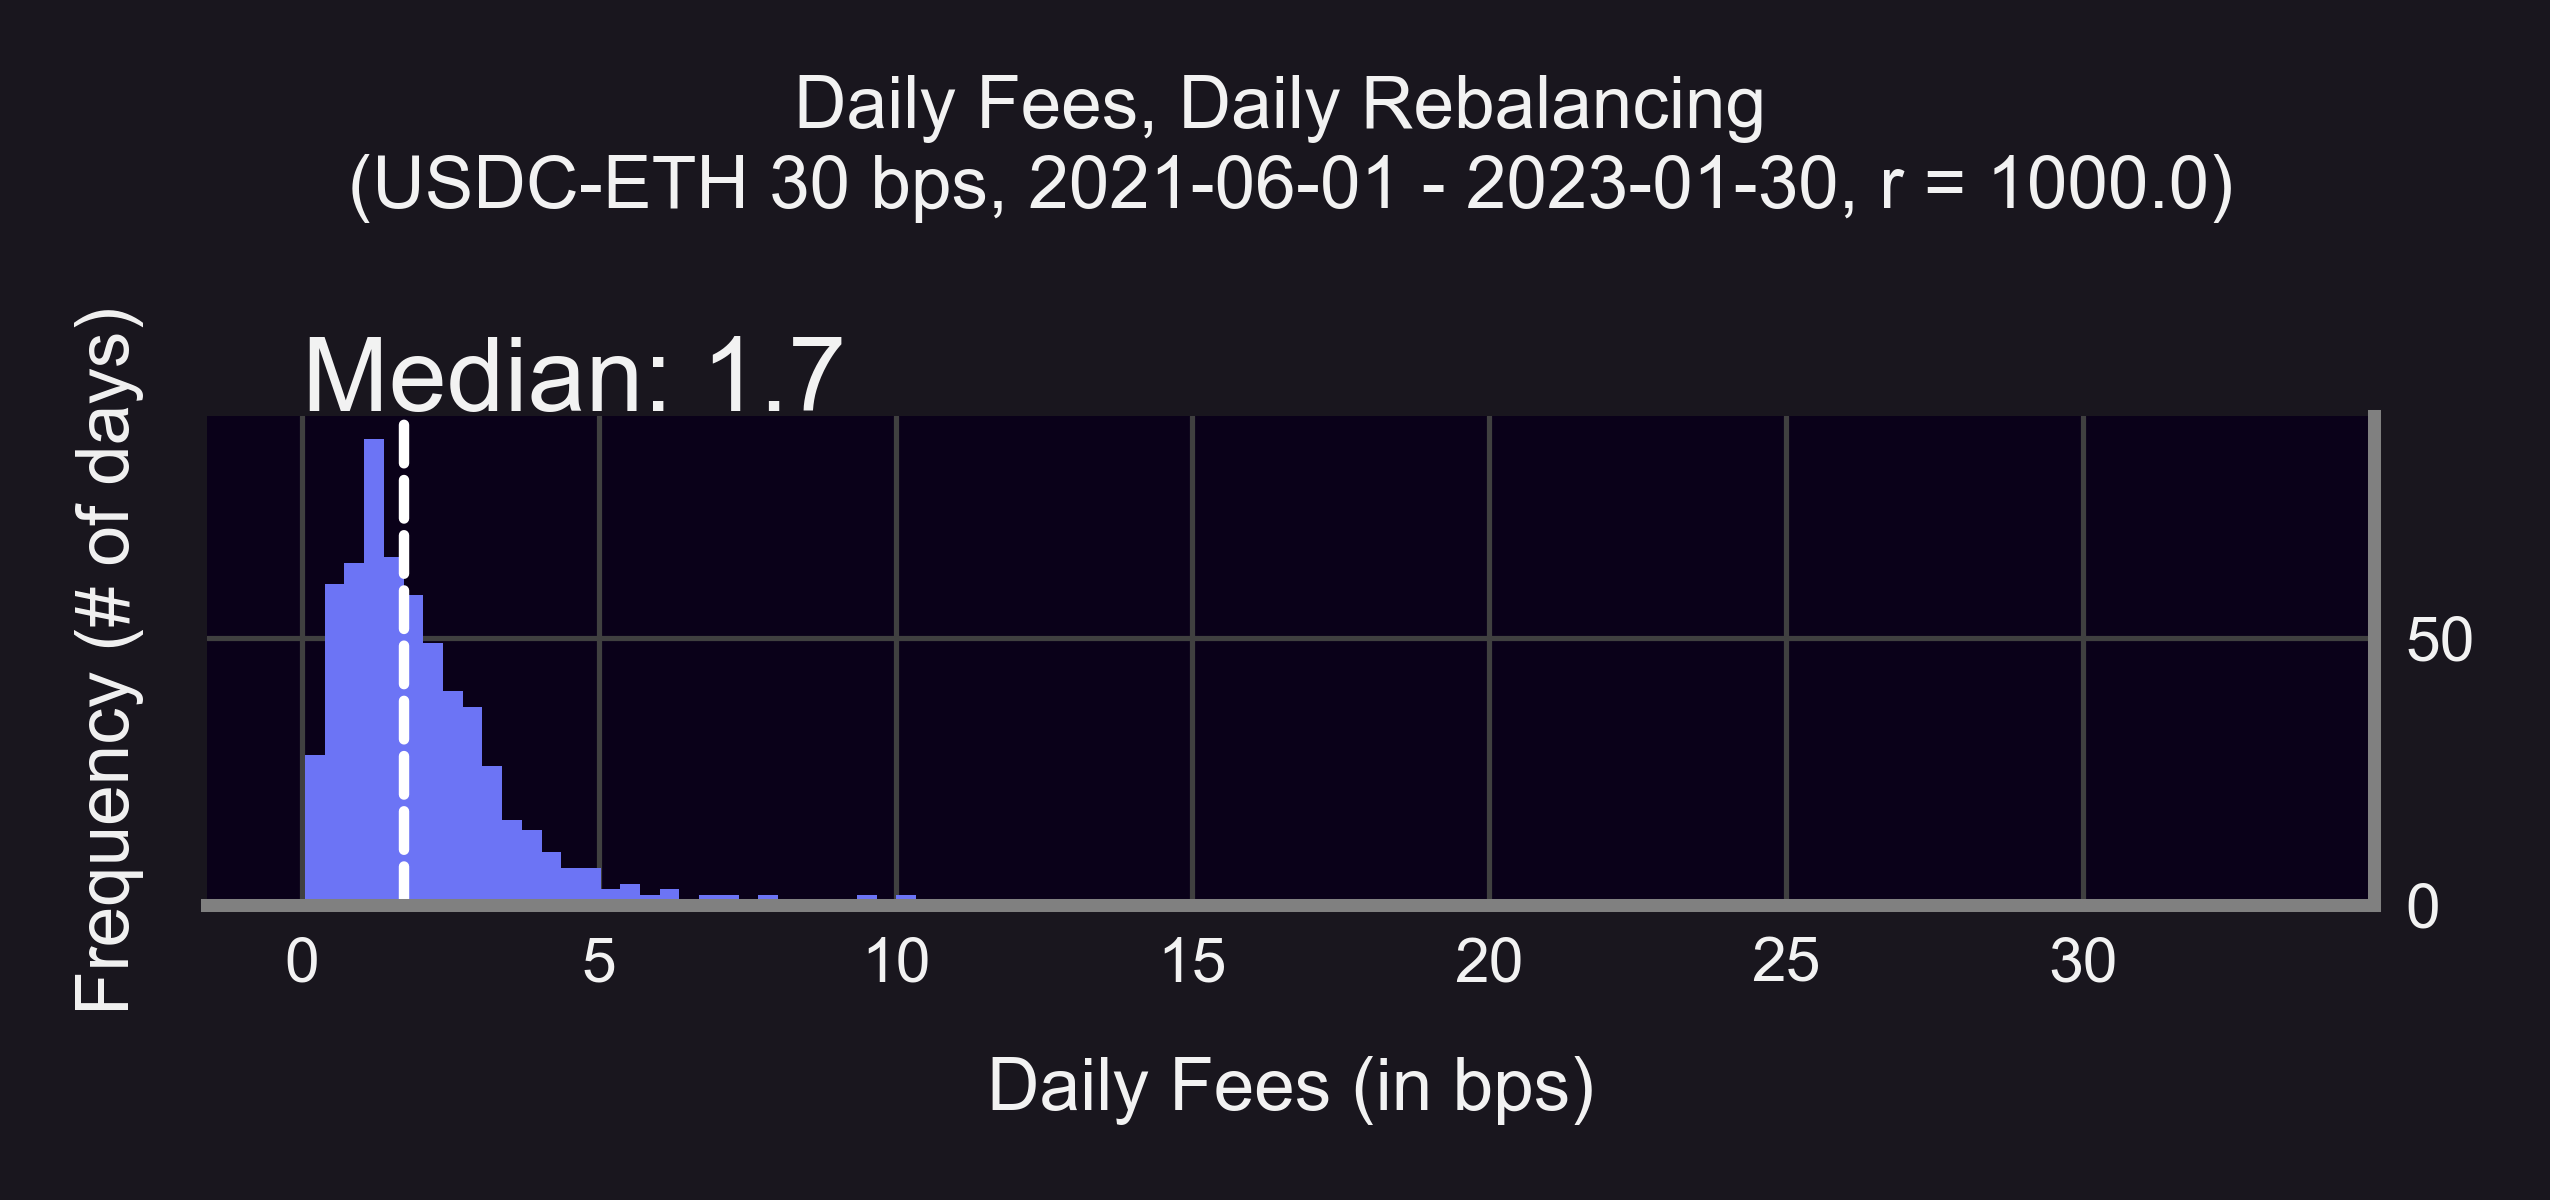

In [10]:
'''Plot histograms one-by-one'''
BPS = 10_000
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          #Plot daily rebalancing strategy
          plot_hist(s = strat.daily_fees['our_fees'] * BPS,
               xlabel = 'Daily Fees (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees, Daily Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_fees_d",
               bins=100
          )
     if 'a' in period or 'w' in period:
          # Plot weekly rebalancing strategy
          plot_hist(s = strat.weekly_fees['our_fees'] * BPS,
               xlabel = 'Daily Fees (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees, Weekly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_fees_w",
               bins=100
          )
     if 'a' in period or 'm' in period:
          # Plot monthly rebalancing strategy
          plot_hist(s = strat.monthly_fees['our_fees'] * BPS,
               xlabel = 'Daily Fees (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees, Monthly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_fees_m",
               bins=50
          )

### Returns

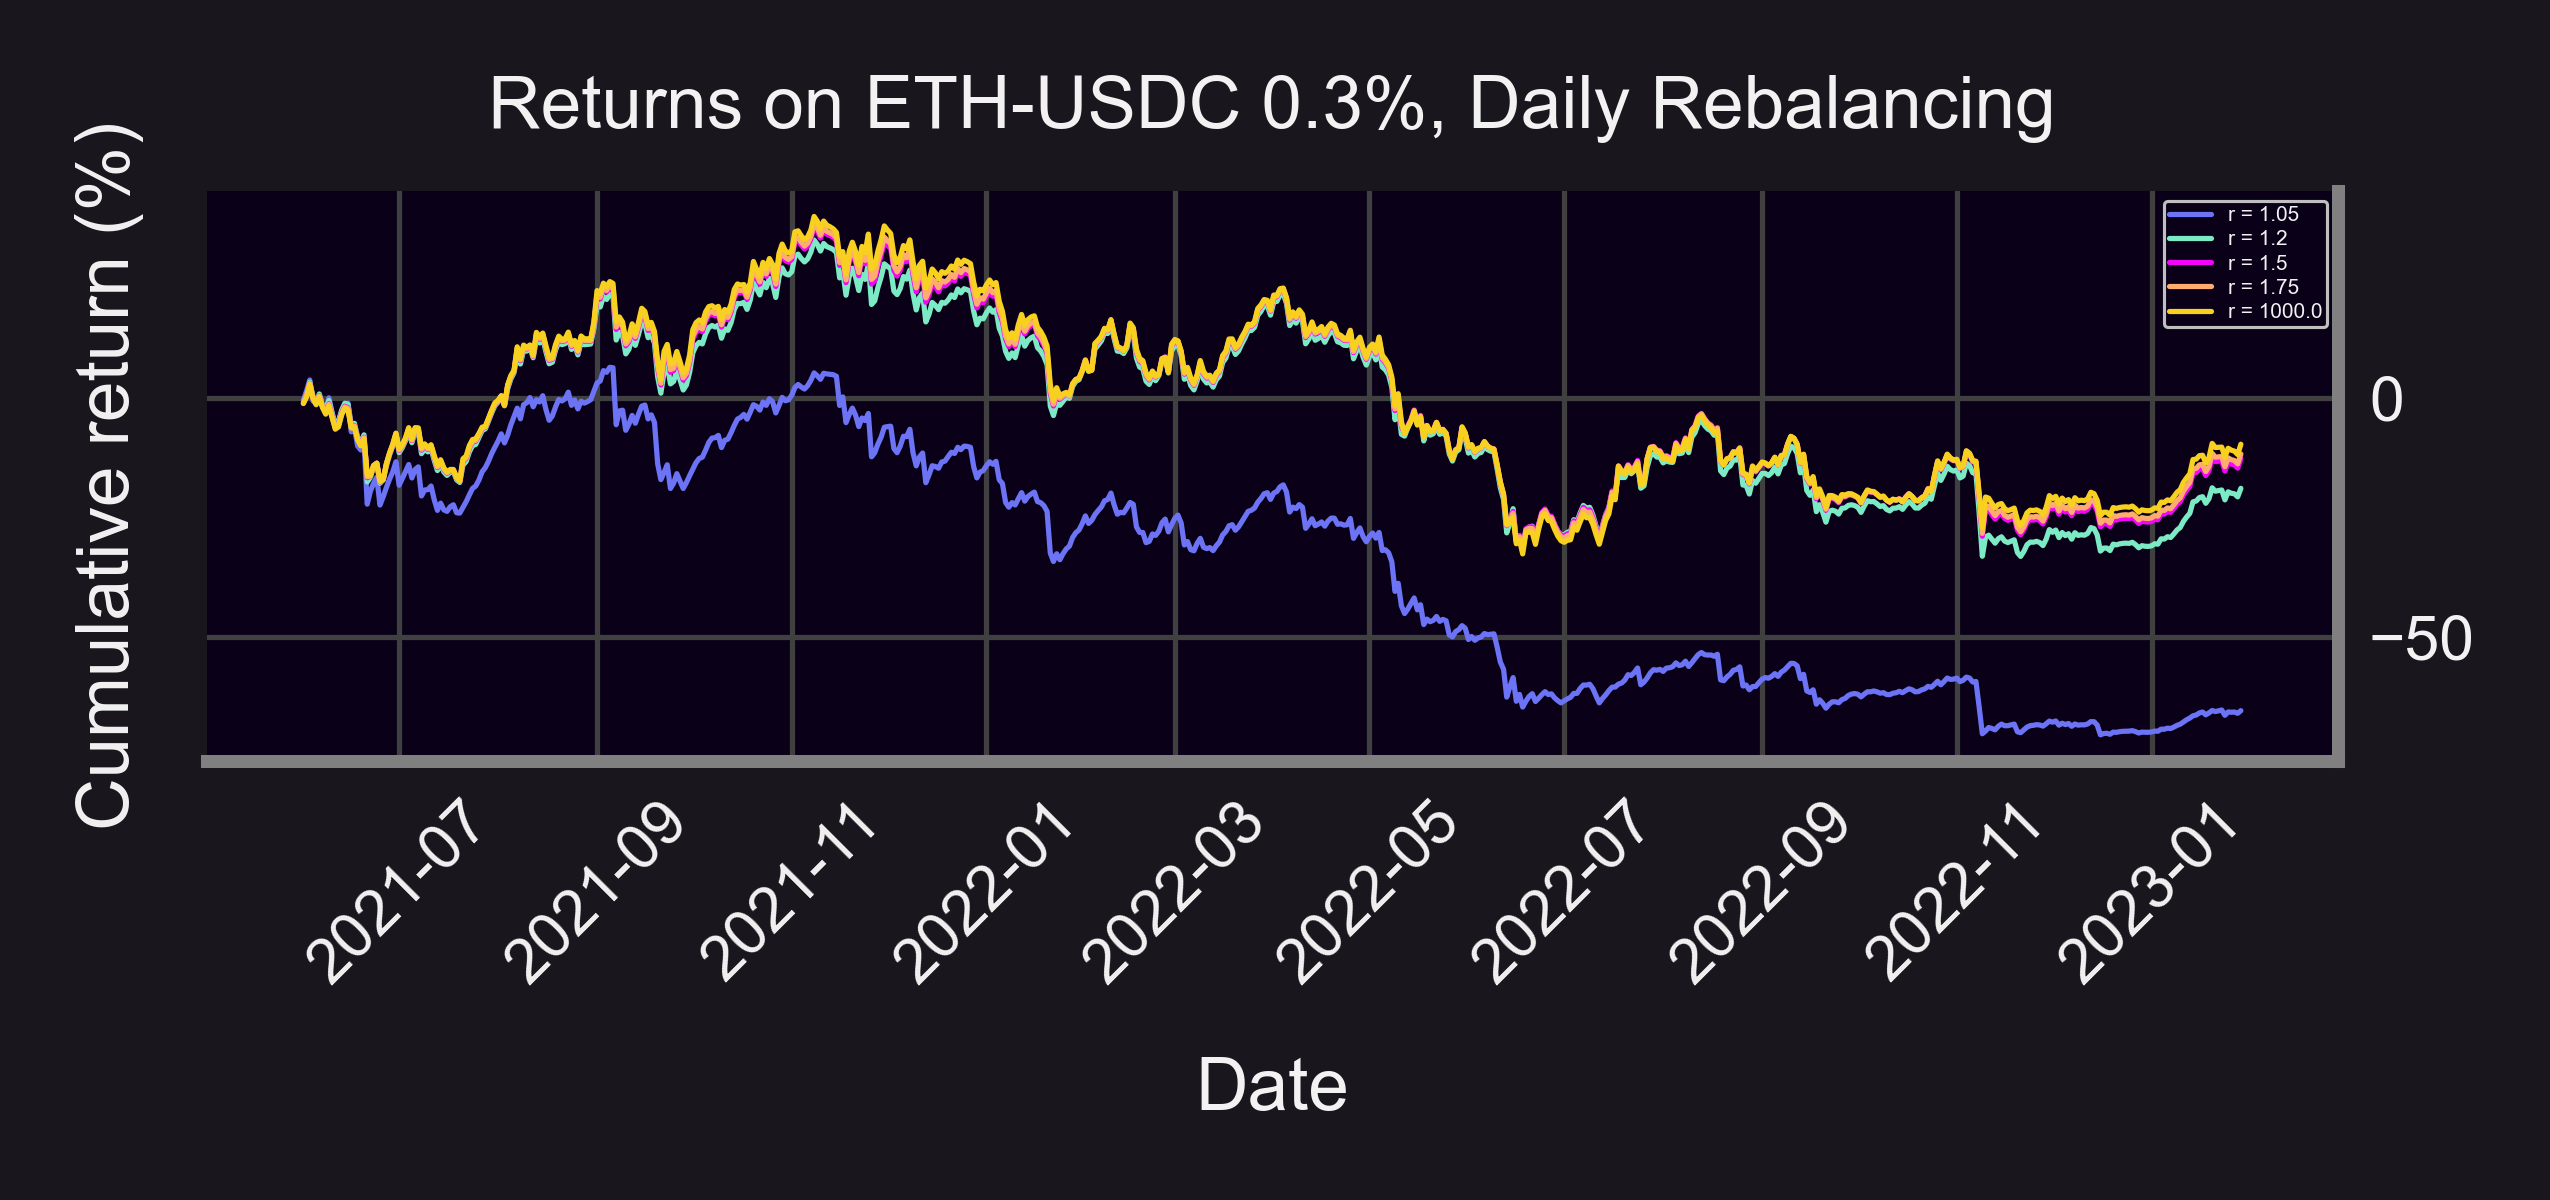

In [11]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'] + strat.daily_pos['pnl_perc']
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'] + strat.weekly_pos['pnl_perc']
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'] + strat.monthly_pos['pnl_perc']

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Returns on {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_rets_FULL"
)

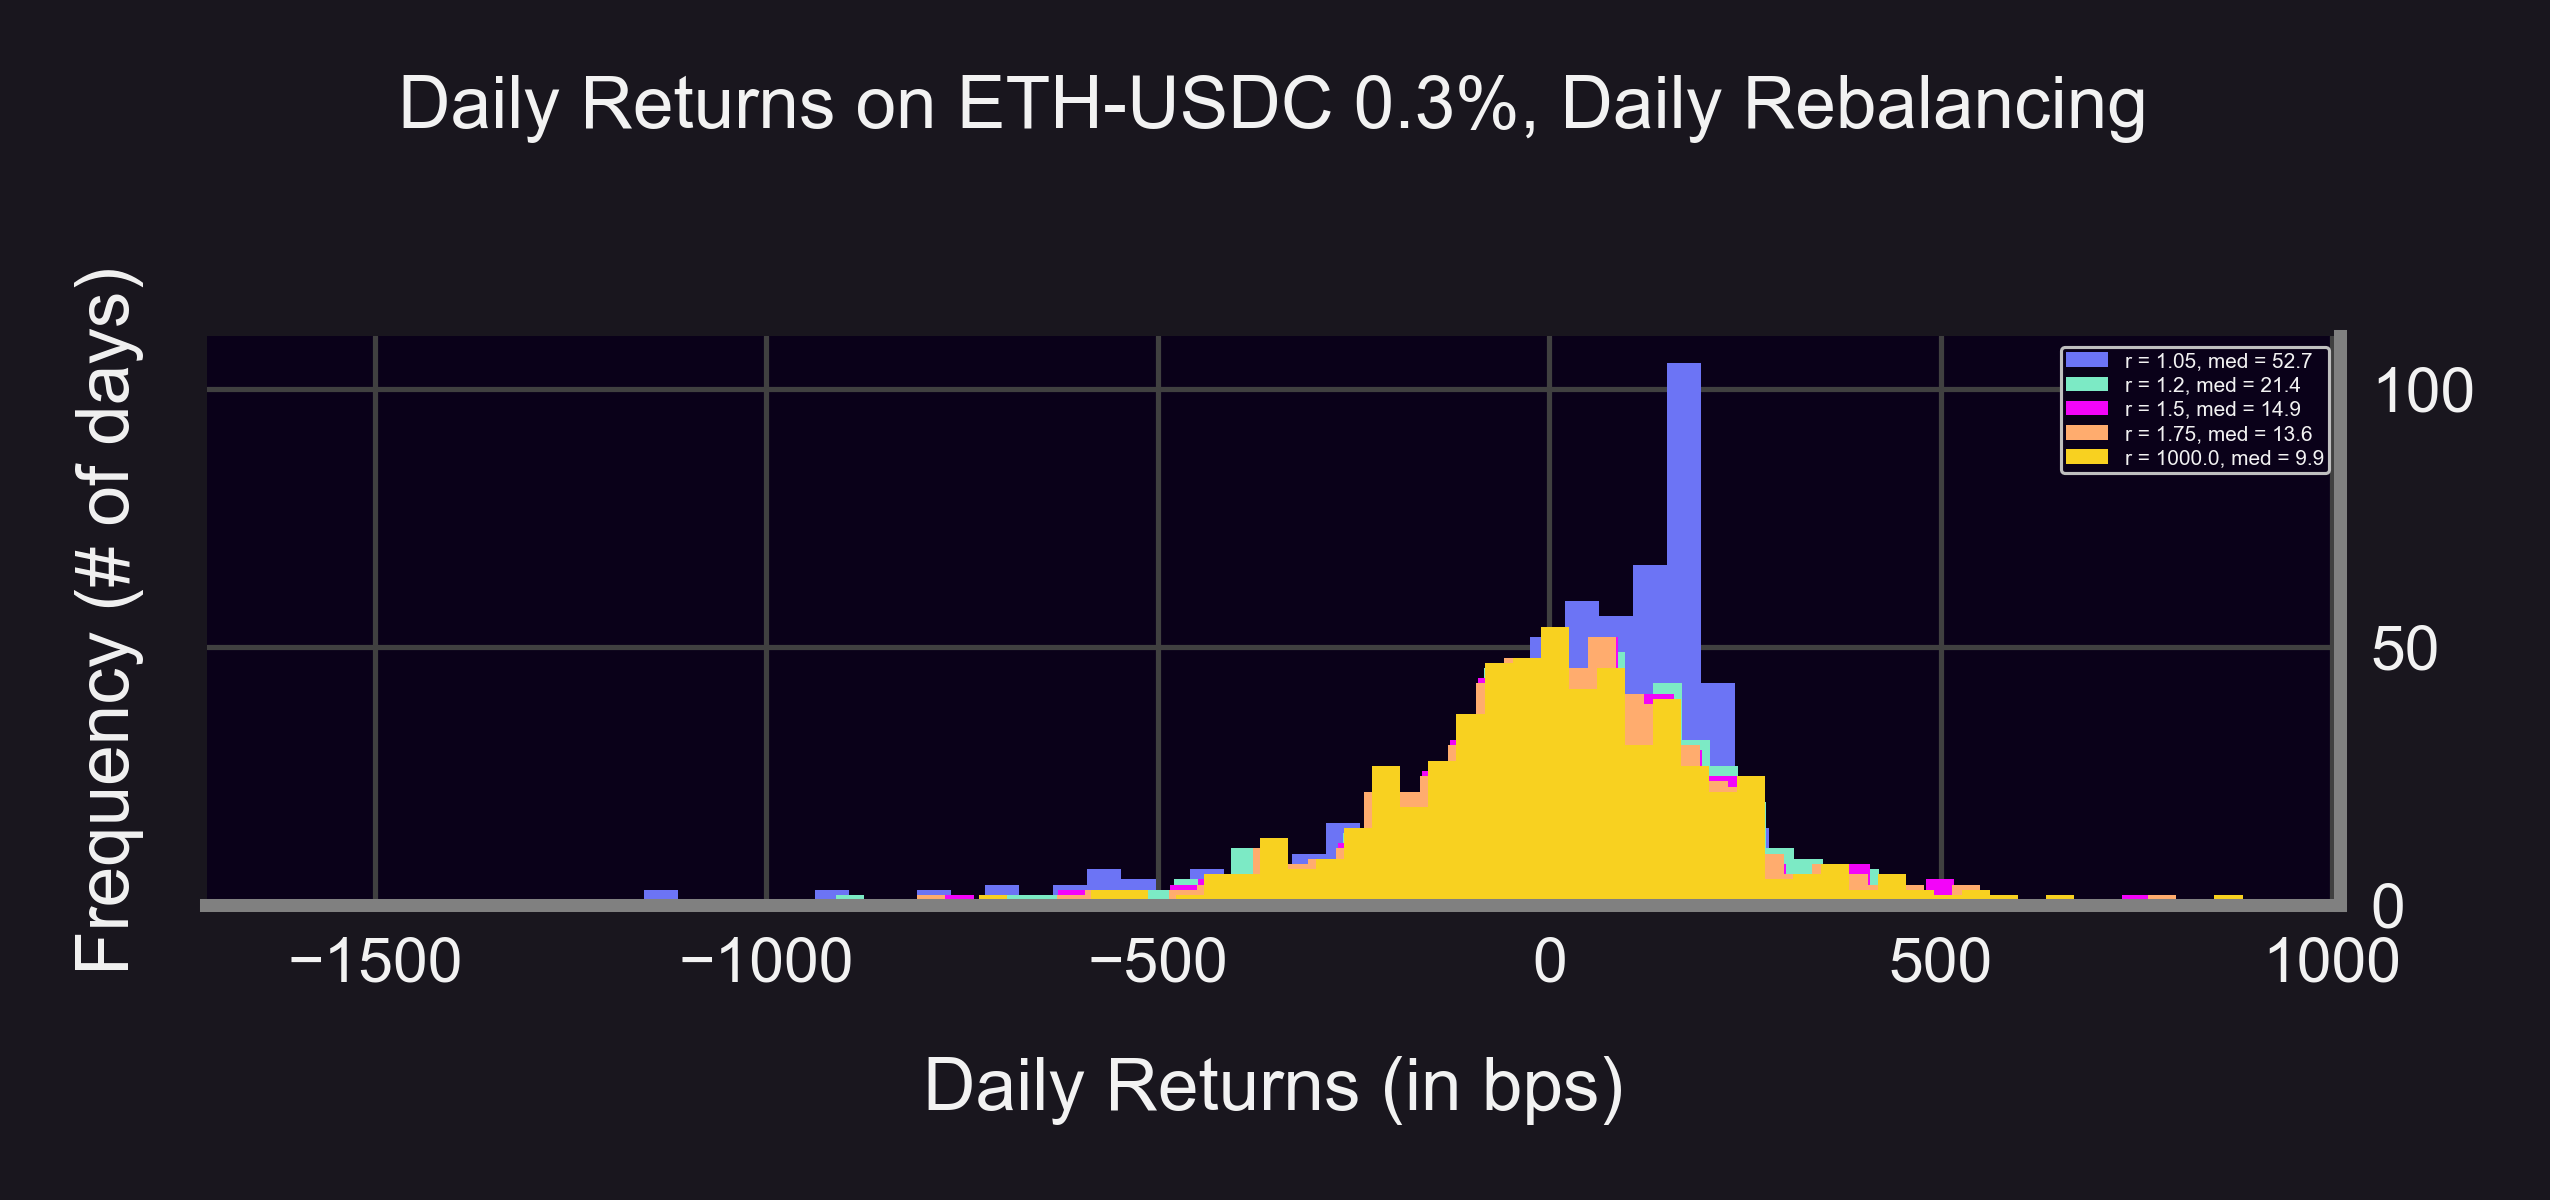

In [12]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'] + strat.daily_pos['pnl_perc']) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'] + strat.weekly_pos['pnl_perc']) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'] + strat.monthly_pos['pnl_perc']) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Returns (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Returns on {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_rets_FULL",
          bins = 50,
)

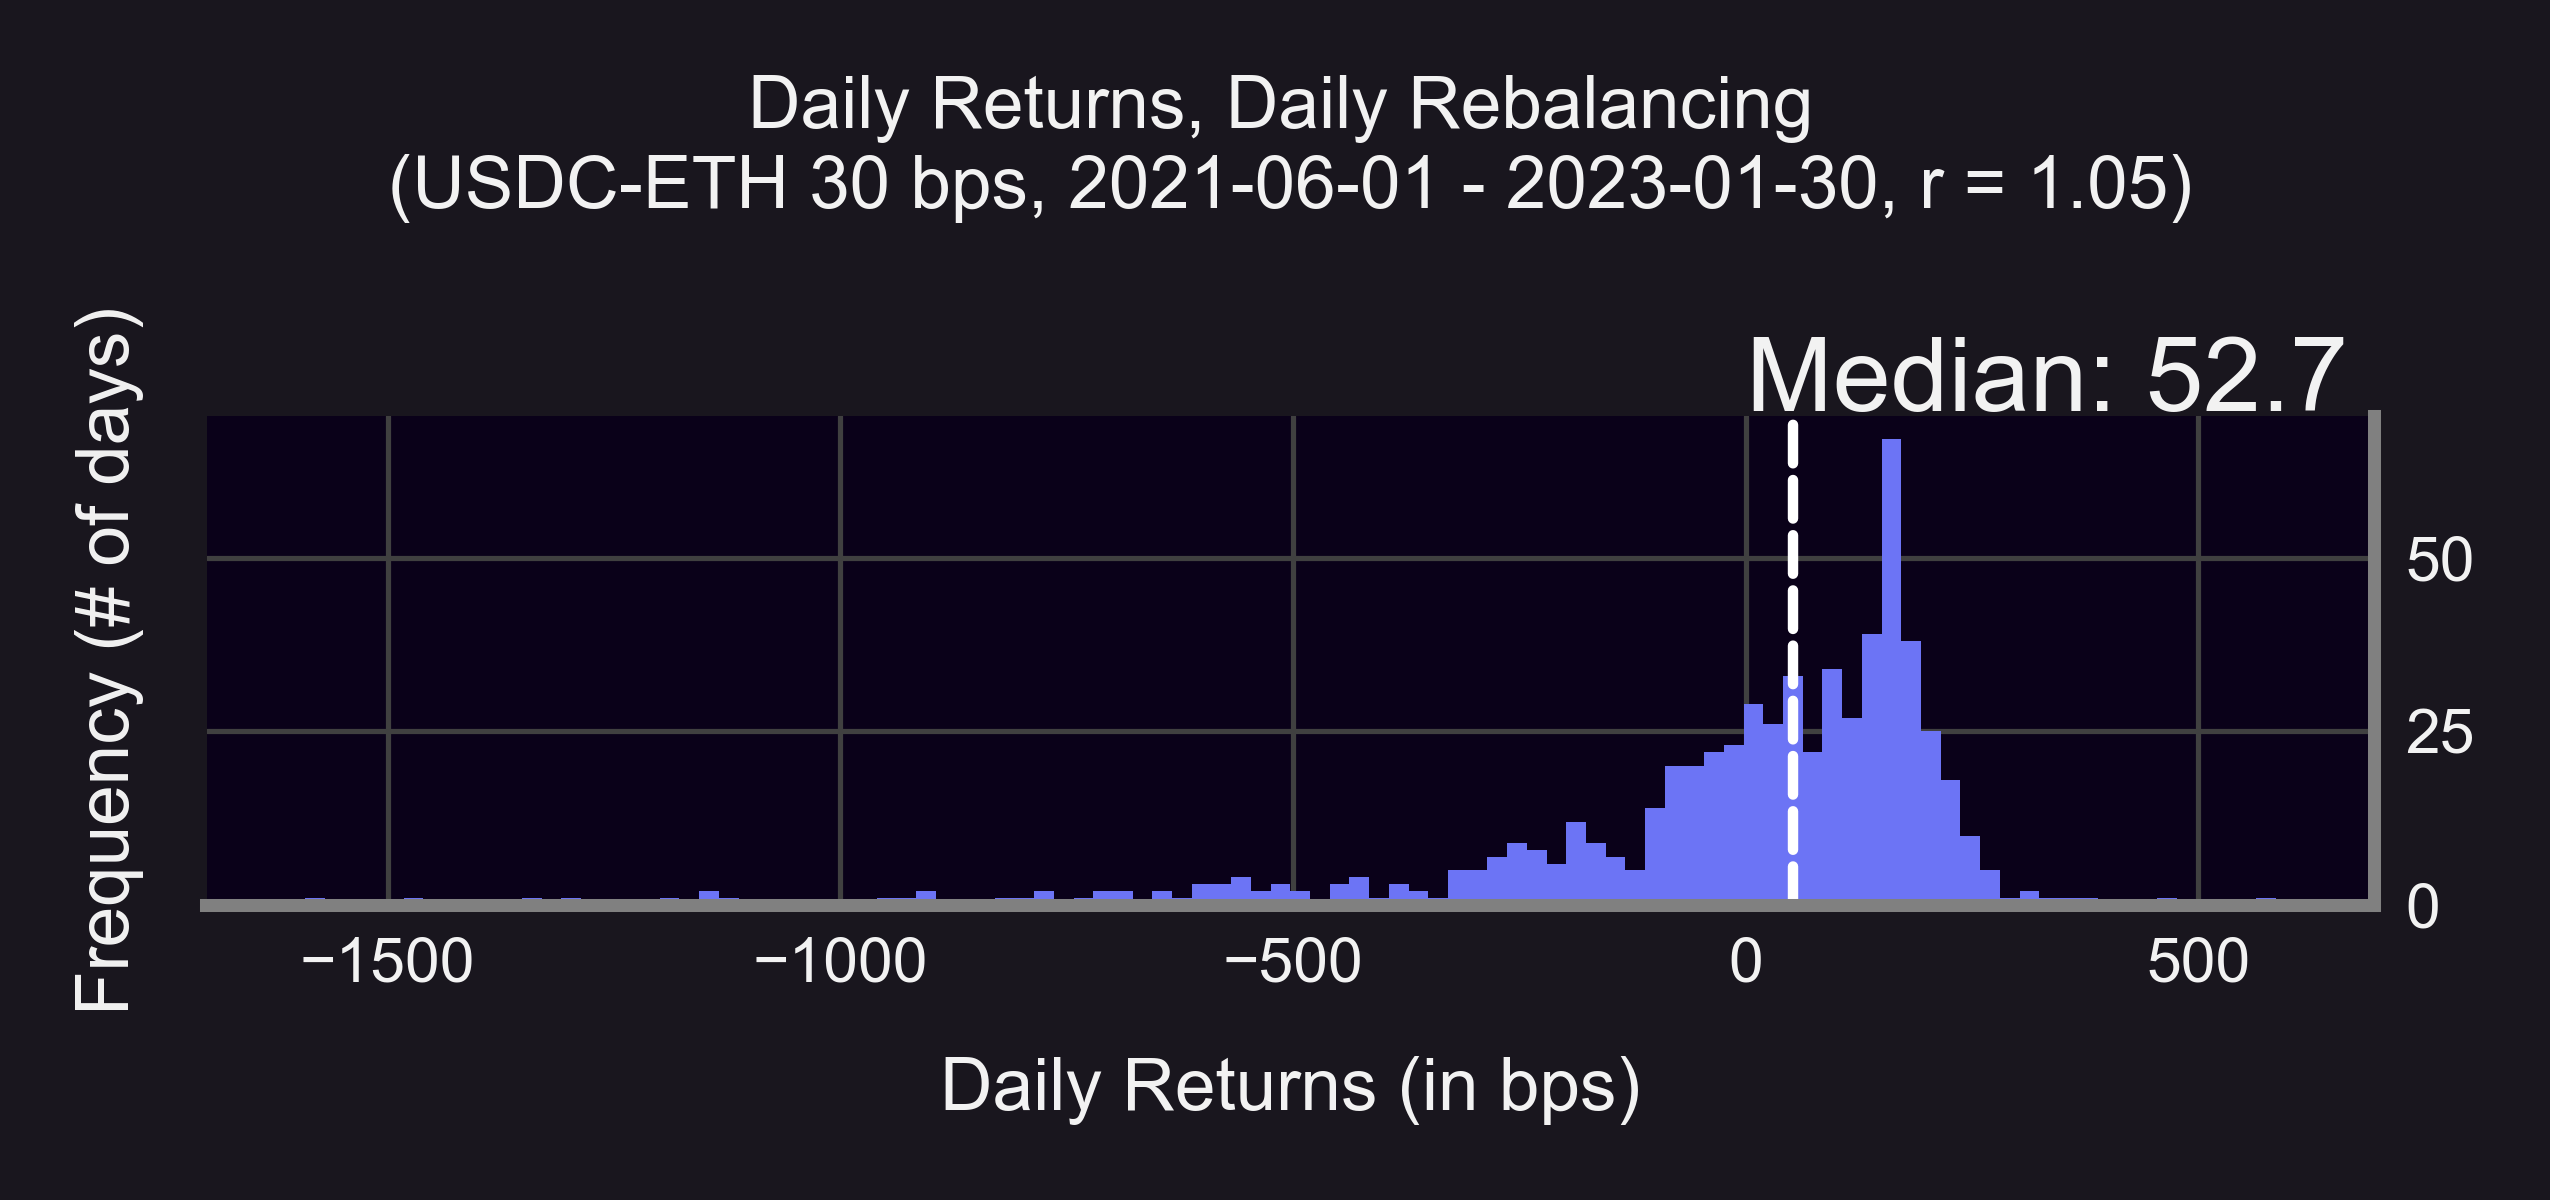

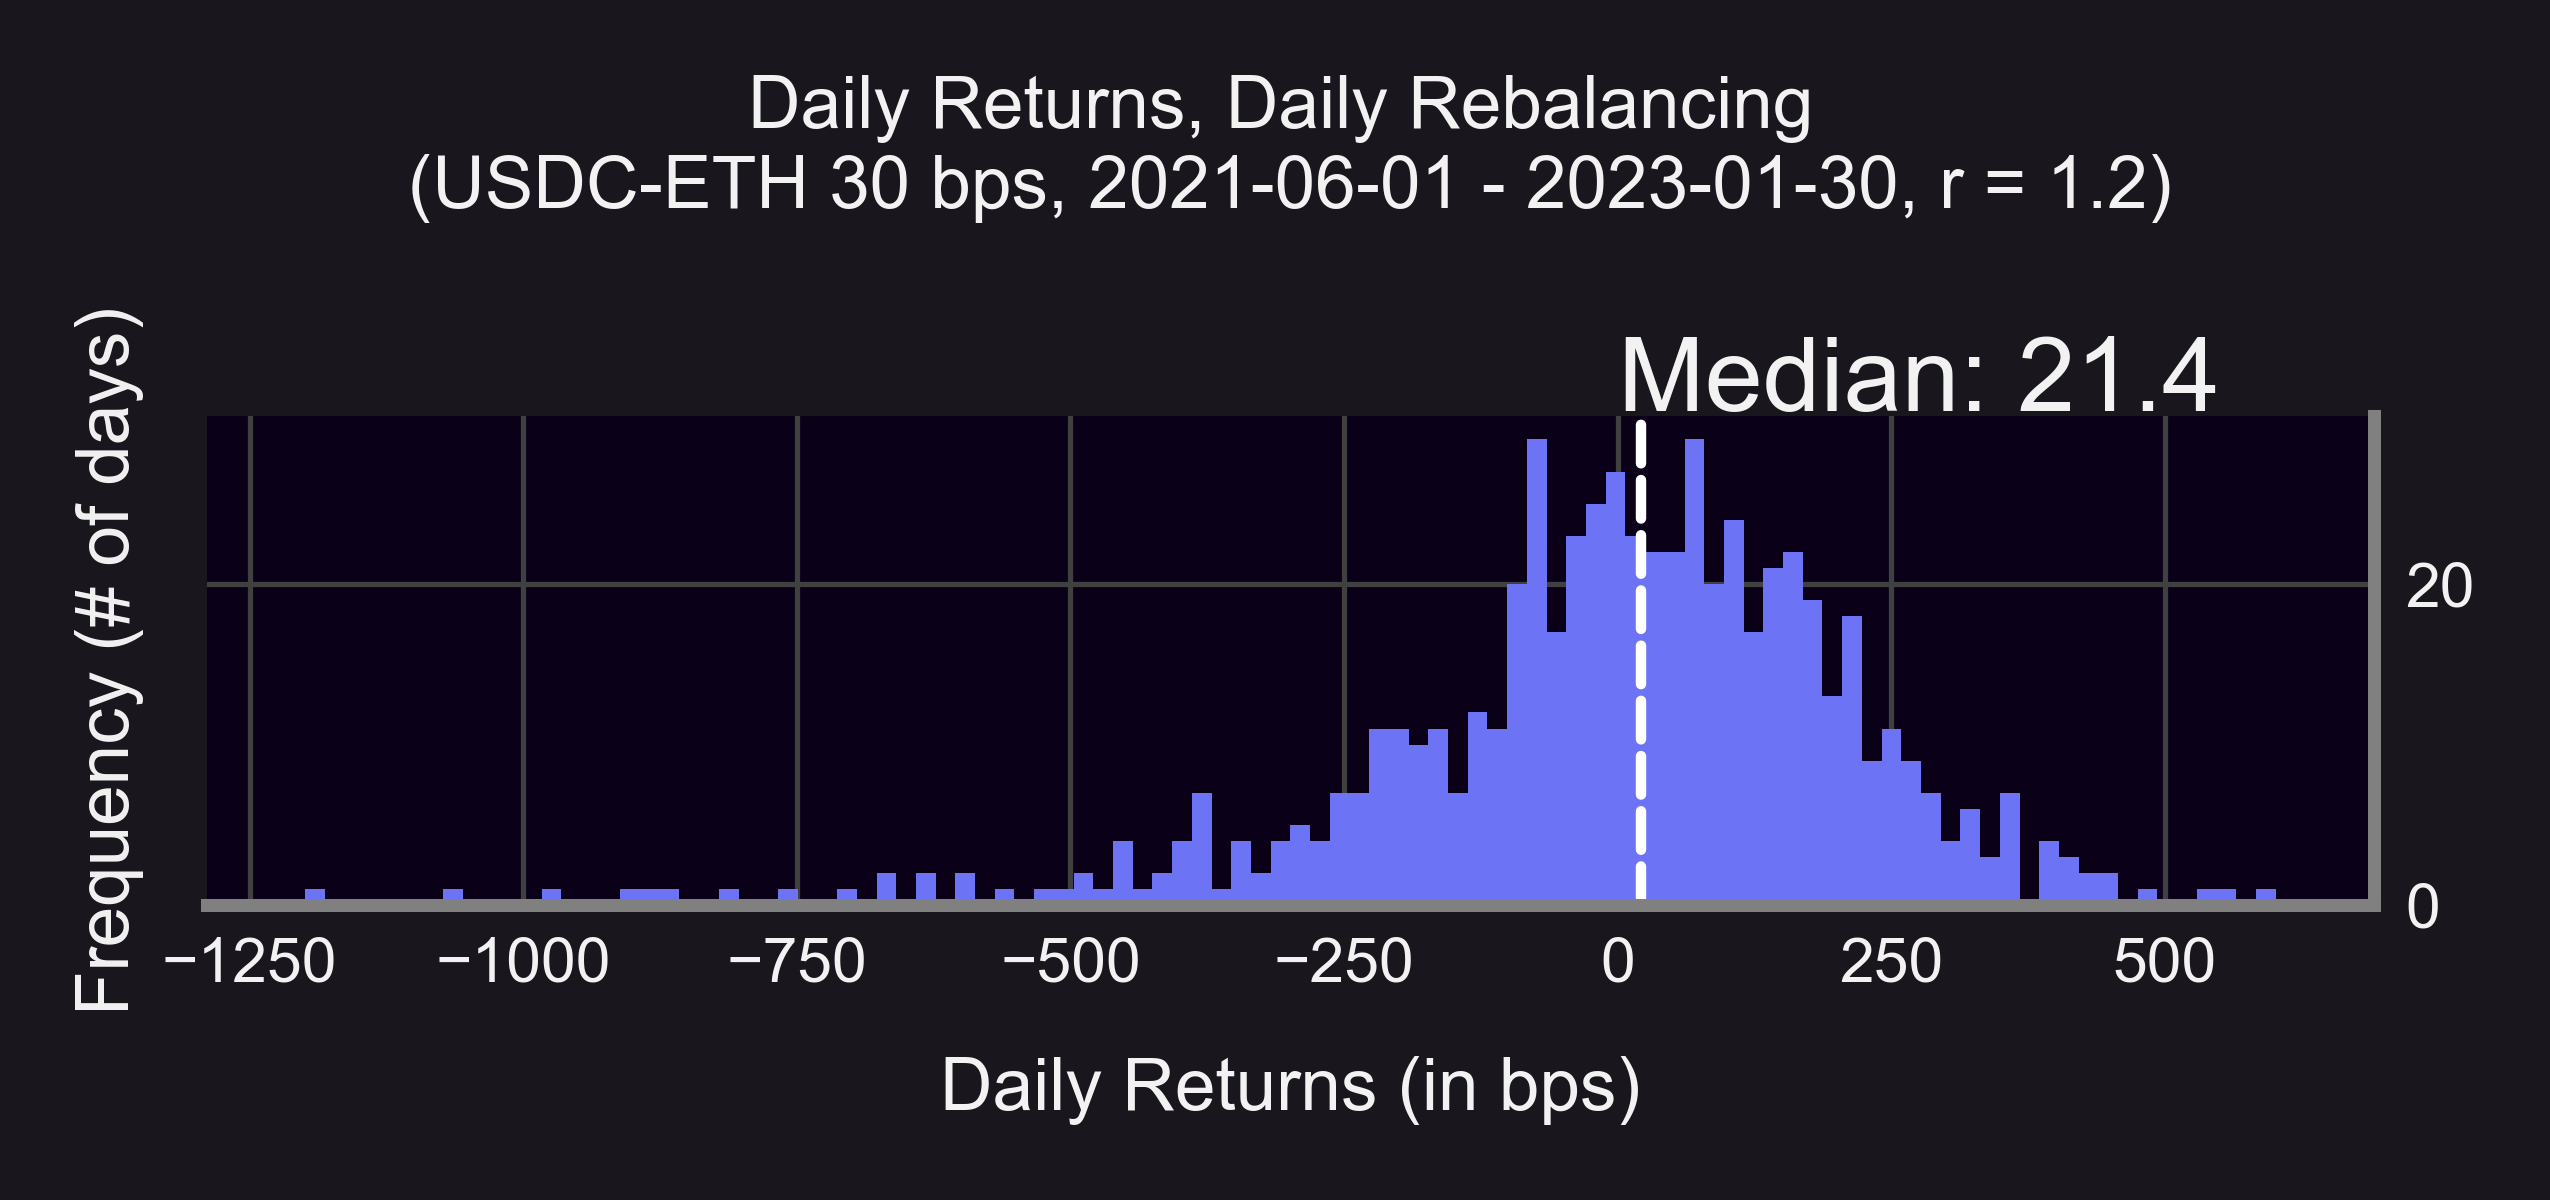

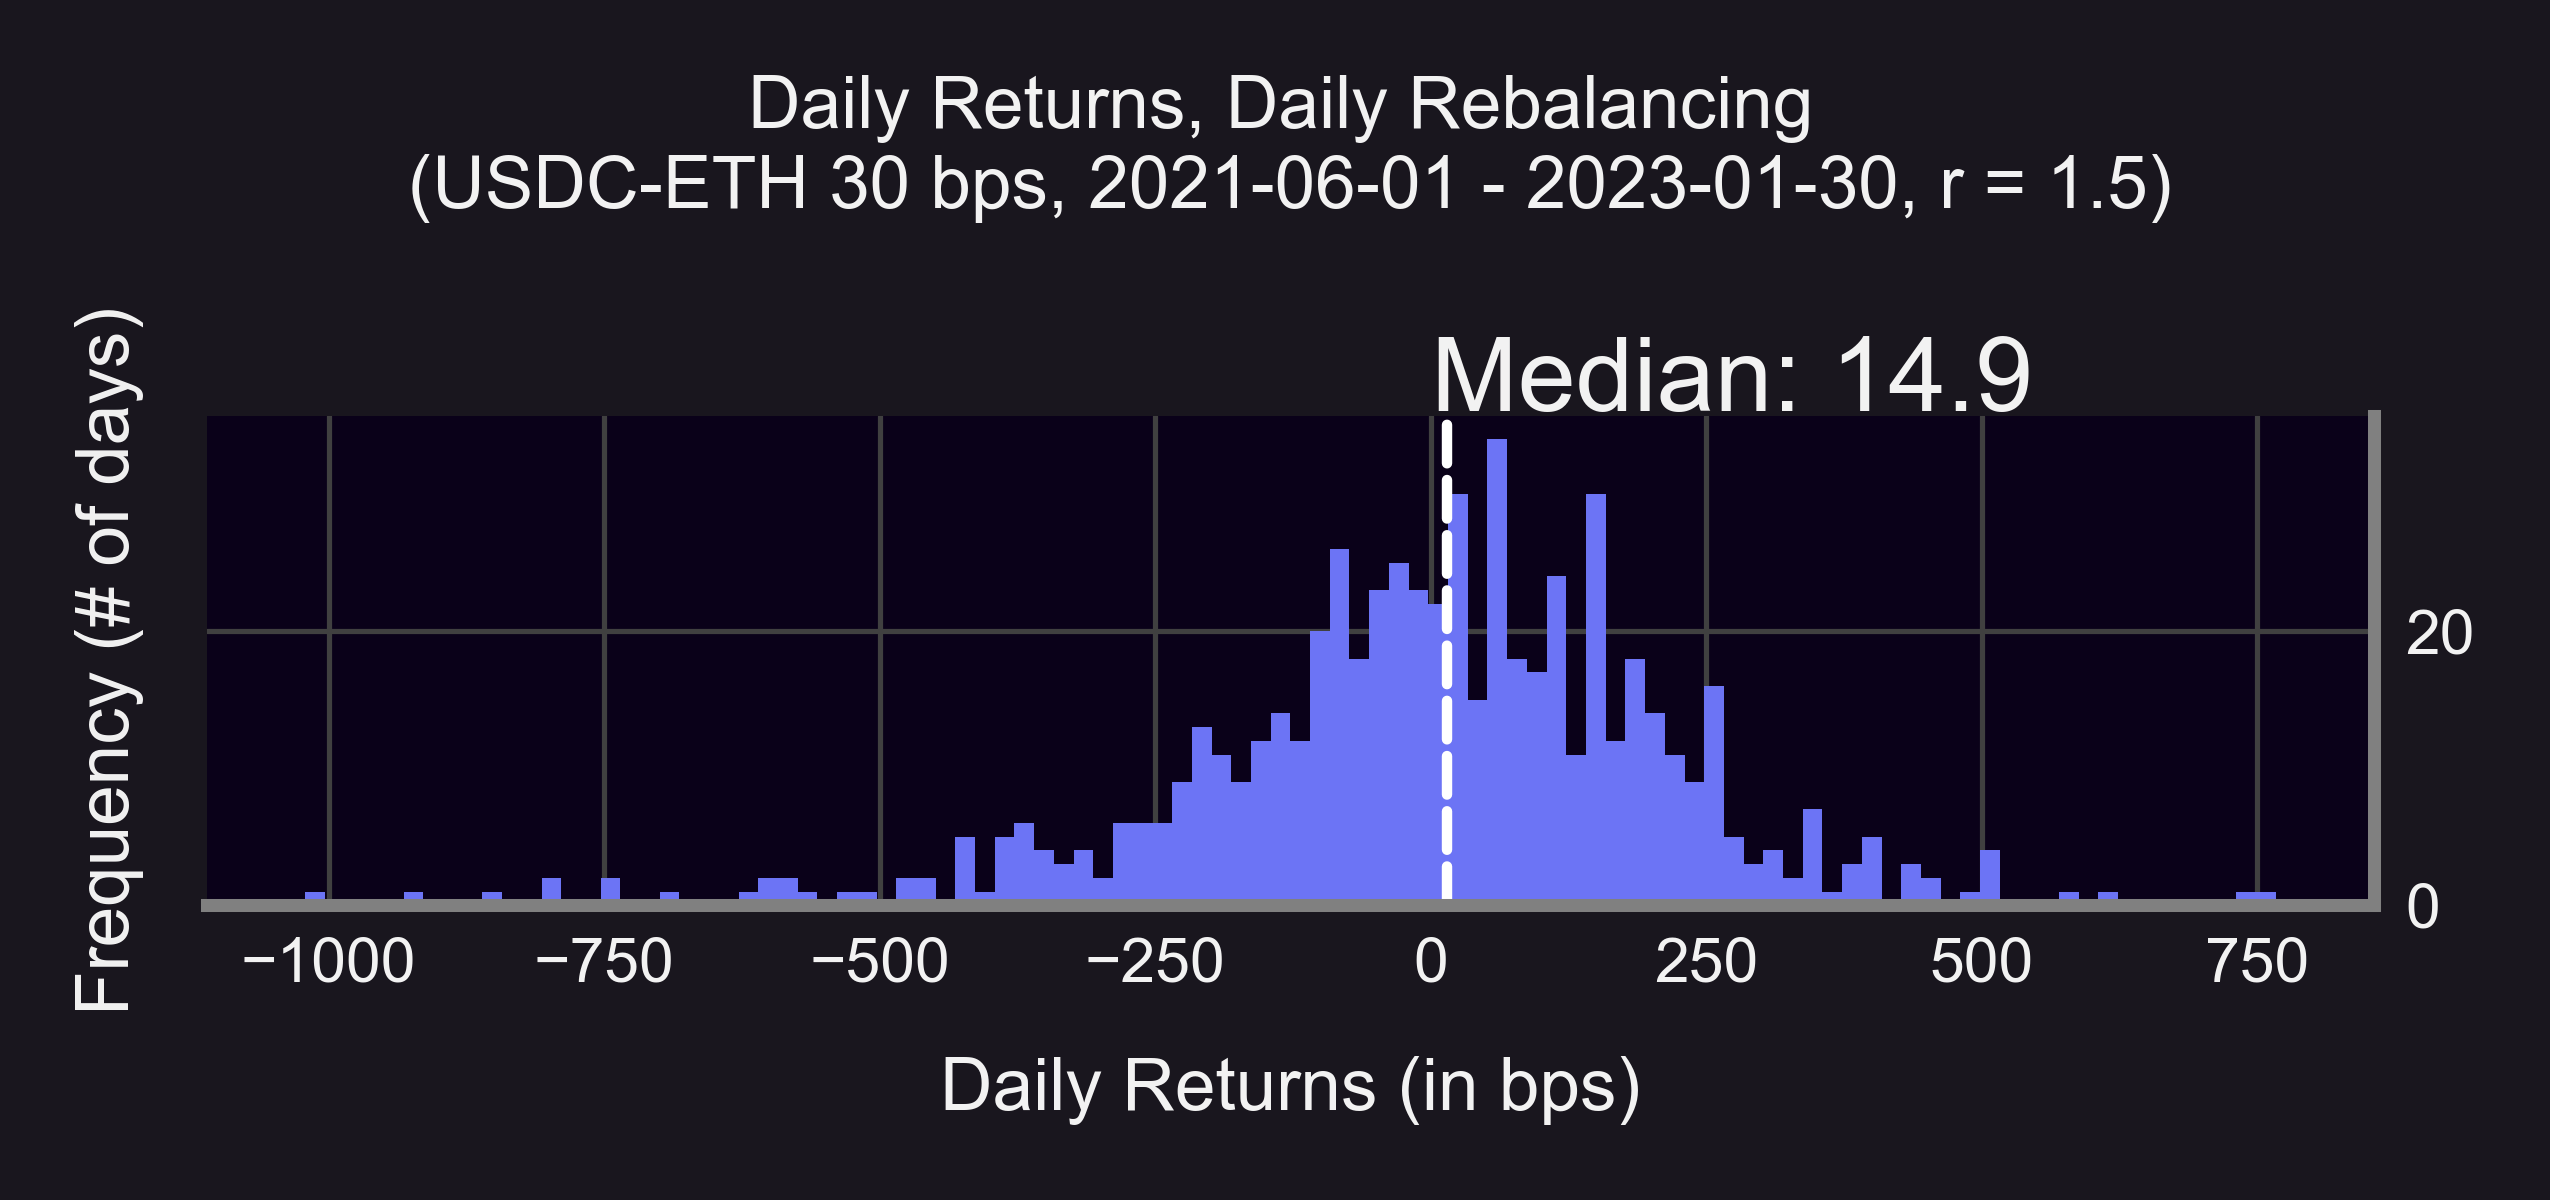

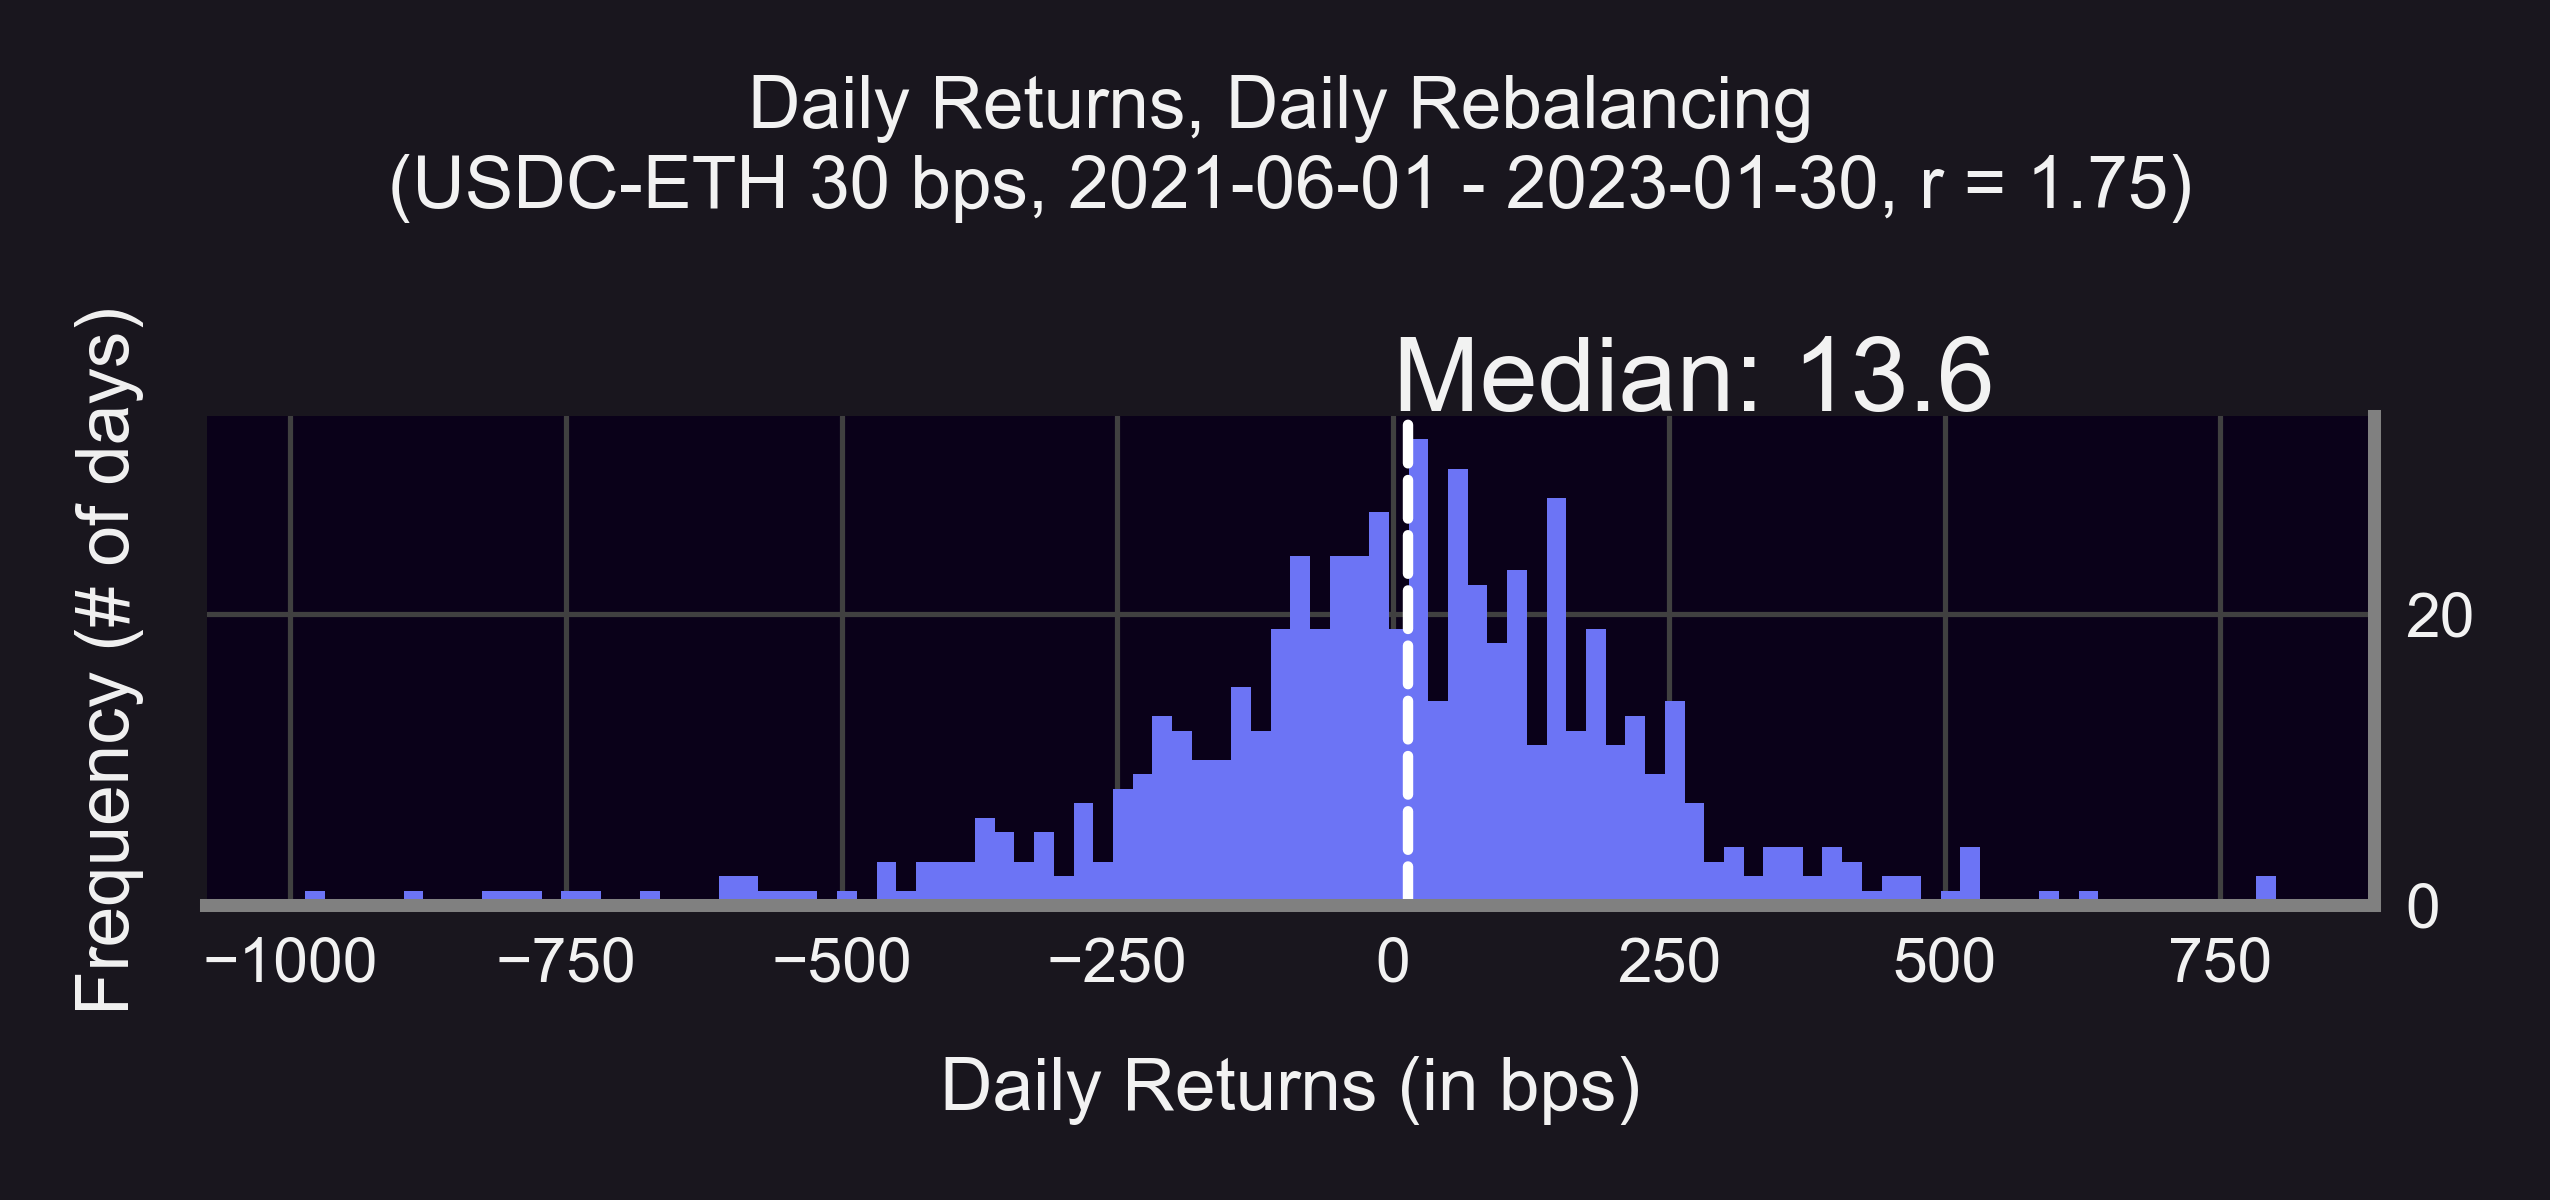

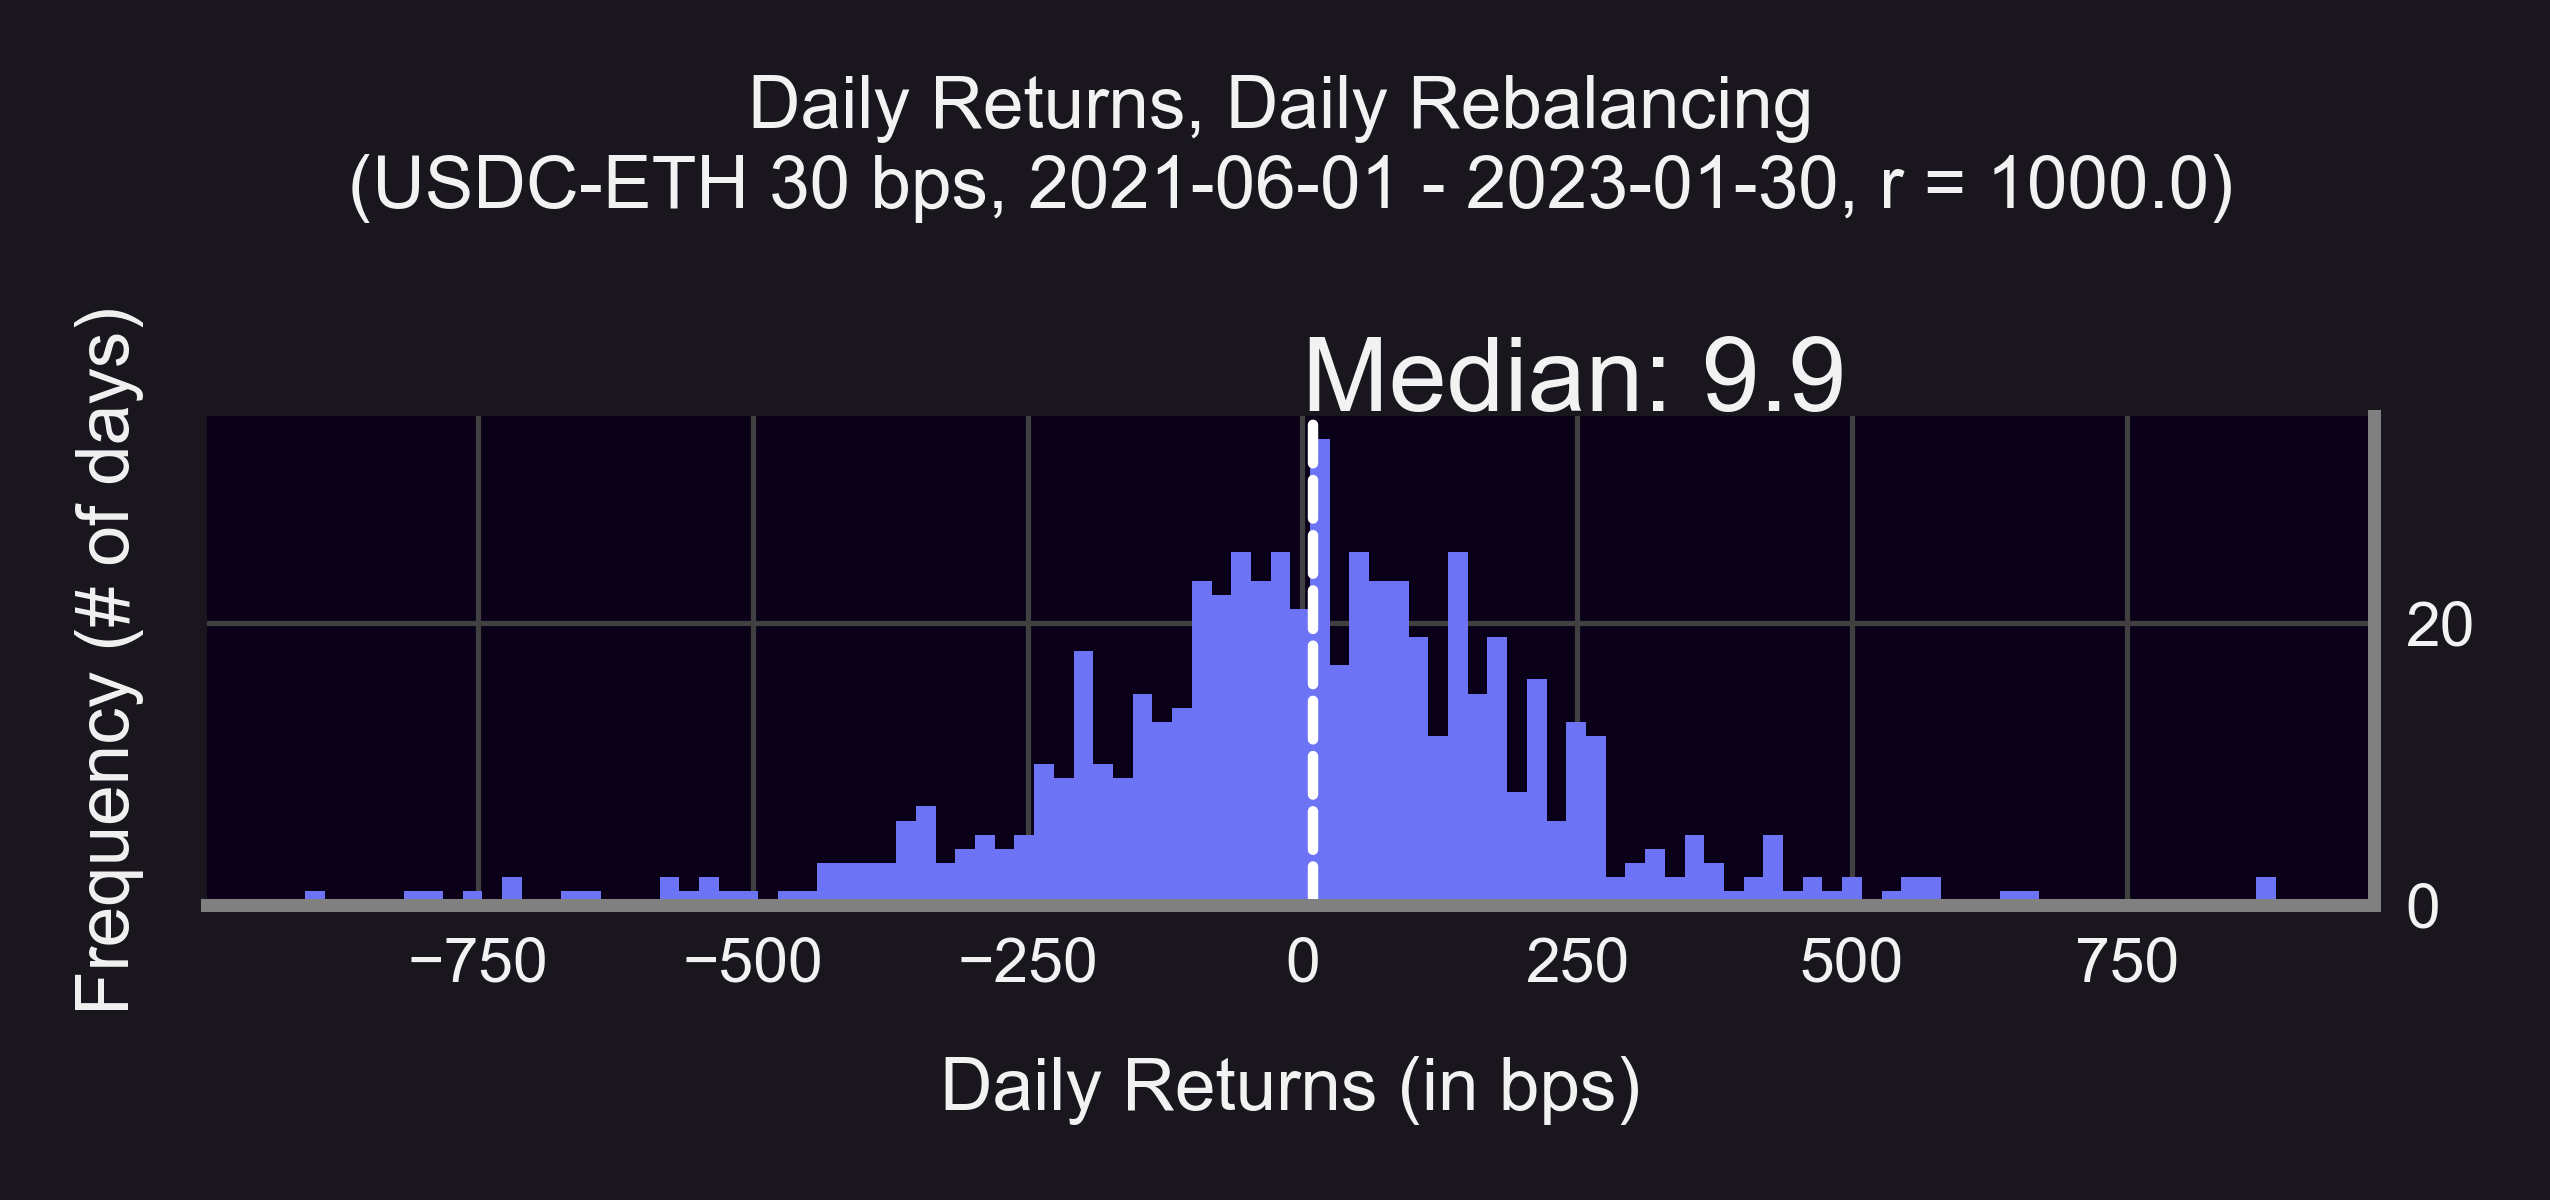

In [13]:
'''Plot histograms one-by-one'''
BPS = 10_000
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          # Plot daily rebalancing strategy
          plot_hist(s = (strat.daily_fees['our_fees'] + strat.daily_pos['pnl_perc']) * BPS,
               xlabel = 'Daily Returns (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Returns, Daily Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_rets_d",
               bins=100
          )
     if 'a' in period or 'w' in period:
          # Plot weekly rebalancing strategy
          plot_hist(s = (strat.weekly_fees['our_fees'] + strat.weekly_pos['pnl_perc']) * BPS,
               xlabel = 'Daily Returns (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Returns, Weekly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_rets_w",
               bins=100
          )
     if 'a' in period or 'm' in period:
          # Plot monthly rebalancing strategy
          plot_hist(s = (strat.monthly_fees['our_fees'] + strat.monthly_pos['pnl_perc']) * BPS,
               xlabel = 'Daily Returns (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Returns, Monthly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_rets_m",
               bins=100
          )

### Fees minus IL

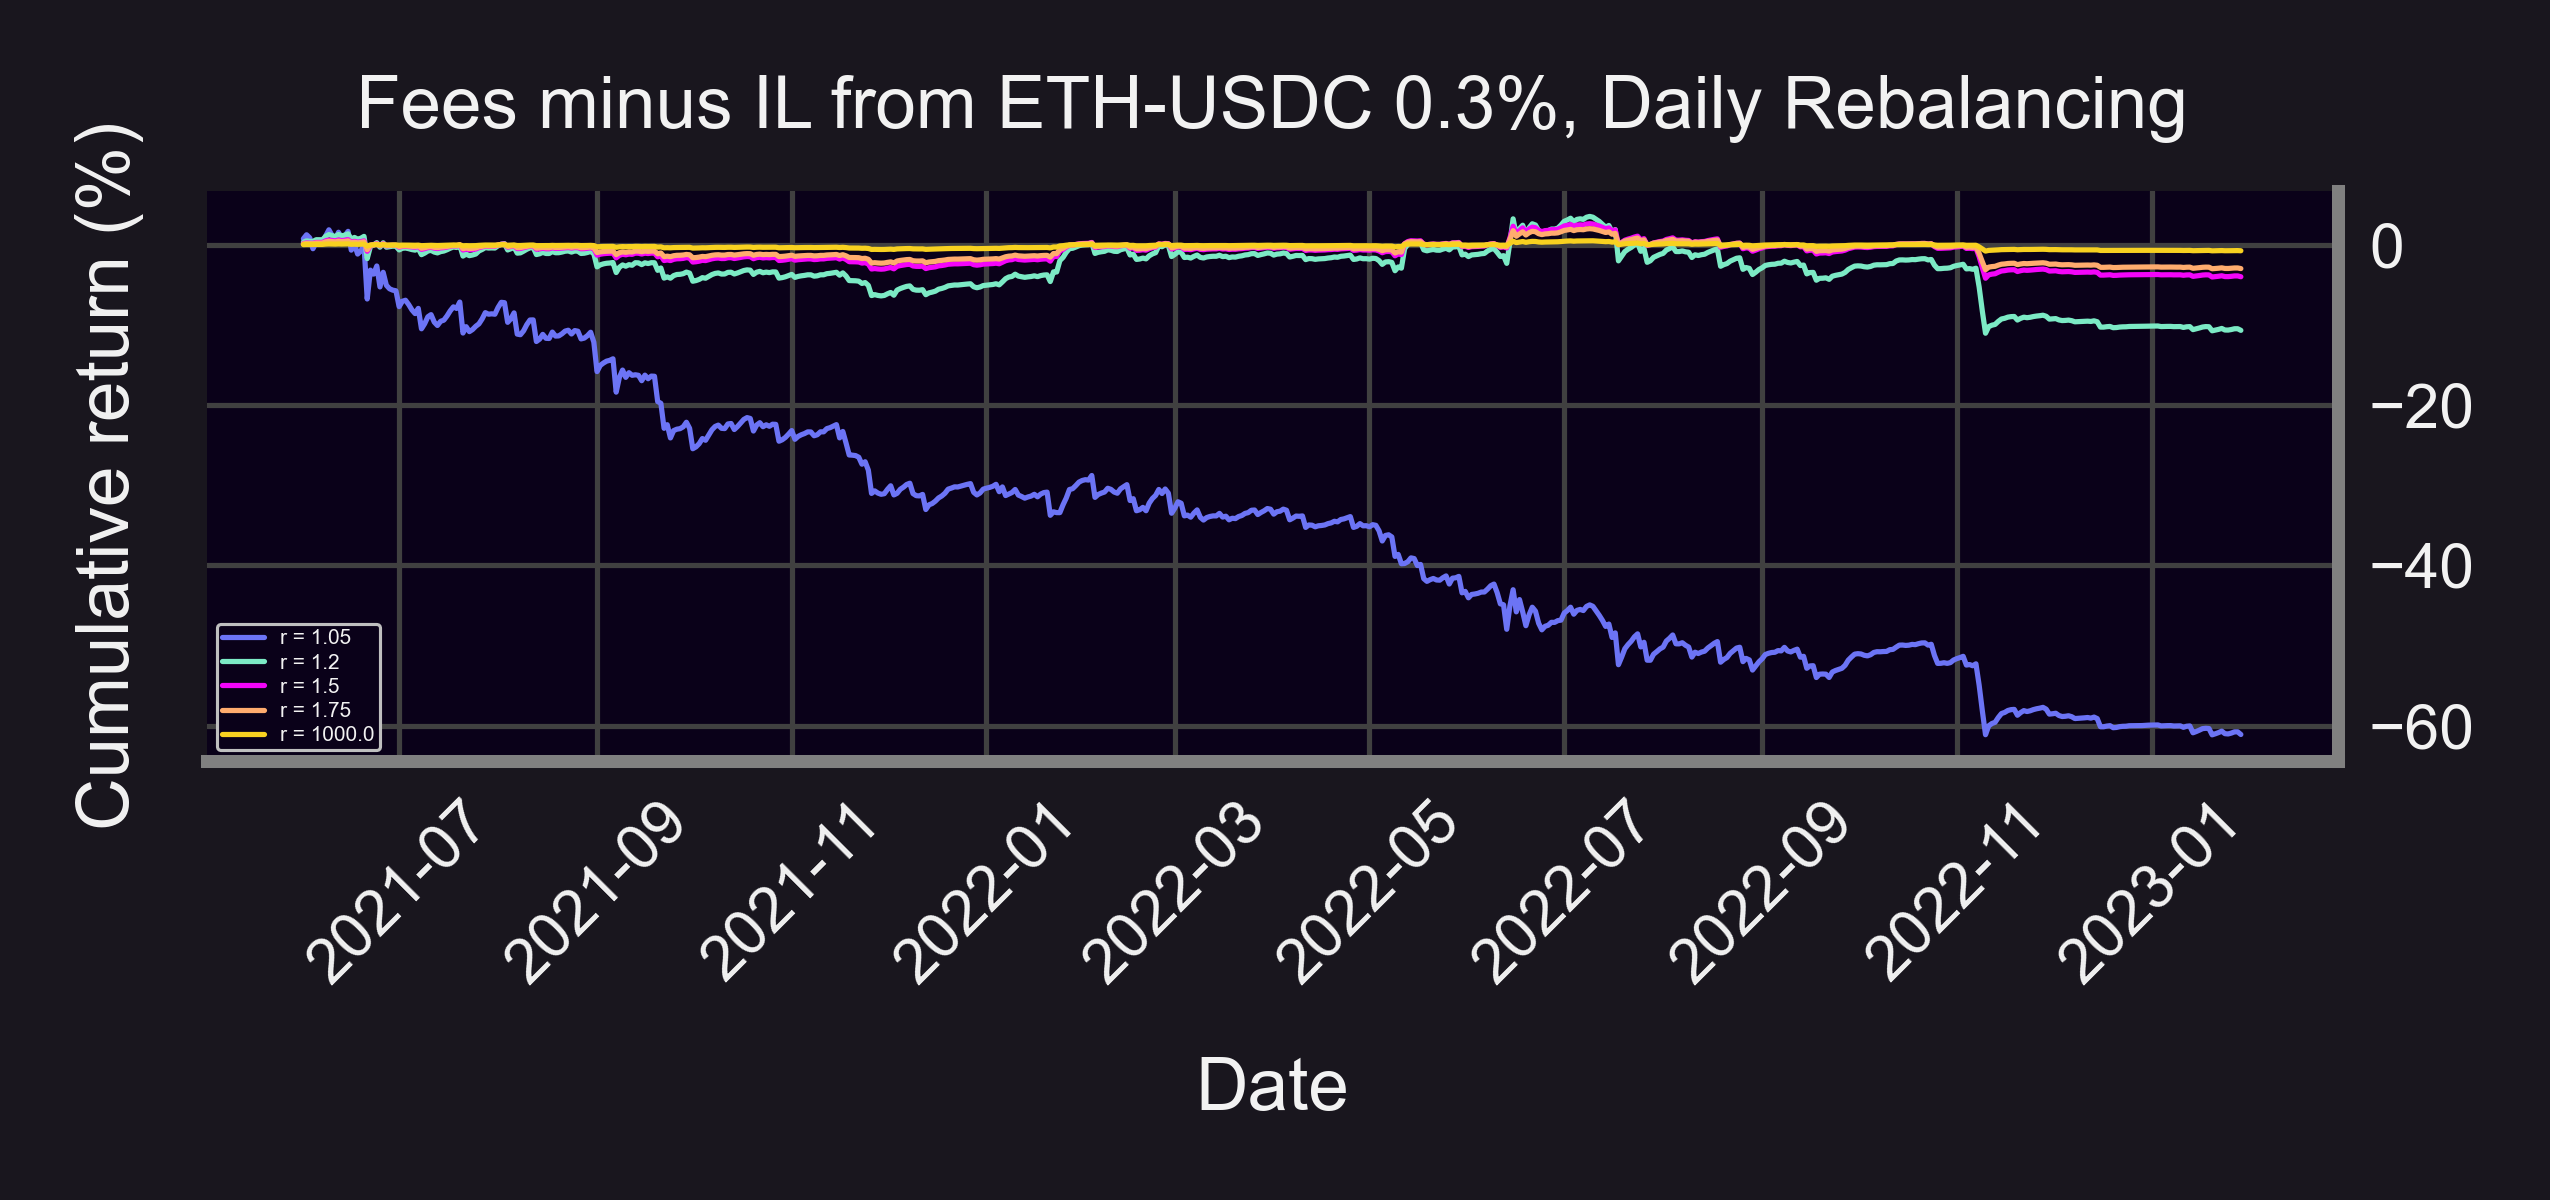

In [14]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'] + strat.daily_pos['IL_perc']
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'] + strat.weekly_pos['IL_perc']
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'] + strat.monthly_pos['IL_perc']

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees minus IL from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_IL_FULL"
)

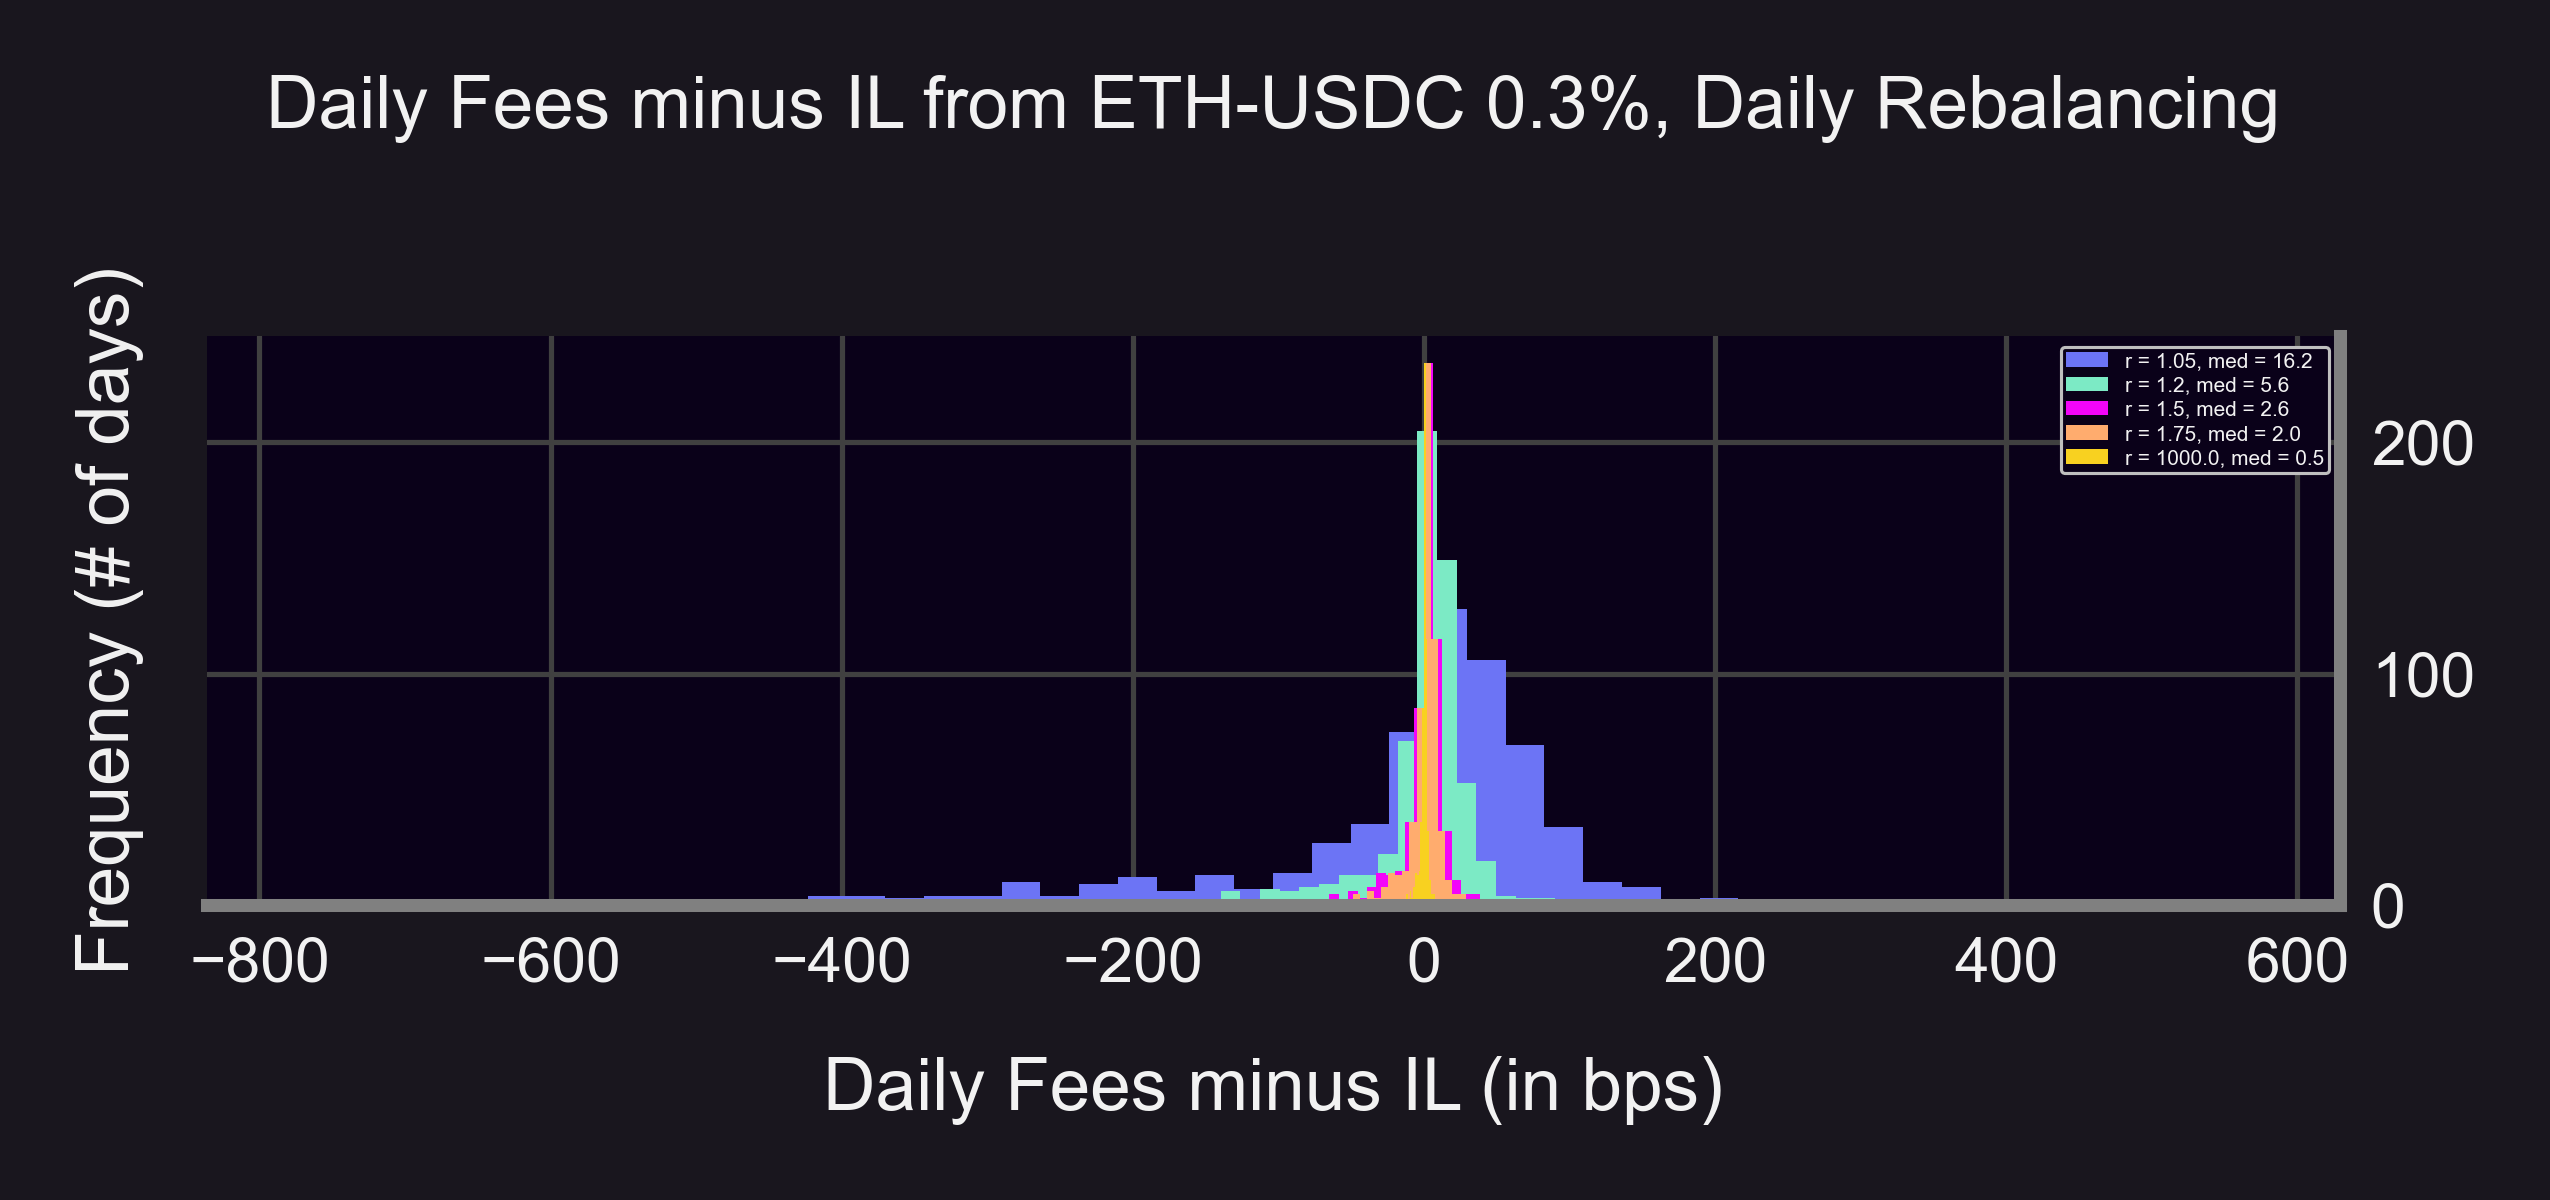

In [15]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'] + strat.daily_pos['IL_perc']) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'] + strat.weekly_pos['IL_perc']) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'] + strat.monthly_pos['IL_perc']) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees minus IL (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees minus IL from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_IL_FULL",
          bins = 50,
)

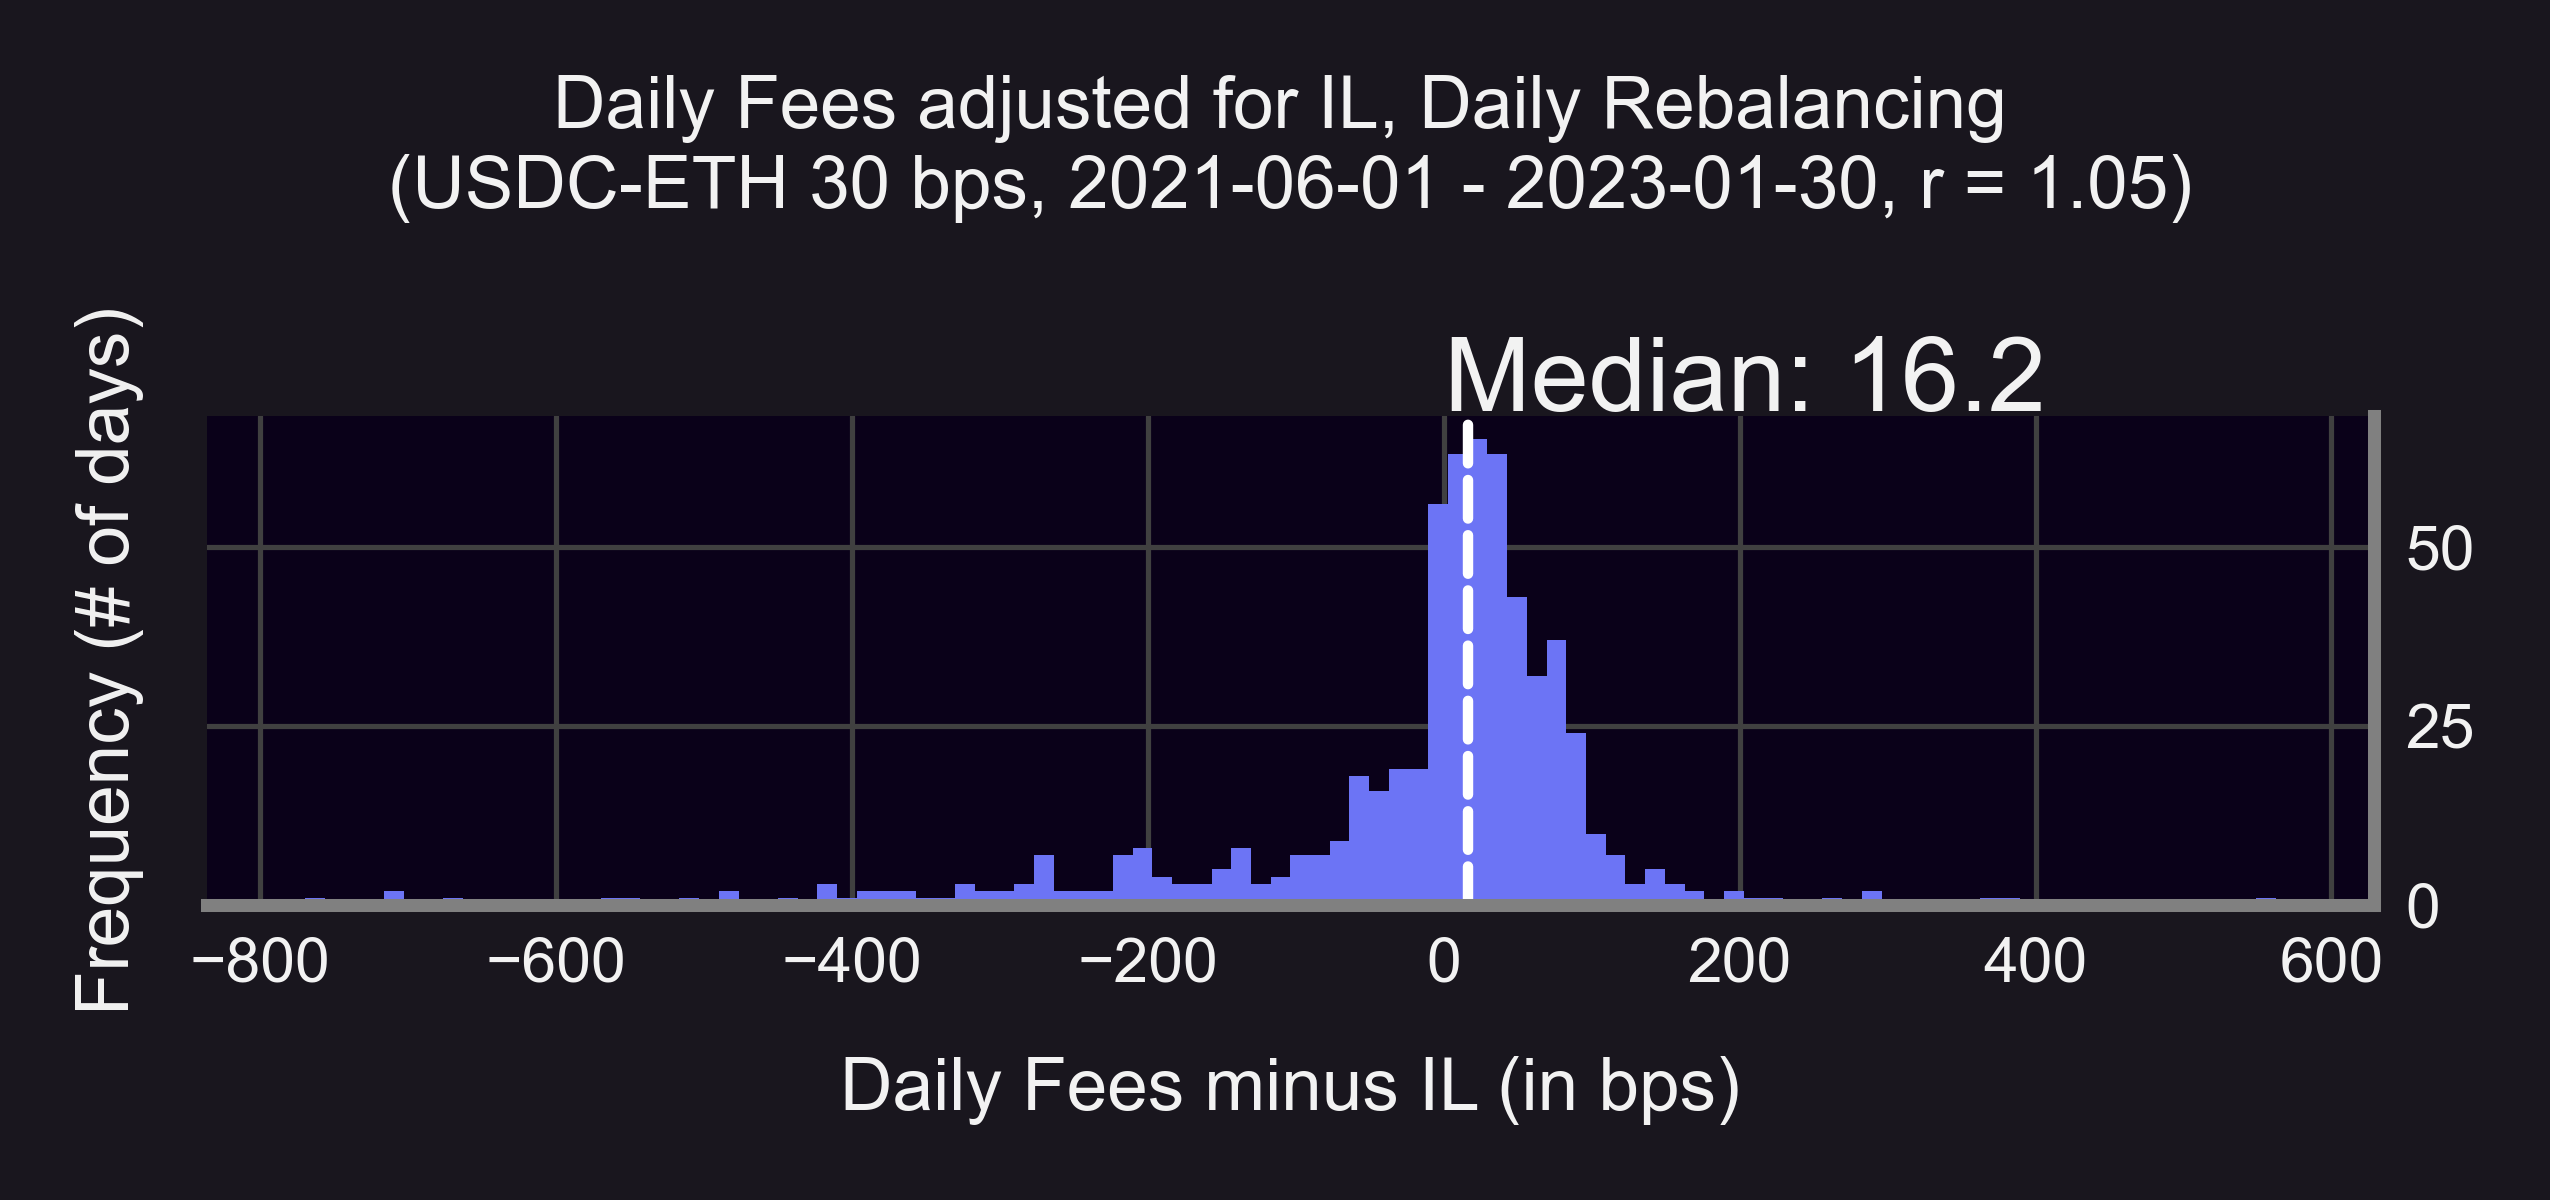

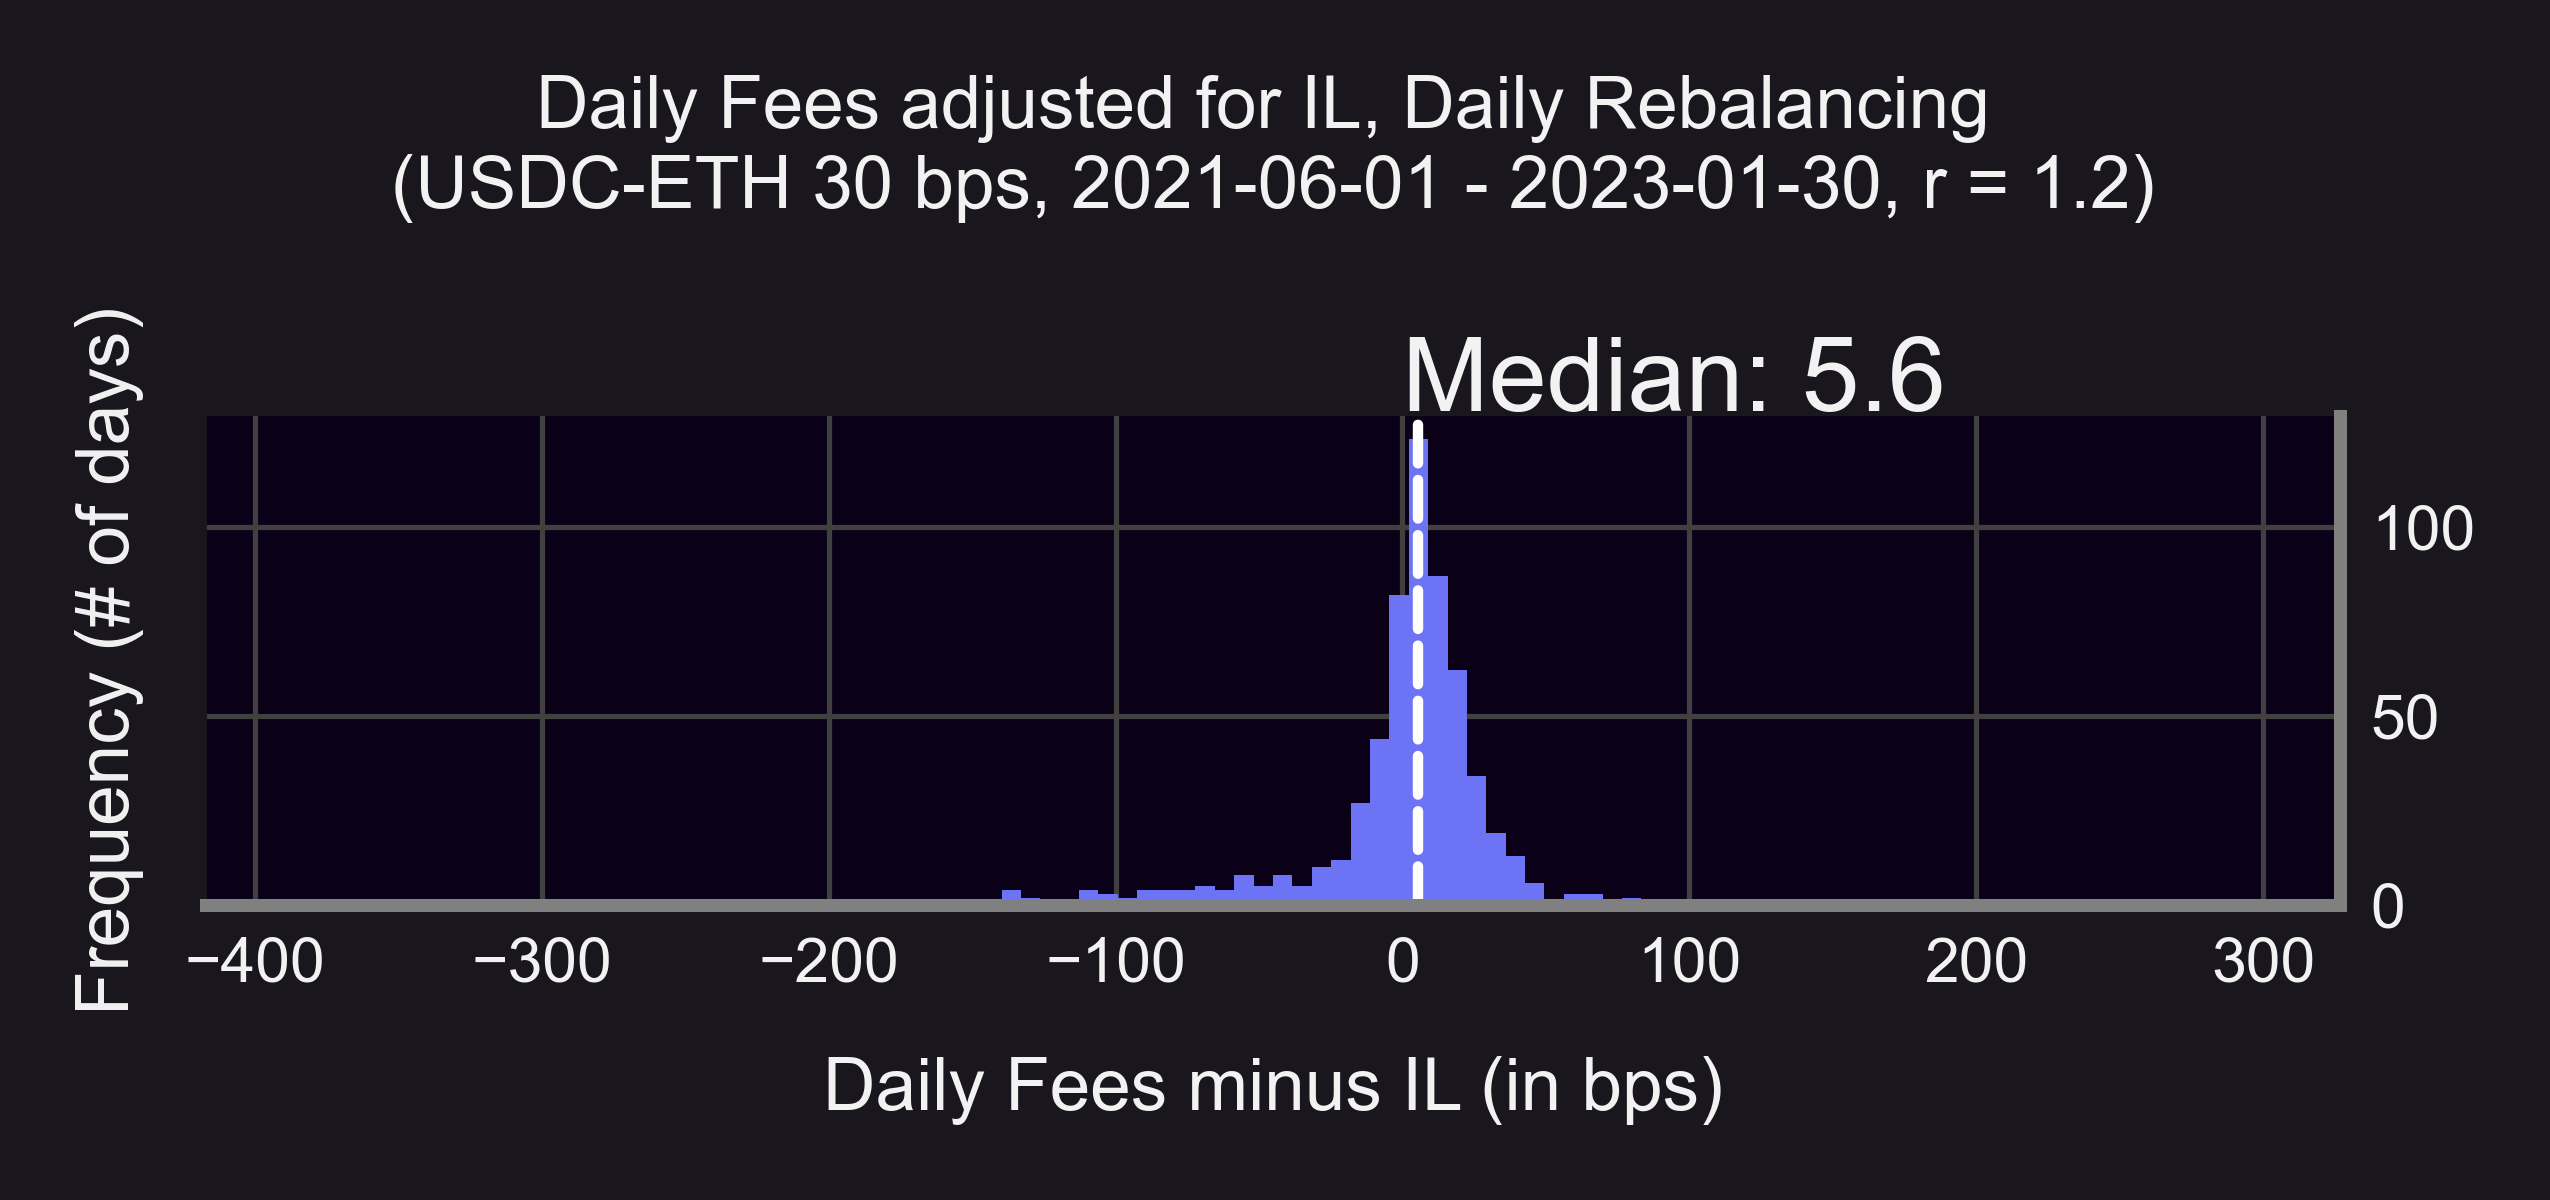

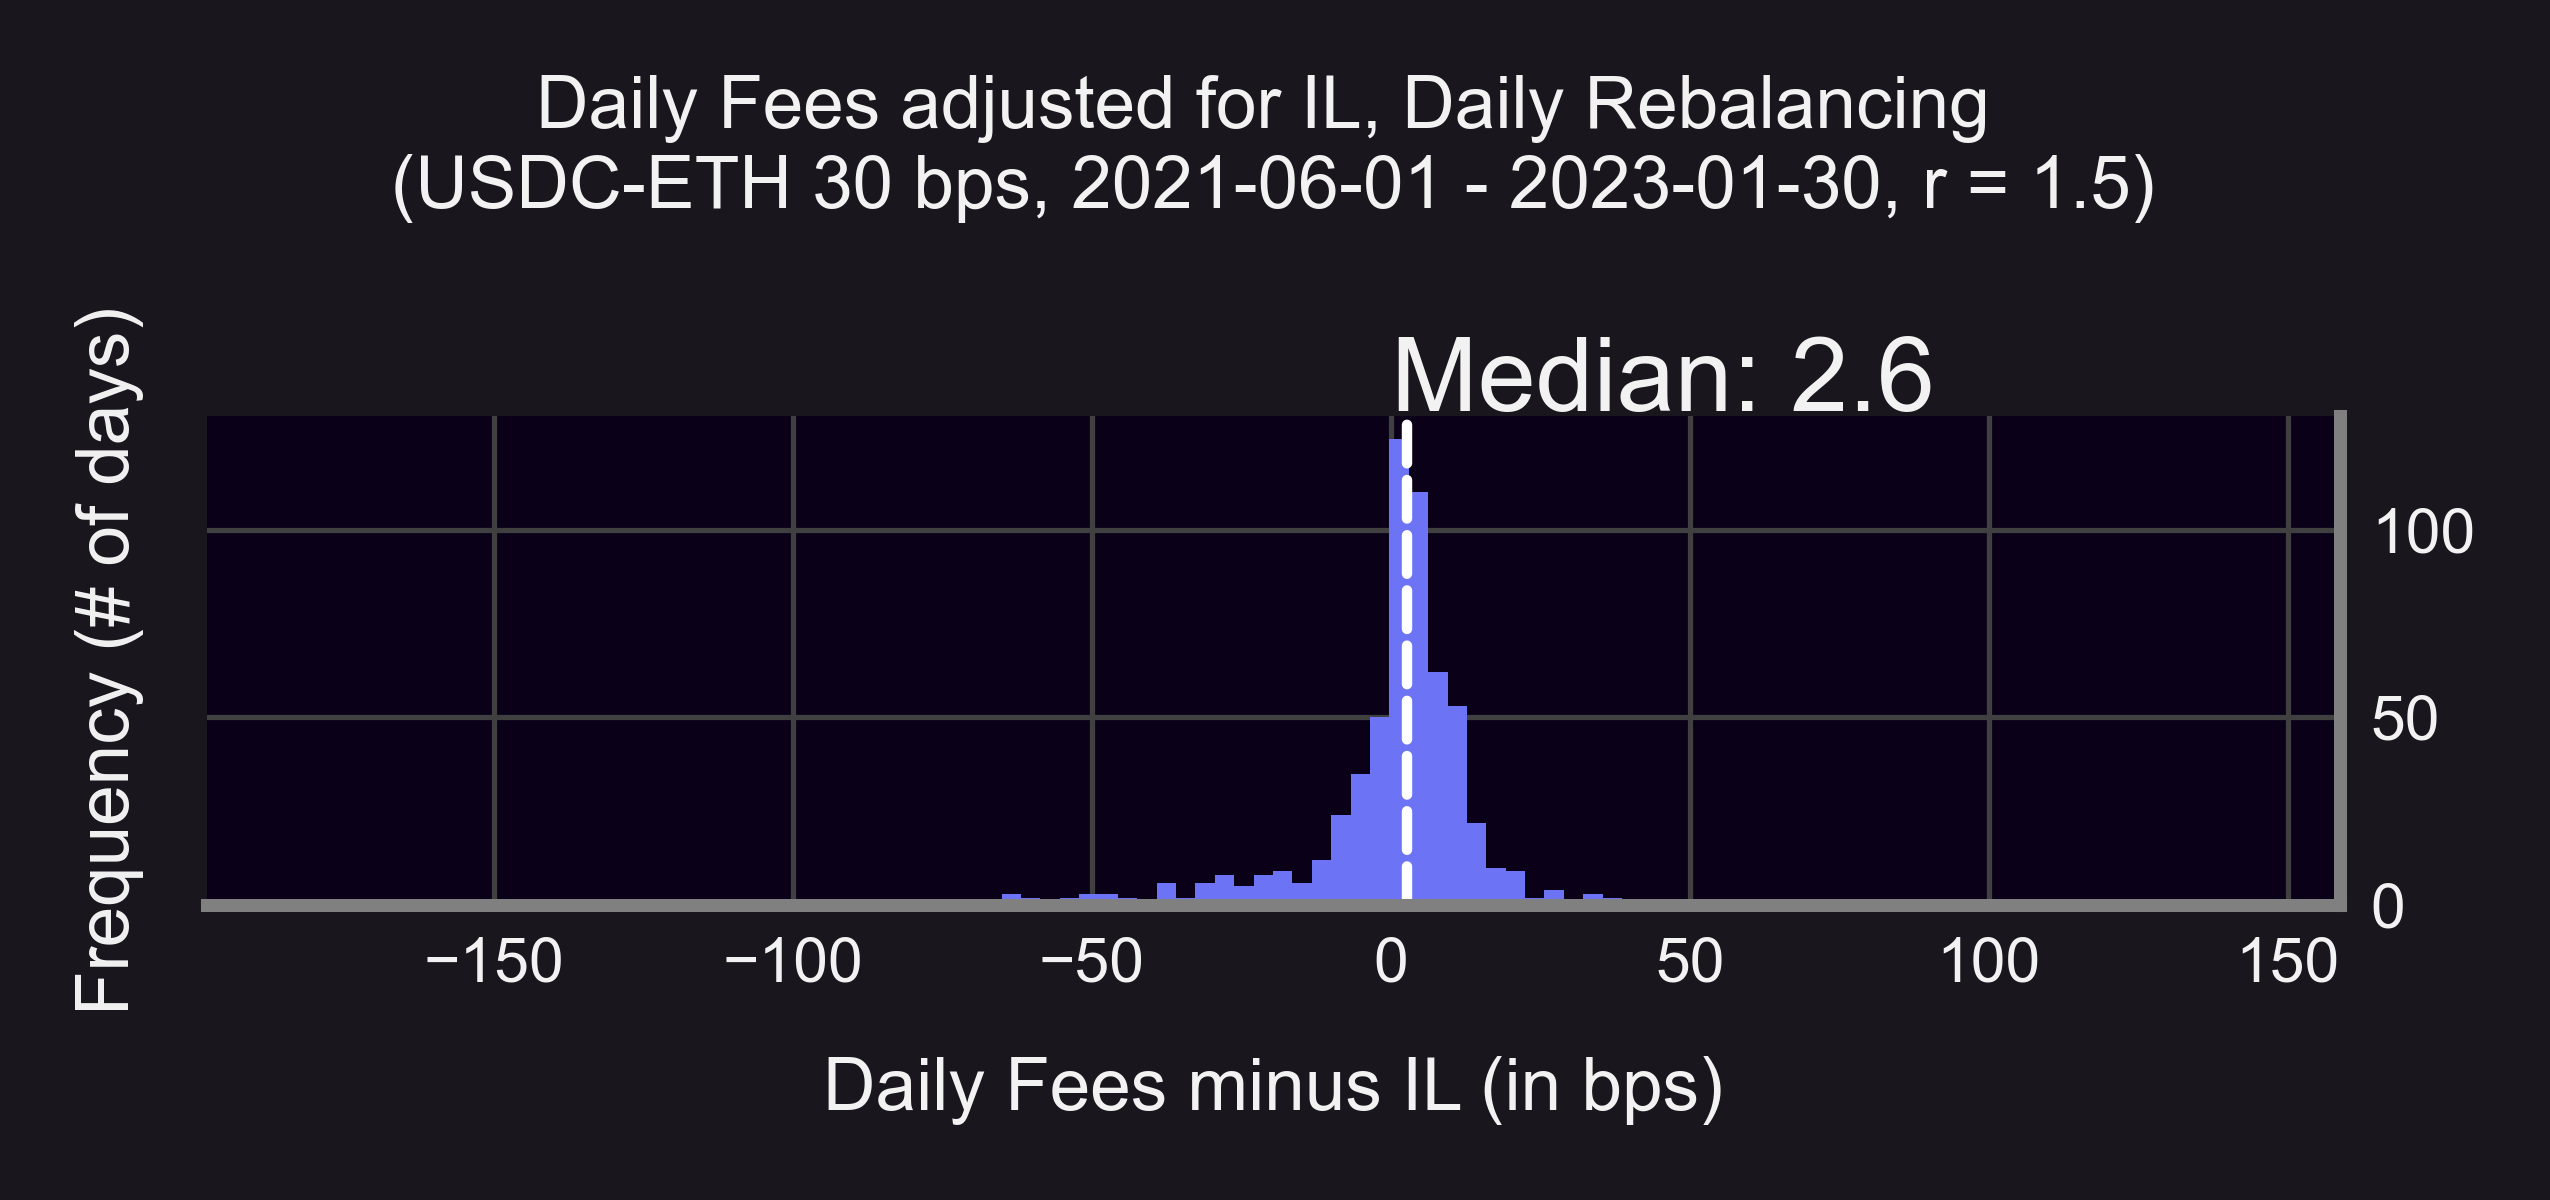

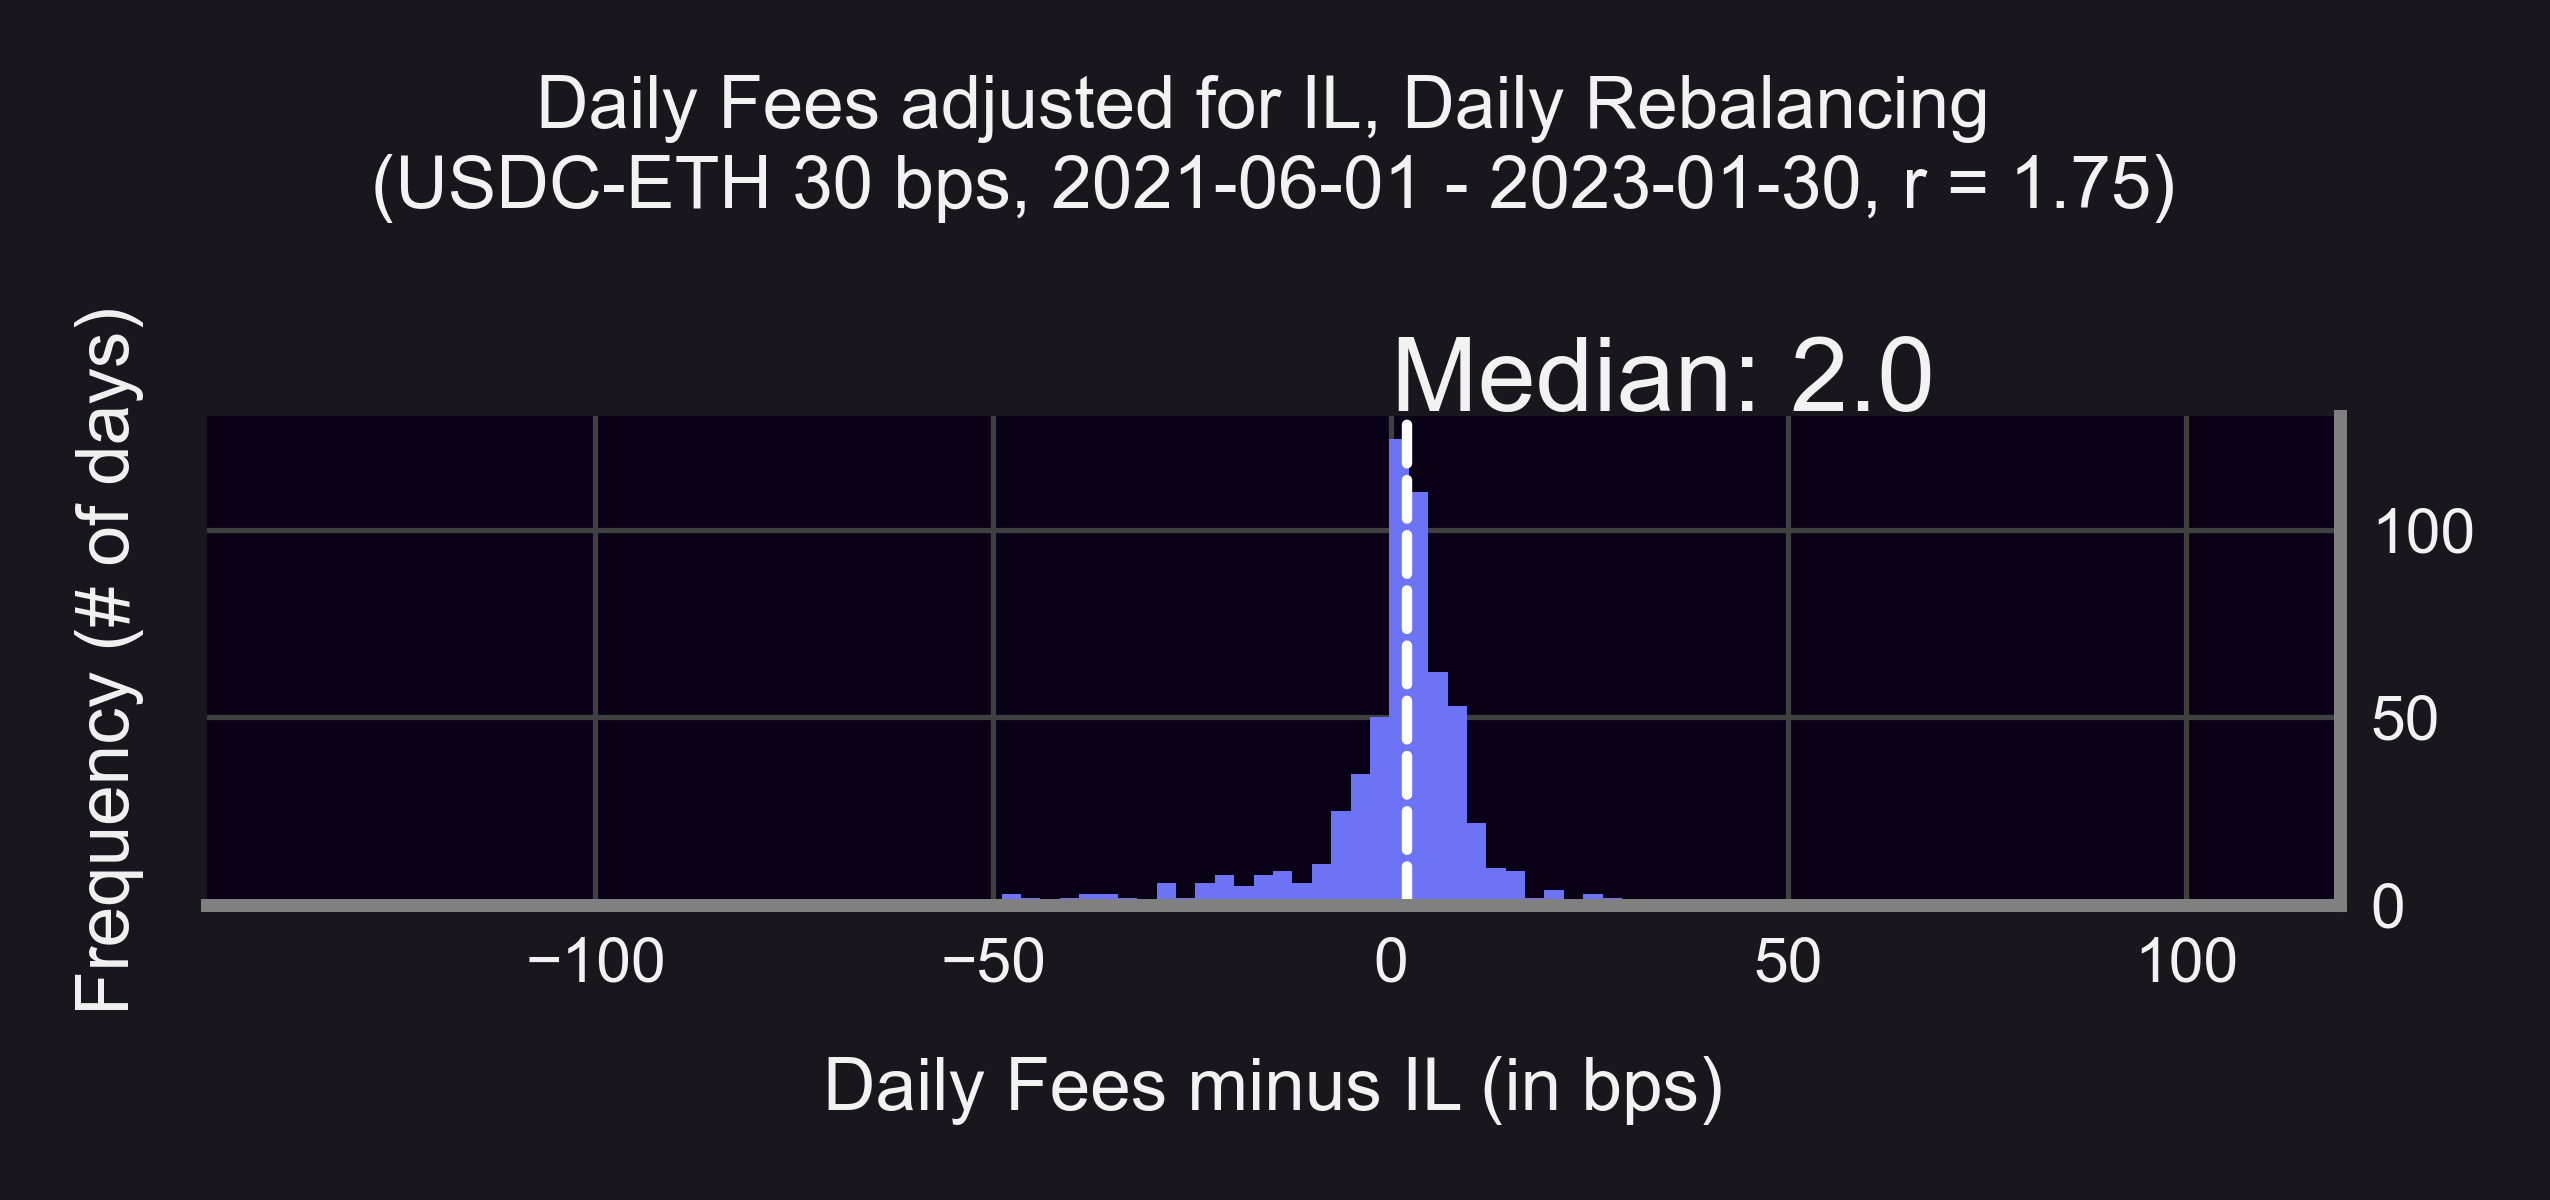

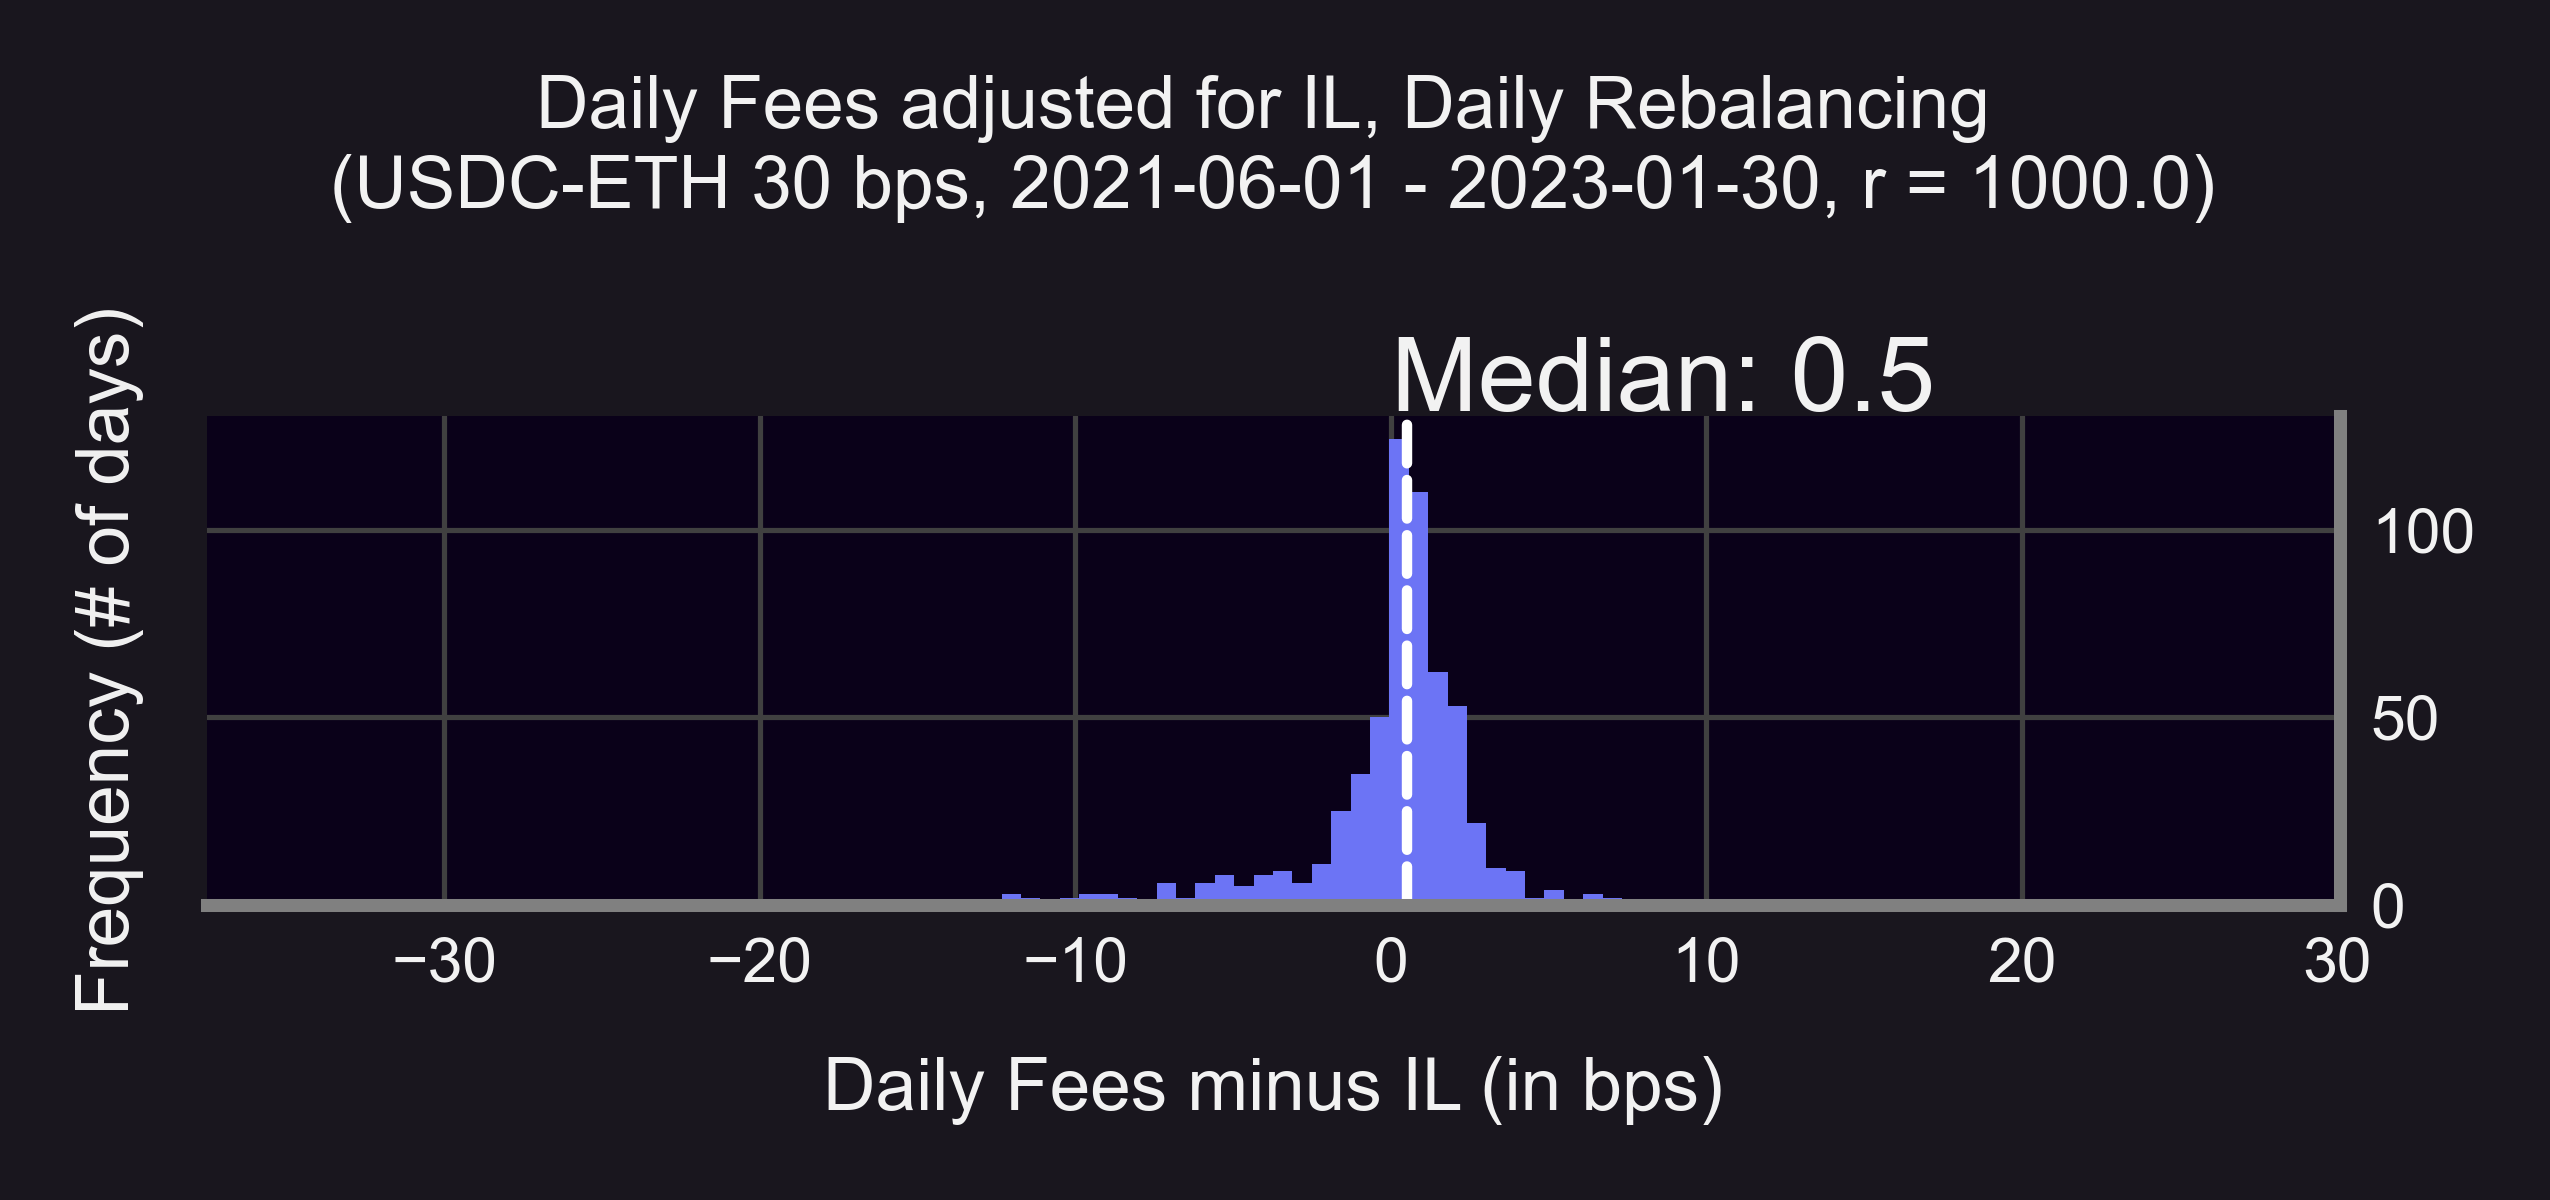

In [16]:
'''Plot histograms one-by-one'''
BPS = 10_000
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          # Plot daily rebalancing strategy
          plot_hist(s = (strat.daily_fees['our_fees'] + strat.daily_pos['IL_perc']) * 10_000,
               xlabel = 'Daily Fees minus IL (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees adjusted for IL, Daily Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_IL_d",
               bins=100
          )
     if 'a' in period or 'w' in period:
          # Plot weekly rebalancing strategy
          plot_hist(s = (strat.weekly_fees['our_fees'] + strat.weekly_pos['IL_perc']) * 10_000,
               xlabel = 'Daily Fees minus IL (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees adjusted for IL, Weekly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_IL_w",
               bins=100
          )
     if 'a' in period or 'm' in period:
          # Plot monthly rebalancing strategy
          plot_hist(s = (strat.monthly_fees['our_fees'] + strat.monthly_pos['IL_perc']) * 10_000,
               xlabel = 'Daily Fees minus IL (in bps)',
               ylabel = 'Frequency (# of days)',
               title = f'Daily Fees adjusted for IL, Monthly Rebalancing \n{strat_name(strat)}',
               dir = f"{strat.raw_dir}{strat_file(strat)}_hist_IL_m",
               bins=100
          )

# Strategy Stats

In [17]:
def strat_summary(s: pd.Series) -> pd.Series:
    """Get Summary Statistics (in bps) for Strategy"""
    BPS = 10_000
    sharpe = (s.mean() / s.std()) * (365 ** 0.5)
    avg_ret = s.mean()
    med_ret = s.median()
    max_loss = s.min()
    avg_loss = s[s < 0].mean()
    med_loss = s[s < 0].median()
    num_wins = len(s[s > 0])
    win_rate = num_wins / (len(s))
    avg_gain = s[s > 0].mean()
    med_gain = s[s > 0].median()
    max_gain = s.max()

    cum_rets = ((1 + s).cumprod() - 1) * 100
    max_cum_ret = max(cum_rets)
    min_cum_ret = min(cum_rets)
    cum_ret = cum_rets[-1]

    stats = {'Sharpe Ratio': sharpe,
             'Cum Ret': cum_ret,
             'Max Cum Ret': max_cum_ret,
             'Min Cum Ret': min_cum_ret,
             'Avg Ret': avg_ret * BPS,
             'Med Ret': med_ret * BPS,
             'Max Loss': max_loss * BPS,
             'Avg Loss': avg_loss * BPS,
             'Med Loss': med_loss * BPS,
             'Win Rate': win_rate,
             'Avg Gain': avg_gain * BPS,
             'Med Gain': med_gain * BPS,
             'Max Gain': max_gain * BPS
    }

    return pd.Series(stats)

In [40]:
# Daily Fees summary stats
print("FEES (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees']), columns=['Daily'])
    fees_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'])
    fees_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'])
    print(fees_stats, '\n')
    fees_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_fees.csv")

FEES (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                    Daily      Weekly     Monthly
Sharpe Ratio    24.934922   17.297279   10.097829
Cum Ret       5954.798264  712.437776  235.069457
Max Cum Ret   5954.798264  712.437776  235.069457
Min Cum Ret      1.084728    1.084728    1.084728
Avg Ret         67.851541   34.586839   19.978040
Med Ret         56.775435   25.106466    0.000000
Max Loss         2.125105    0.000000    0.000000
Avg Loss              NaN         NaN         NaN
Med Loss              NaN         NaN         NaN
Win Rate         1.000000    0.710526    0.376645
Avg Gain        67.851541   48.677773   53.042131
Med Gain        56.775435   41.083845   42.708141
Max Gain       563.471208  259.655539  379.420273 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly     Monthly
Sharpe Ratio   15.492406   20.052197   18.172719
Cum Ret       403.011131  281.067483  137.799704
Max Cum Ret   403.011131  281.06

In [41]:
# Daily Returns summary stats
print("DAILY RETURNS (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    ret_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'] + strat.daily_pos['pnl_perc']), columns=['Daily'])
    ret_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'] + strat.weekly_pos['pnl_perc'])
    ret_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'] + strat.monthly_pos['pnl_perc'])
    print(ret_stats, '\n')
    ret_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_rets.csv")

DAILY RETURNS (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                    Daily       Weekly      Monthly
Sharpe Ratio    -0.980546    -0.655798    -0.627550
Cum Ret        -65.358442   -62.986114   -63.774738
Max Cum Ret      6.364089     6.426038    27.716248
Min Cum Ret    -70.409492   -71.378002   -68.623585
Avg Ret        -13.699475   -11.035751   -10.979900
Med Ret         52.682449     6.900304     0.000000
Max Loss     -1591.202430 -1761.693653 -1761.693653
Avg Loss      -251.446014  -295.531897  -318.245559
Med Loss      -154.945712  -176.440895  -208.913511
Win Rate         0.618421     0.529605     0.422697
Avg Gain       132.995199   165.475897   219.209499
Med Gain       142.752011   107.626603   157.895322
Max Gain       585.423103  1803.272264  1803.272264 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                    Daily       Weekly      Monthly
Sharpe Ratio    -0.069225    -0.031711    -0.455934
Cum Ret        -18.919023   -23.629810

In [42]:
# Daily Fees minus IL summary stats
print("DAILY FEES - IL (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_IL_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'] + strat.daily_pos['IL_perc']), columns=['Daily'])
    fees_IL_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'] + strat.weekly_pos['IL_perc'])
    fees_IL_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'] + strat.monthly_pos['IL_perc'])
    print(fees_IL_stats, '\n')
    fees_IL_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_IL.csv")

DAILY FEES - IL (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                   Daily      Weekly     Monthly
Sharpe Ratio   -2.085710   -2.659755   -1.876303
Cum Ret       -61.107791  -57.056045  -34.357776
Max Cum Ret     1.879282    2.415711    1.973169
Min Cum Ret   -61.149392  -57.056045  -34.414042
Avg Ret       -14.609330  -13.417760   -6.685480
Med Ret        16.221169    0.000000    0.000000
Max Loss     -769.759208 -769.759208 -519.603914
Avg Loss     -130.934416 -112.483814 -105.527533
Med Loss      -68.014755  -51.711673  -45.899260
Win Rate        0.634868    0.453947    0.230263
Avg Gain       52.292663   34.019845   38.051277
Med Gain       38.536002   26.168858   26.262001
Max Gain      562.371277  259.156370  257.944301 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly     Monthly
Sharpe Ratio   -0.669323   -1.488602   -1.626897
Cum Ret       -10.670240  -17.928092  -14.254144
Max Cum Ret     3.548294    1.28813

# Subsample Analysis

In [21]:
# Split sample period into half (roughly corresponds to "bull" and "bear")
mid_idx = int(len(strat.daily_fees['our_fees'].index) / 2)

### Fees

Period 1 (first half)

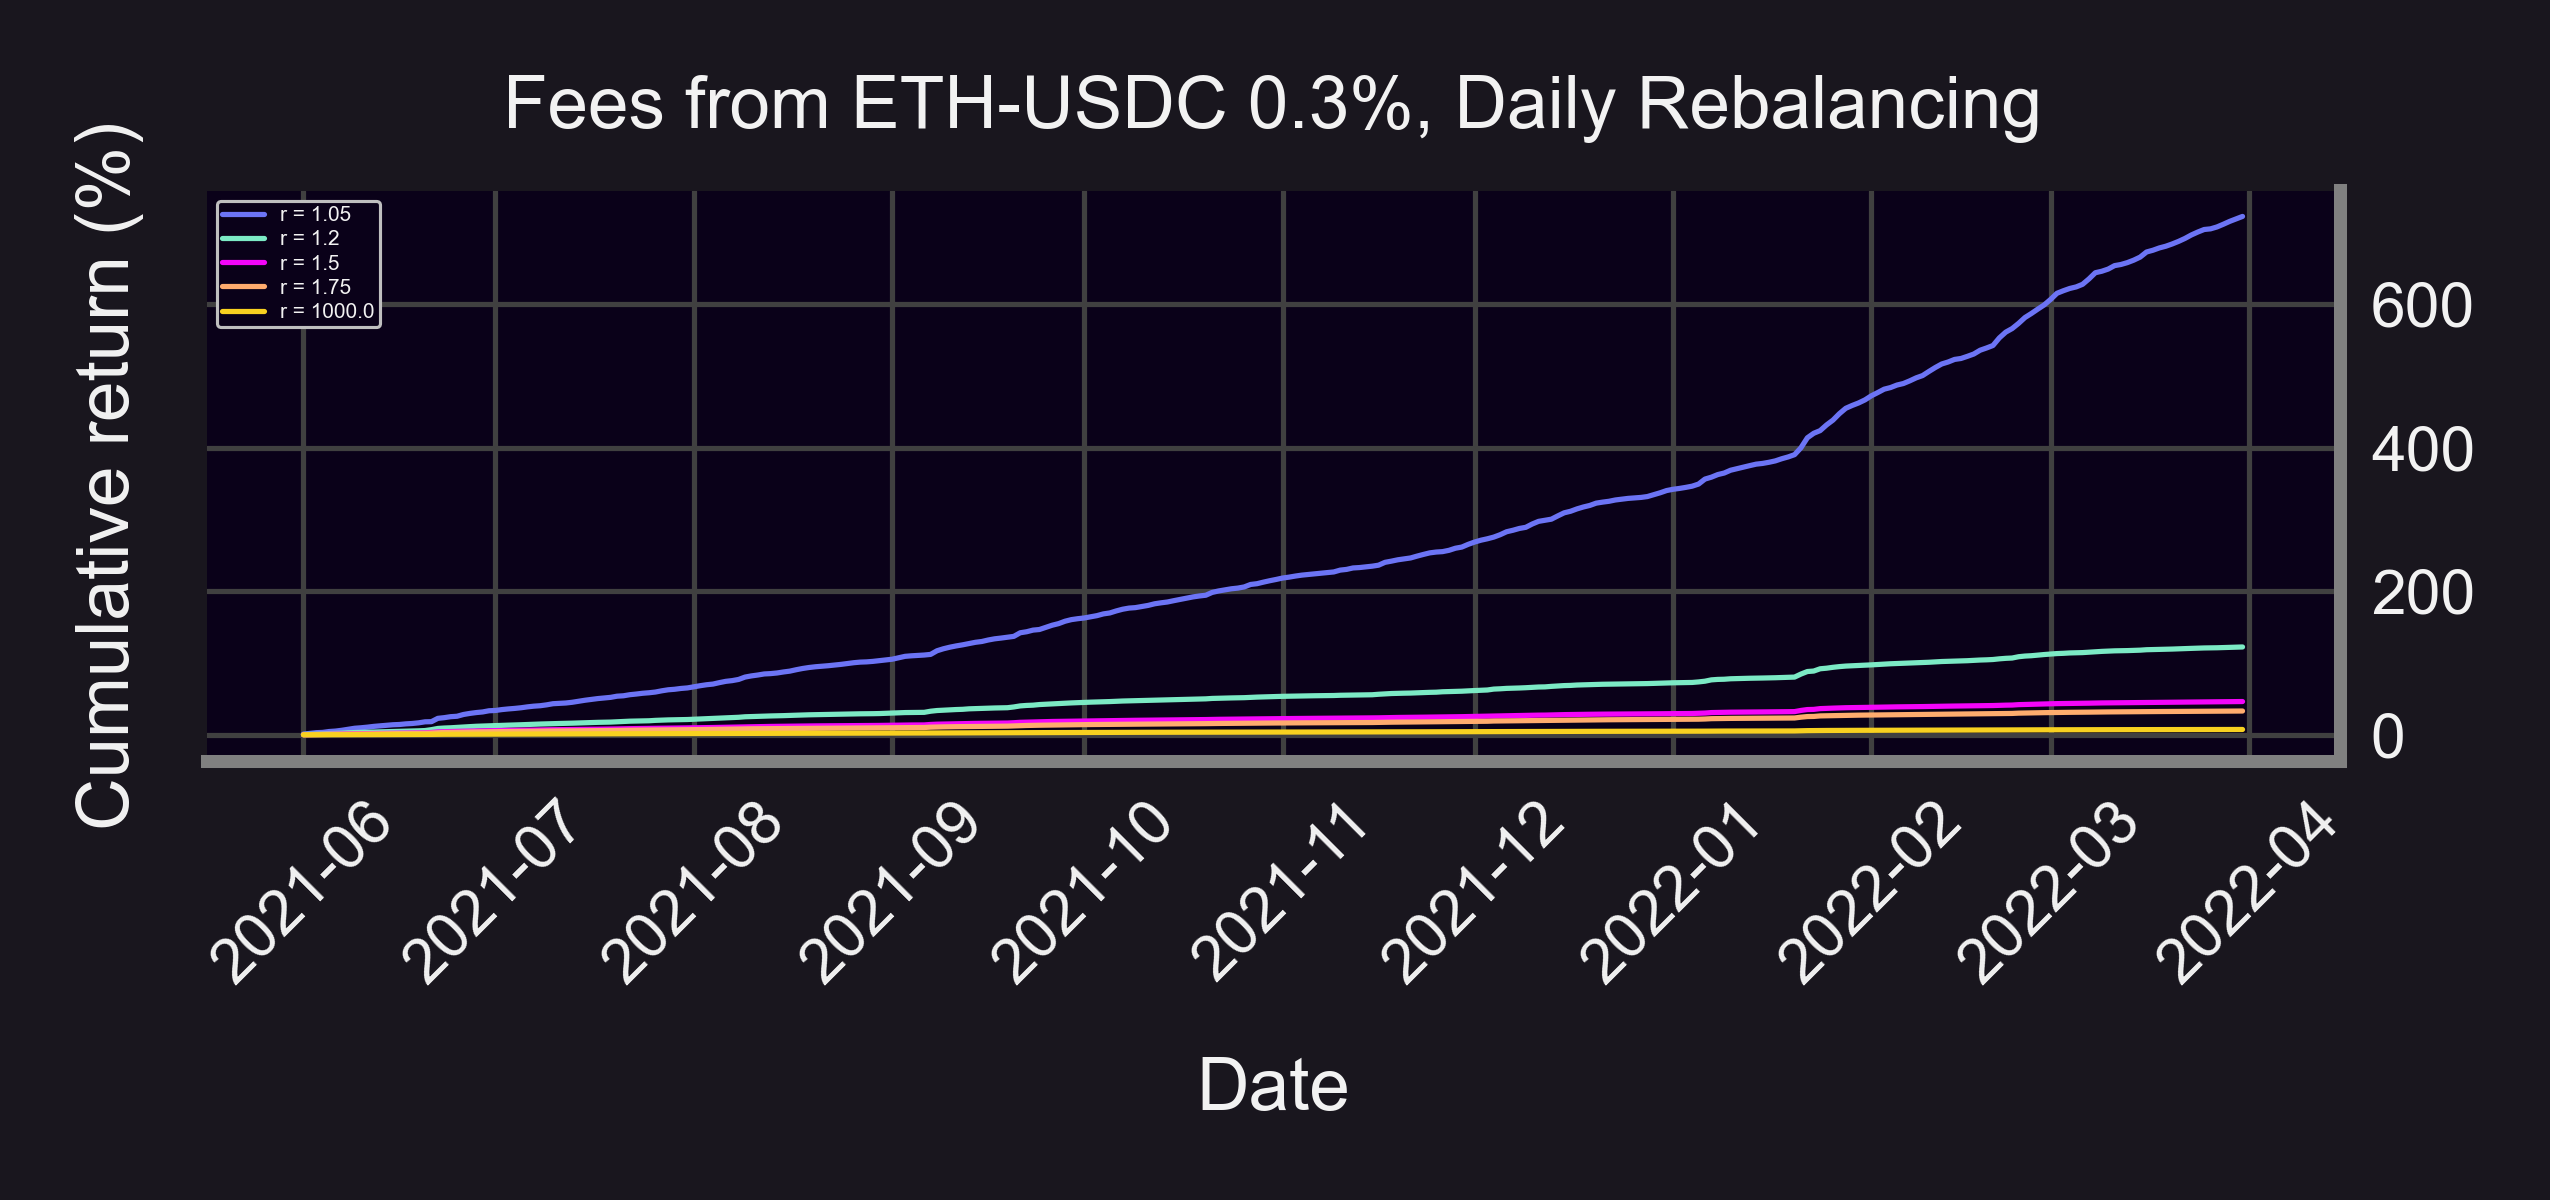

In [22]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][:mid_idx]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][:mid_idx]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][:mid_idx]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_fees_P1"
)

Period 2 (second half)

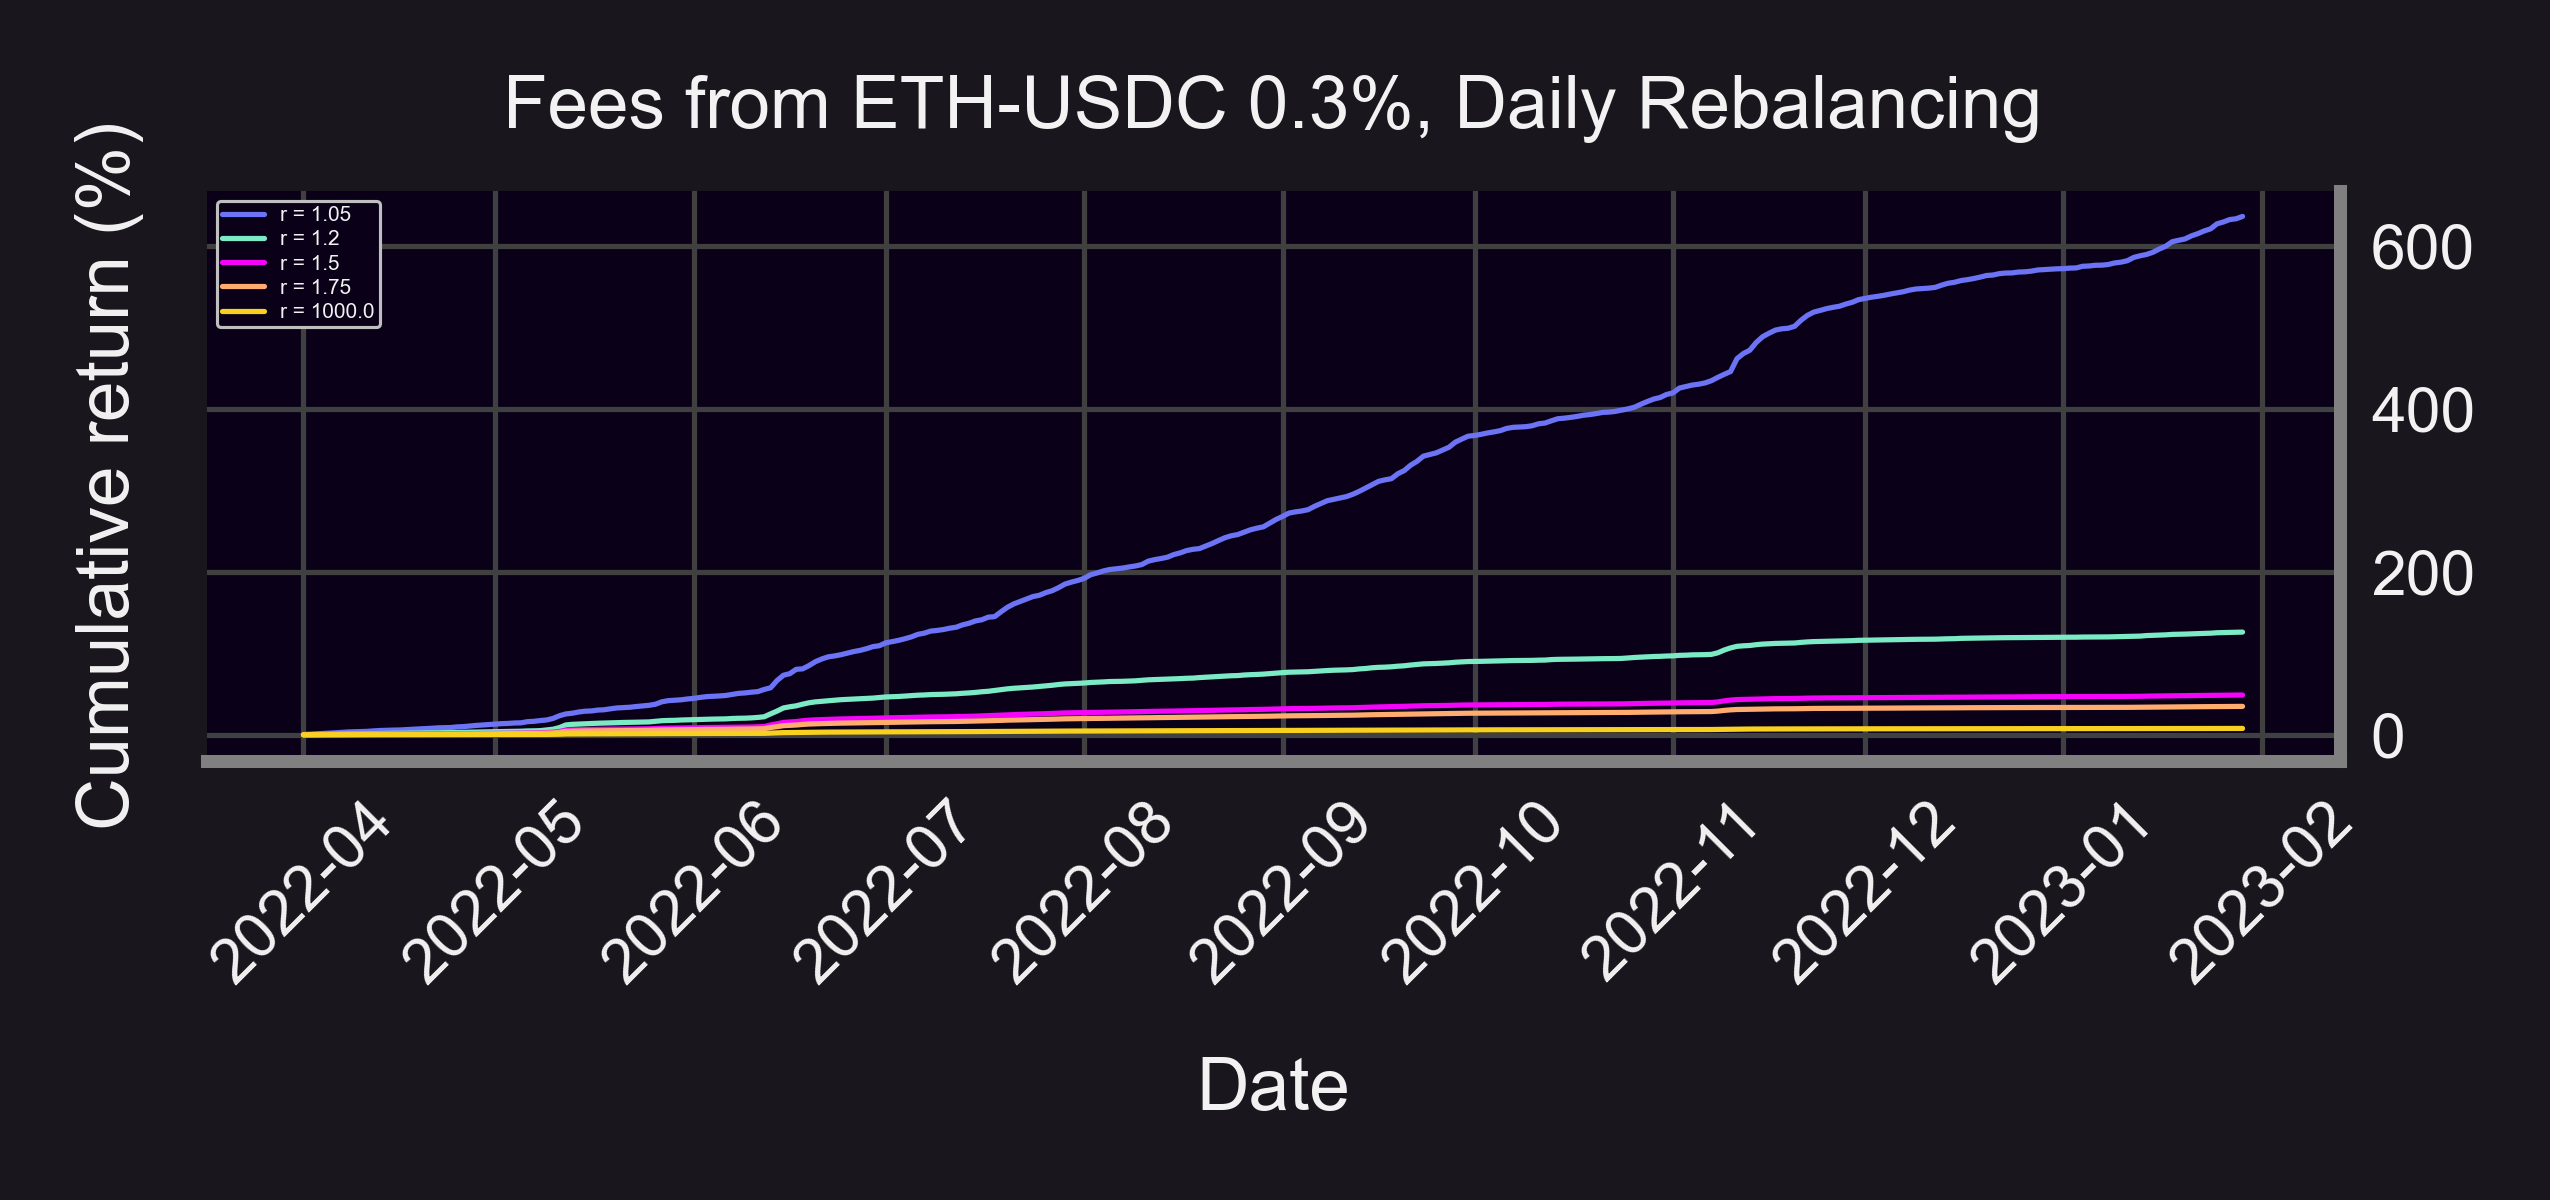

In [23]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][mid_idx:]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][mid_idx:]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][mid_idx:]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_fees_P2"
)

Period 1

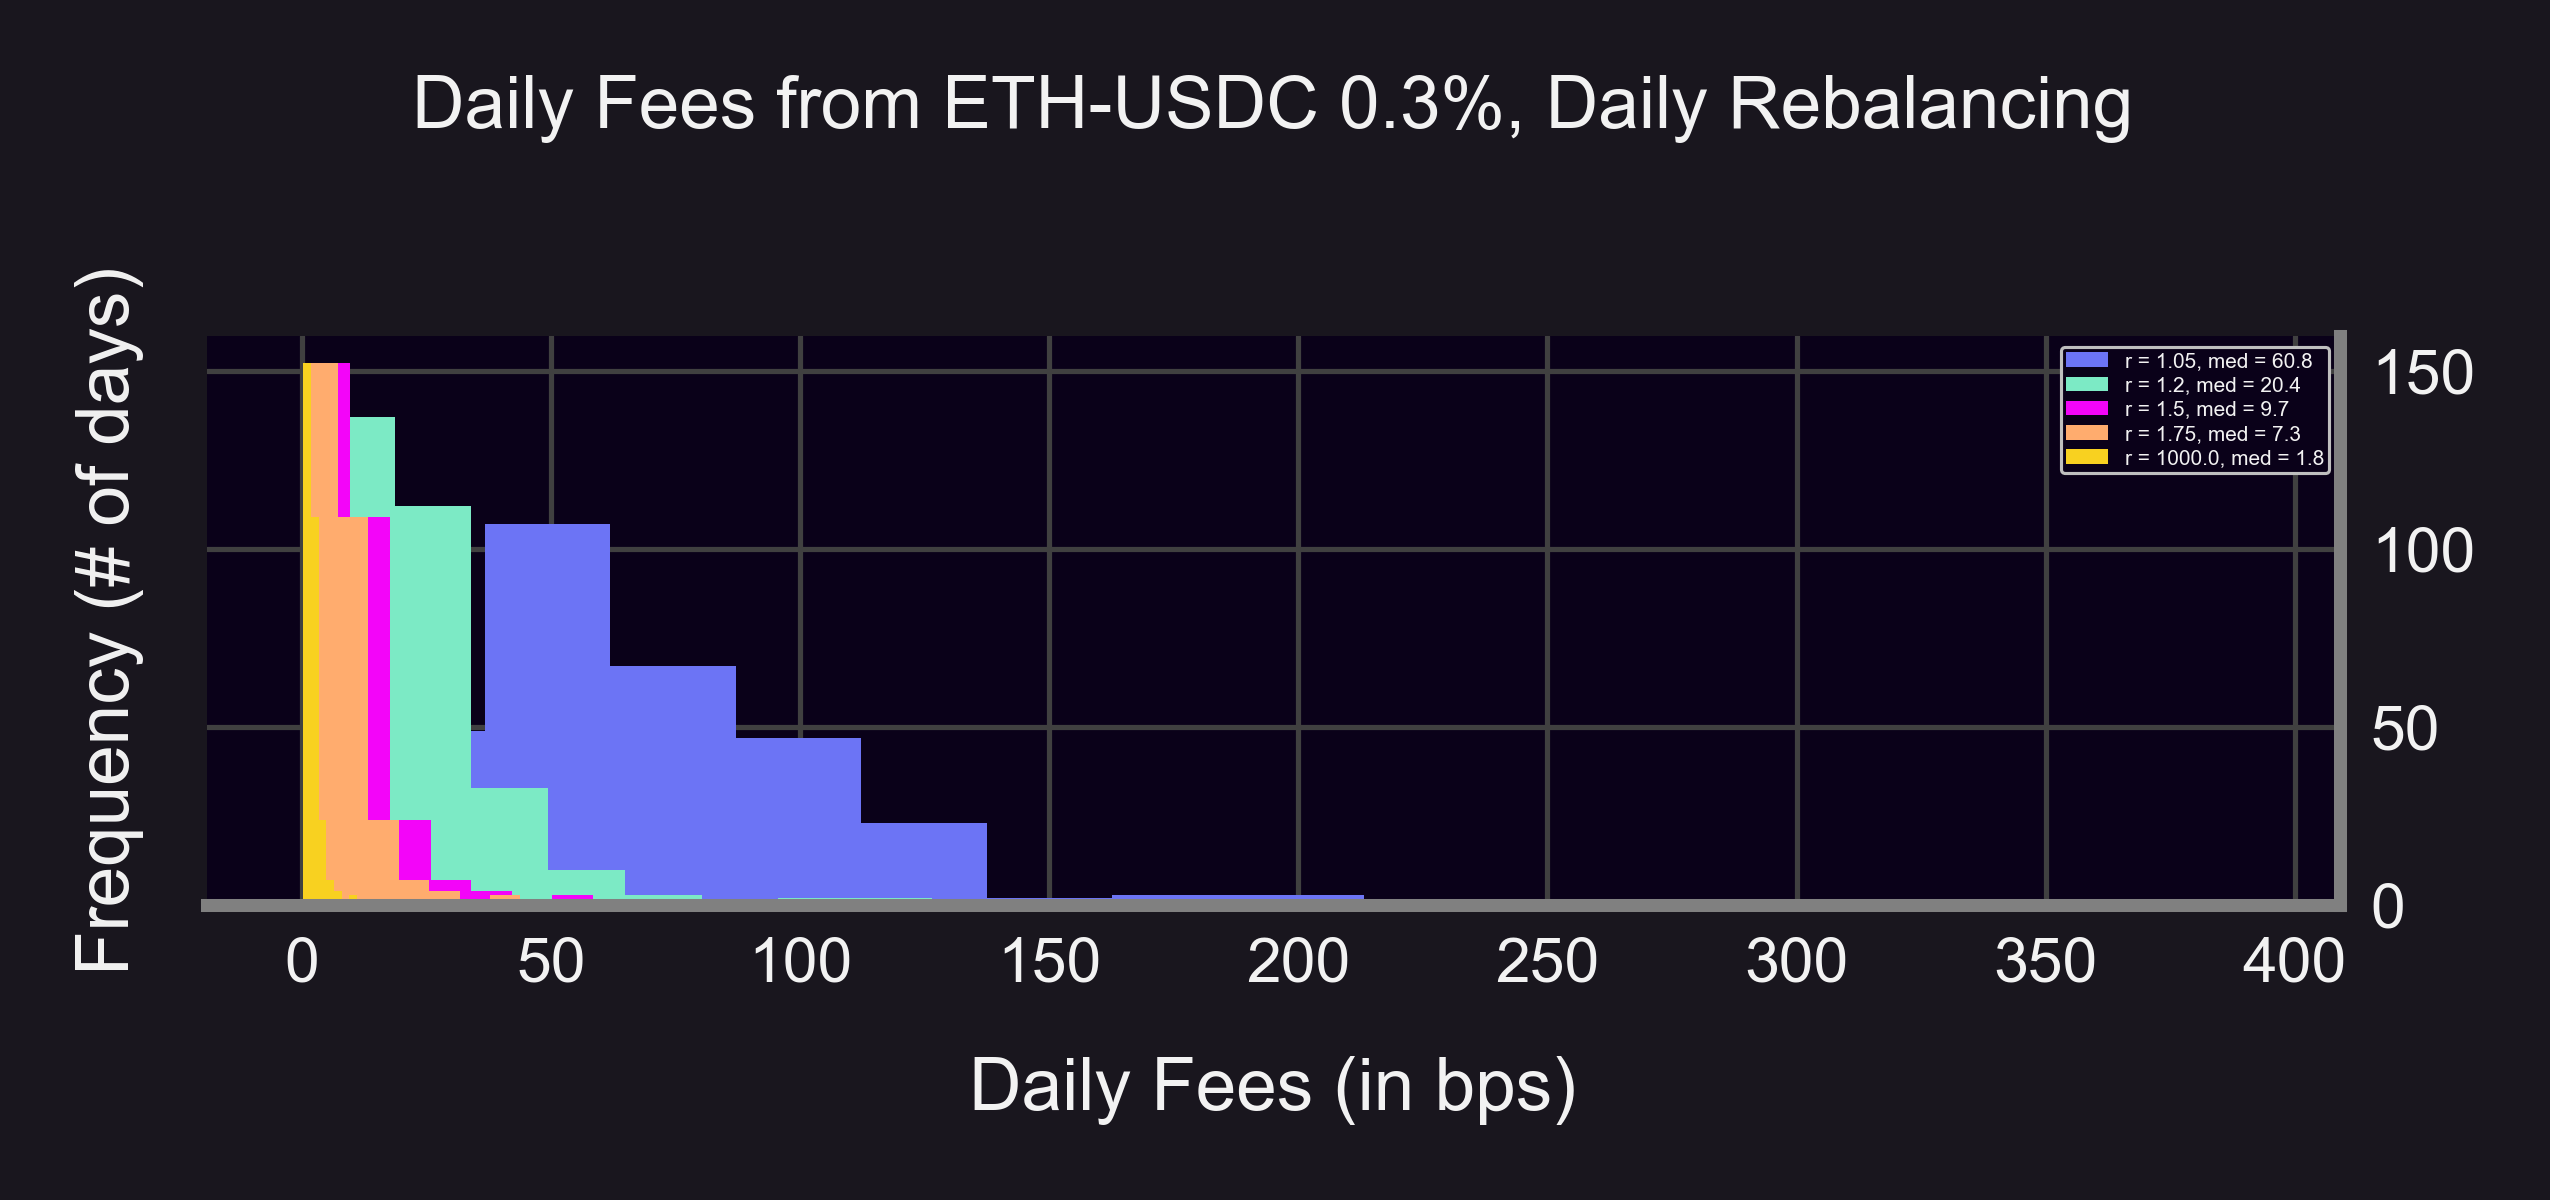

In [24]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][:mid_idx] * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][:mid_idx] * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][:mid_idx] * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_fees_P1",
          bins = 15,
)

Period 2

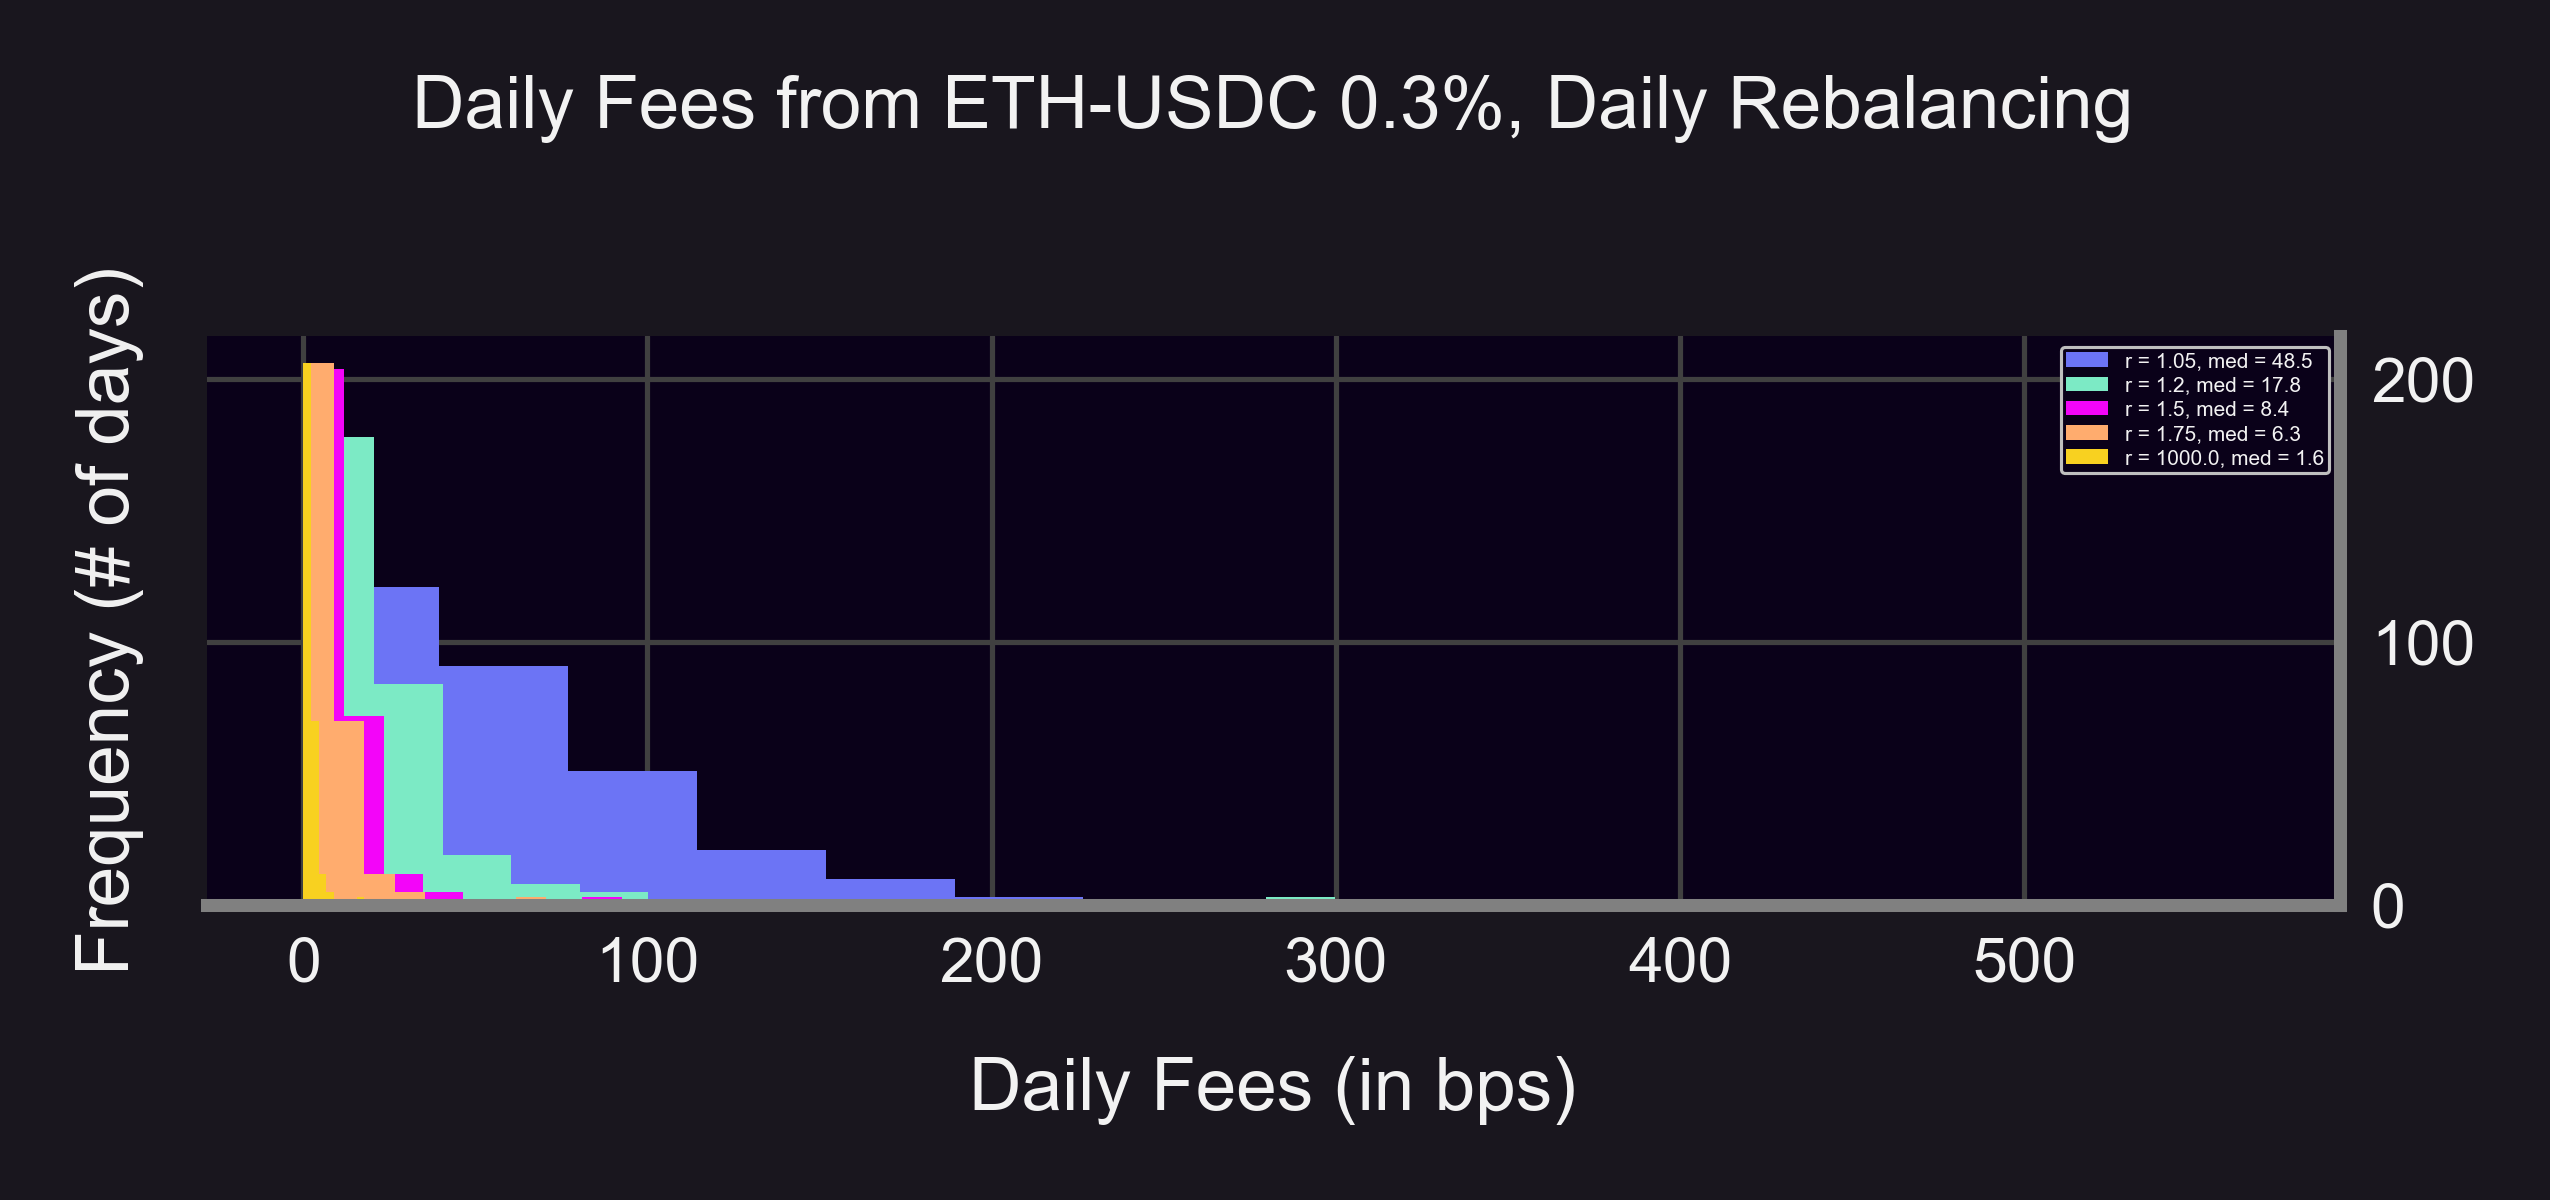

In [25]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][mid_idx:] * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][mid_idx:] * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][mid_idx:] * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_fees_P2",
          bins = 15,
)

### Returns

Period 1

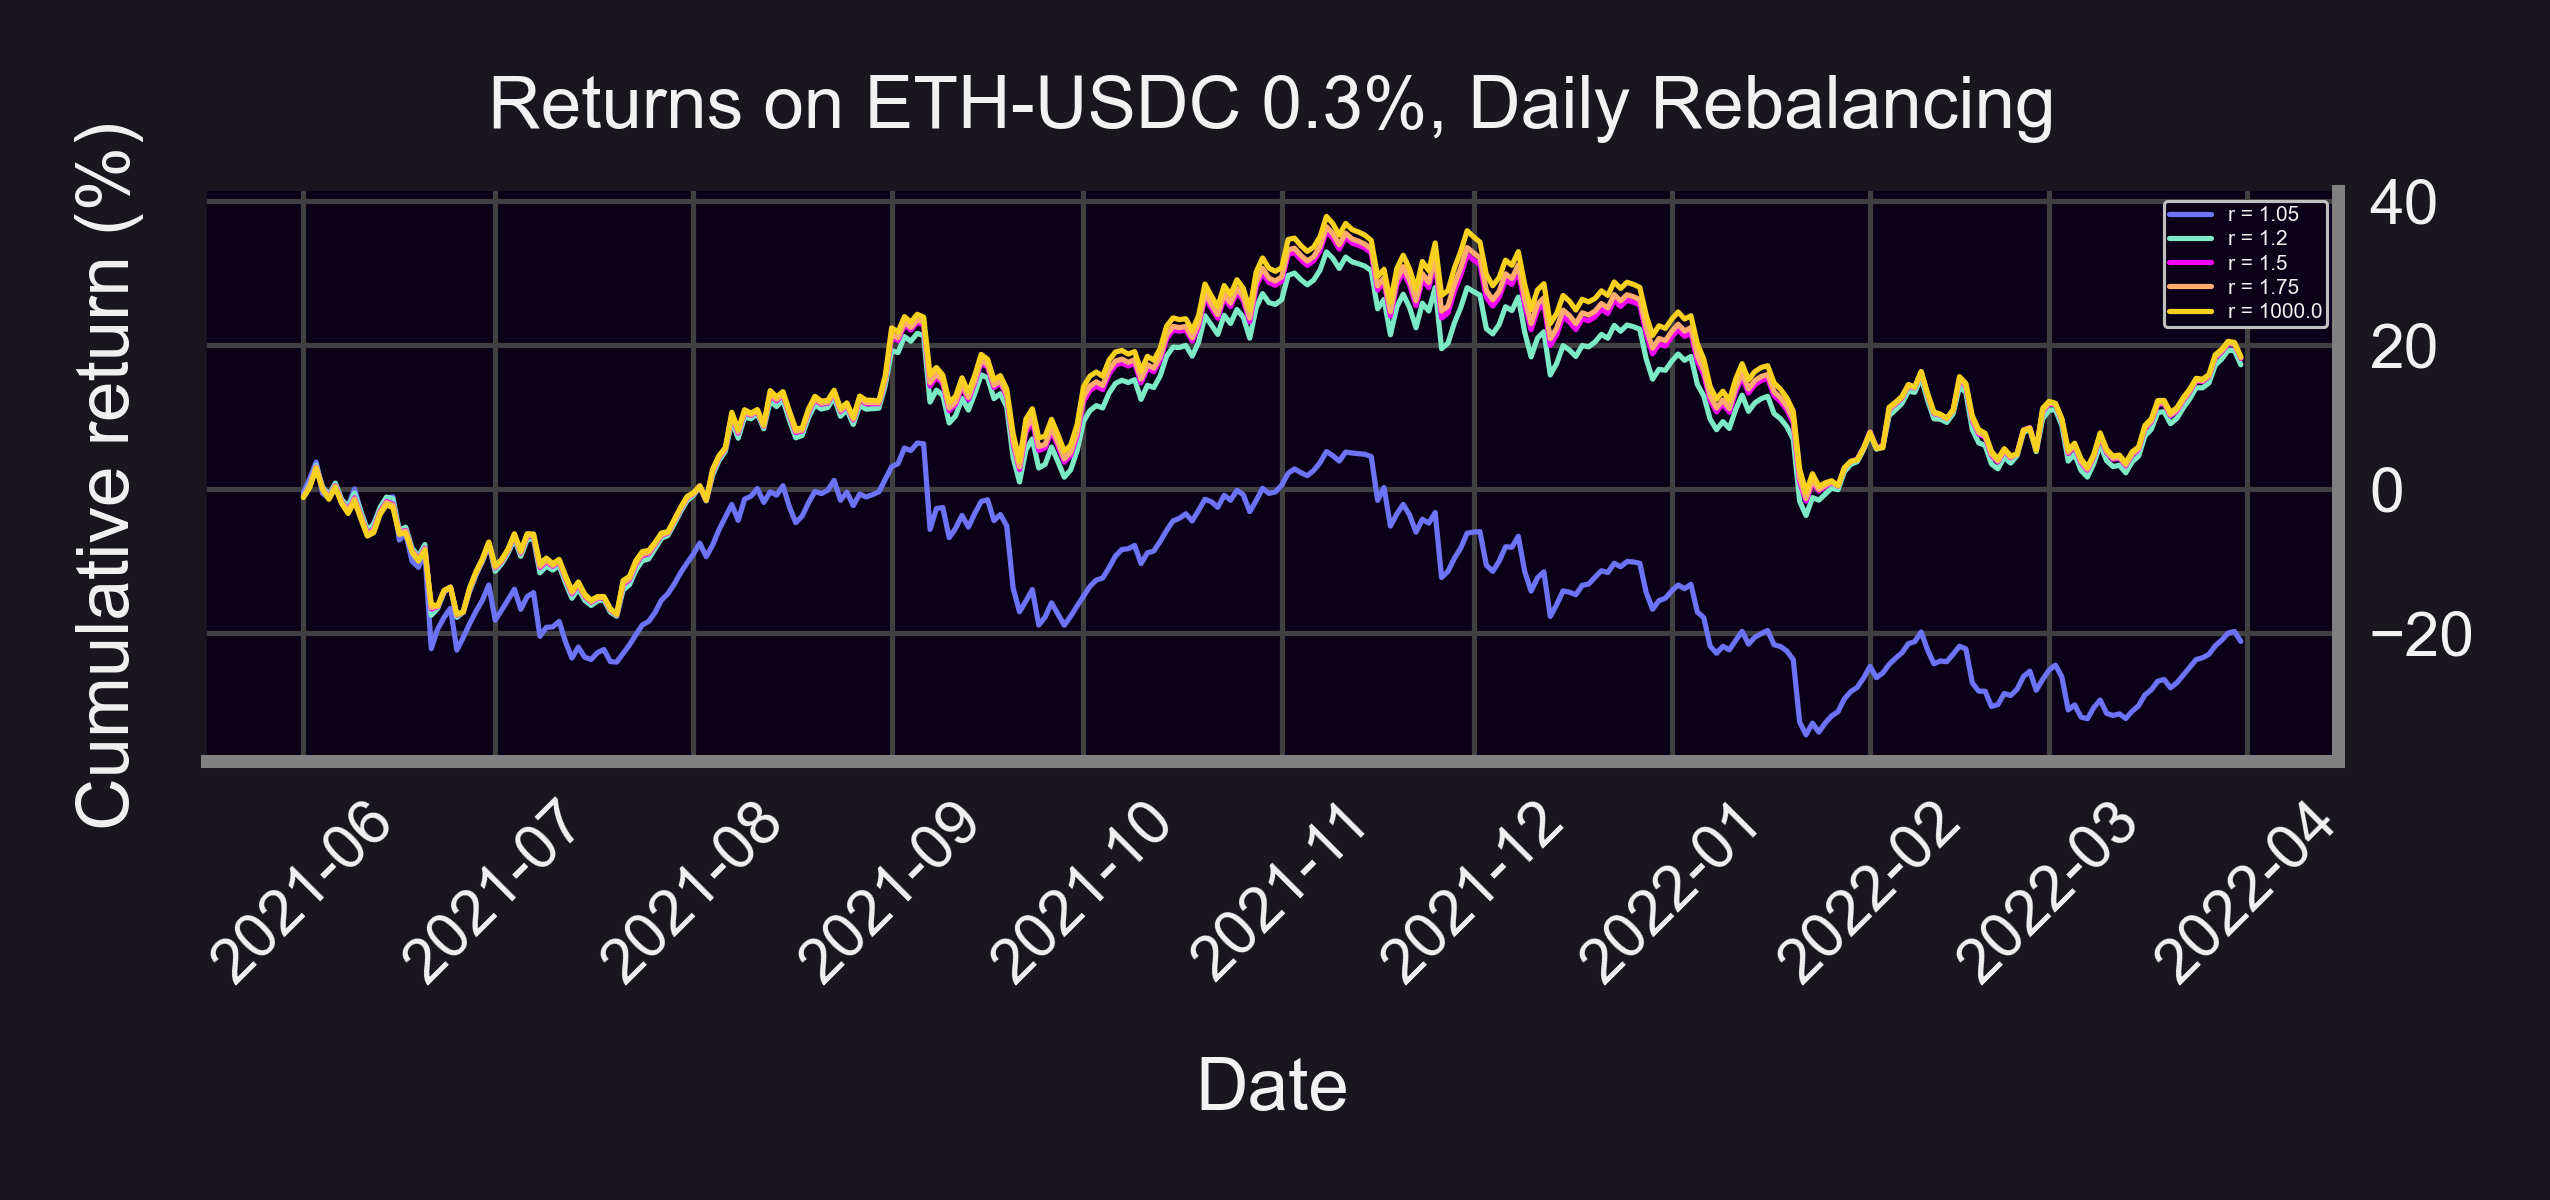

In [26]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['pnl_perc'][:mid_idx]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['pnl_perc'][:mid_idx]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['pnl_perc'][:mid_idx]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Returns on {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_rets_P1"
)

Period 2

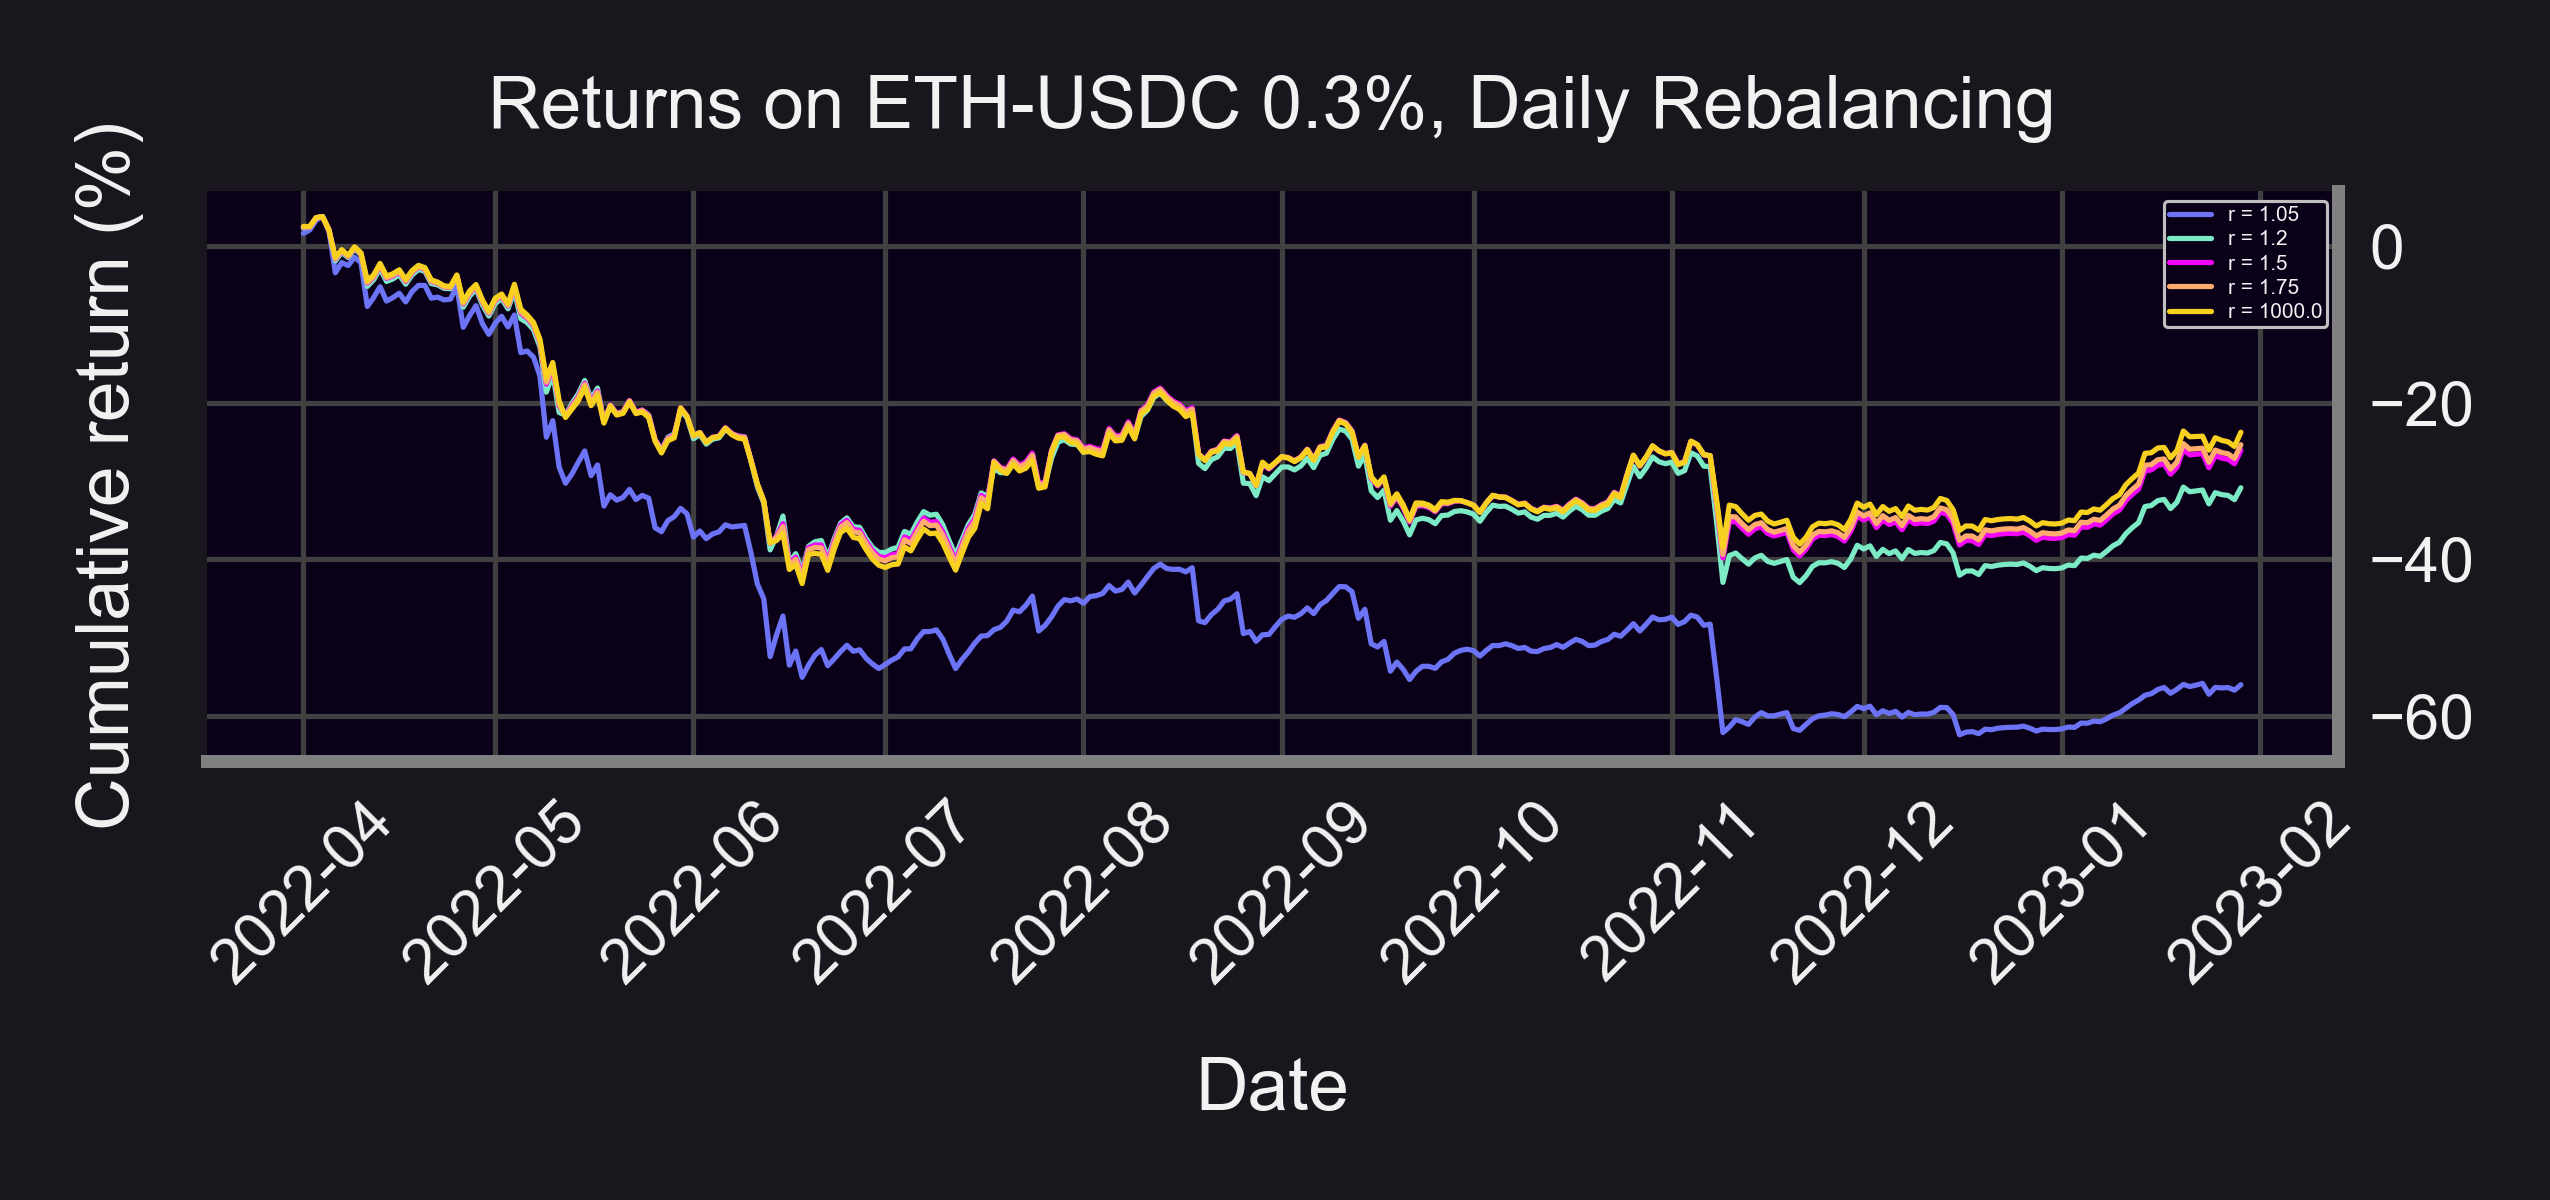

In [27]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['pnl_perc'][mid_idx:]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['pnl_perc'][mid_idx:]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['pnl_perc'][mid_idx:]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Returns on {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_rets_P2"
)

Period 1

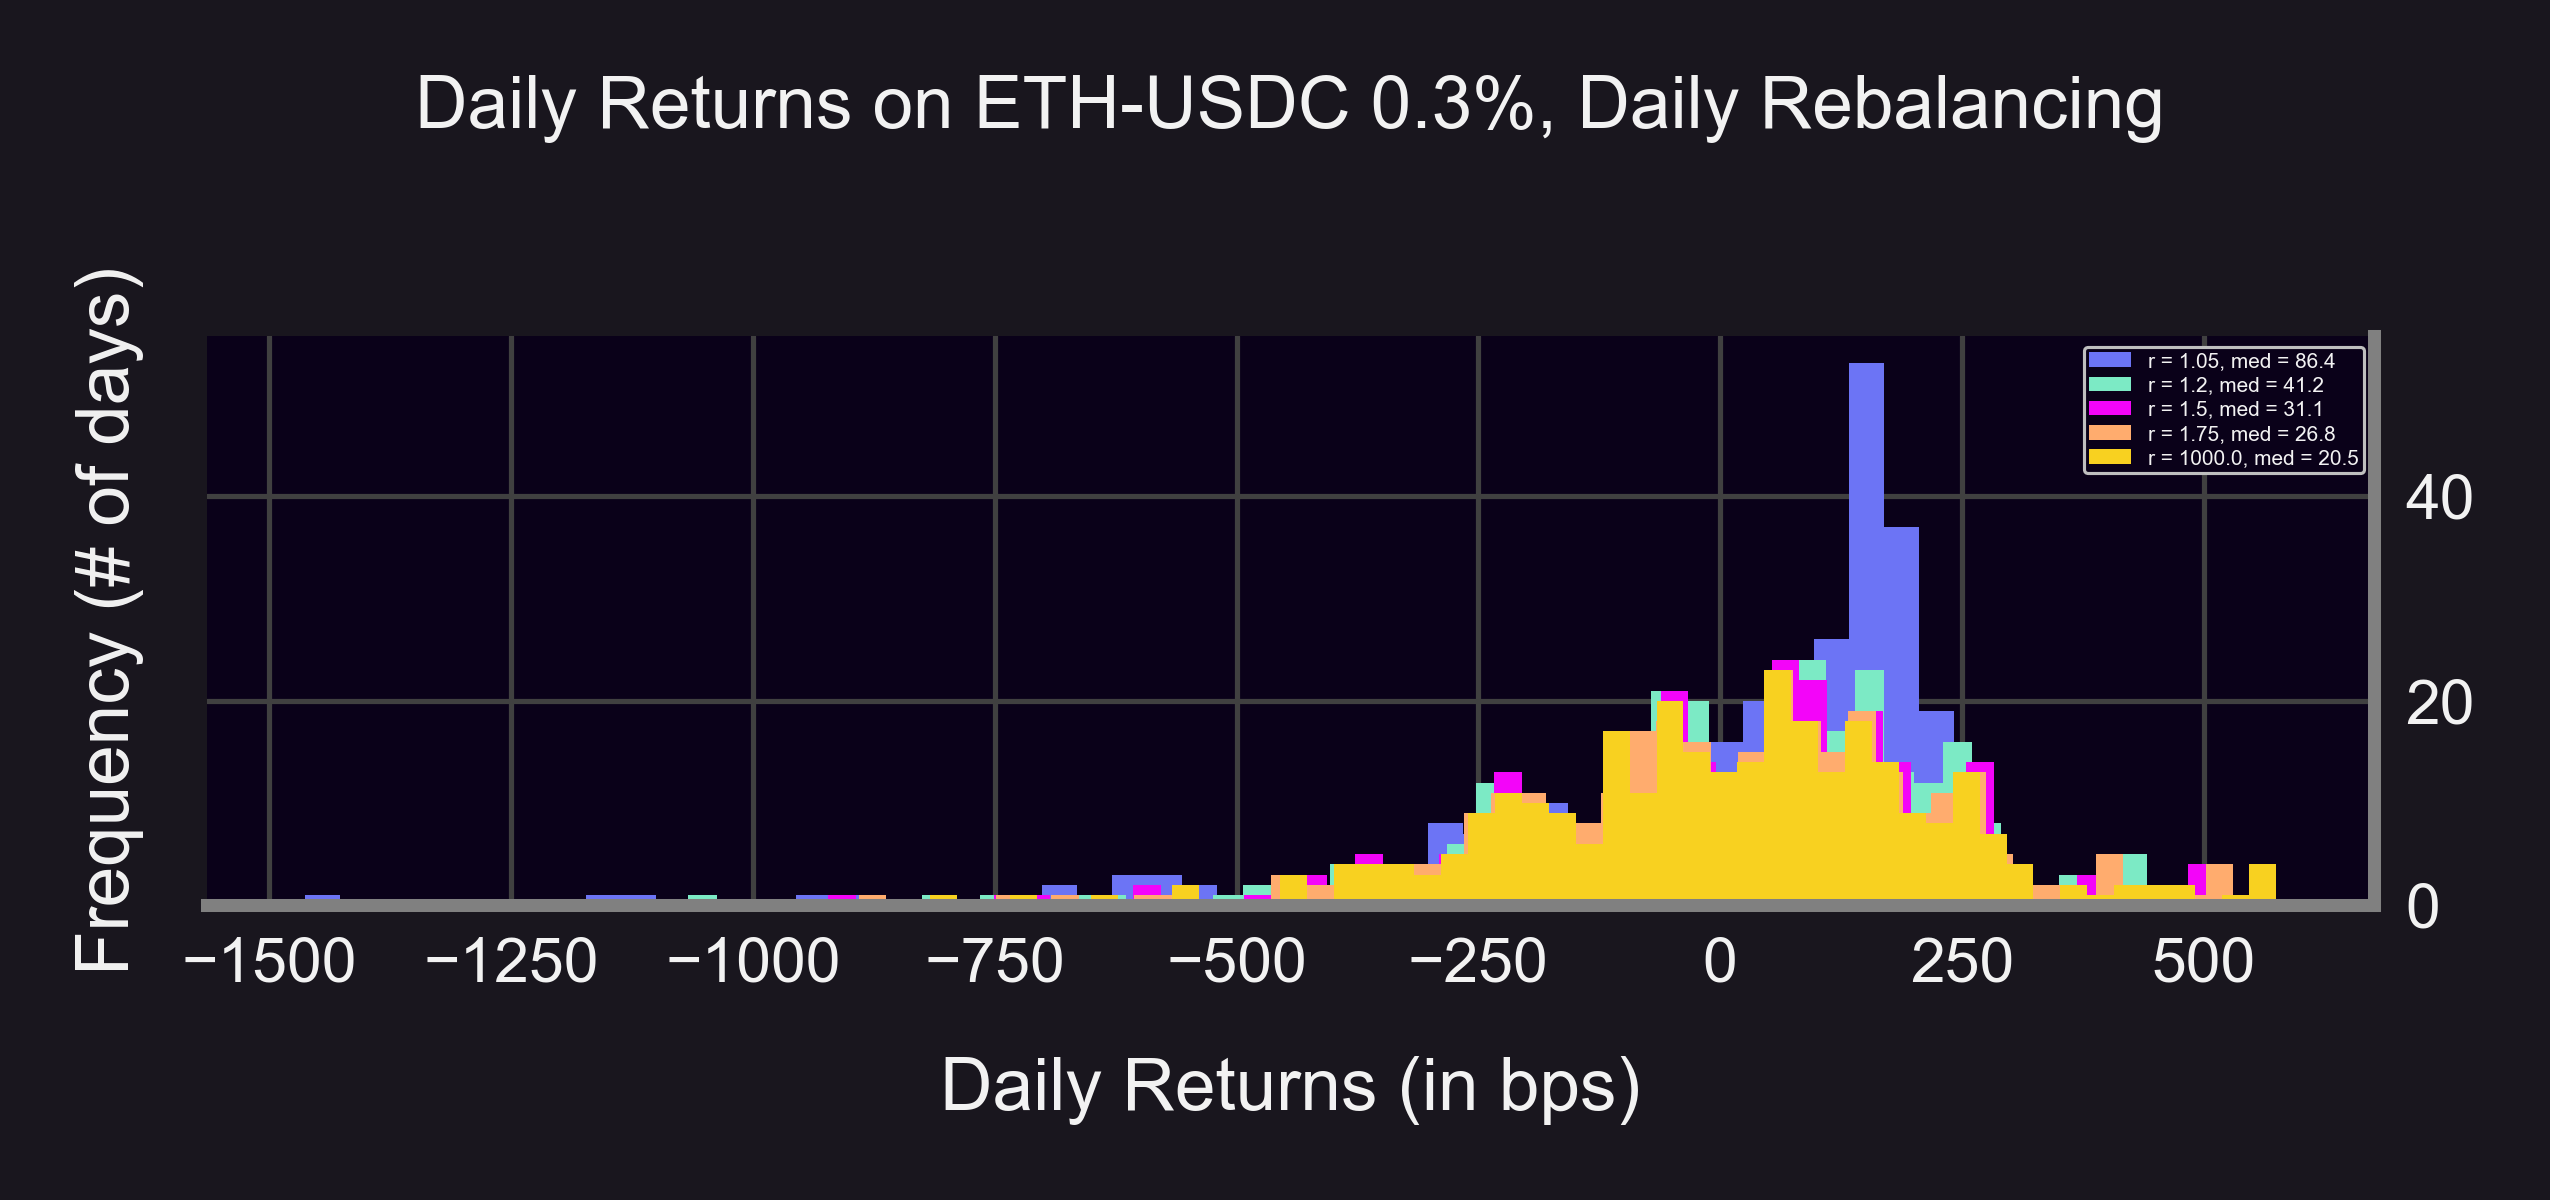

In [28]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['pnl_perc'][:mid_idx]) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['pnl_perc'][:mid_idx]) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['pnl_perc'][:mid_idx]) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Returns (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Returns on {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_rets_P1",
          bins = 50,
)

Period 2

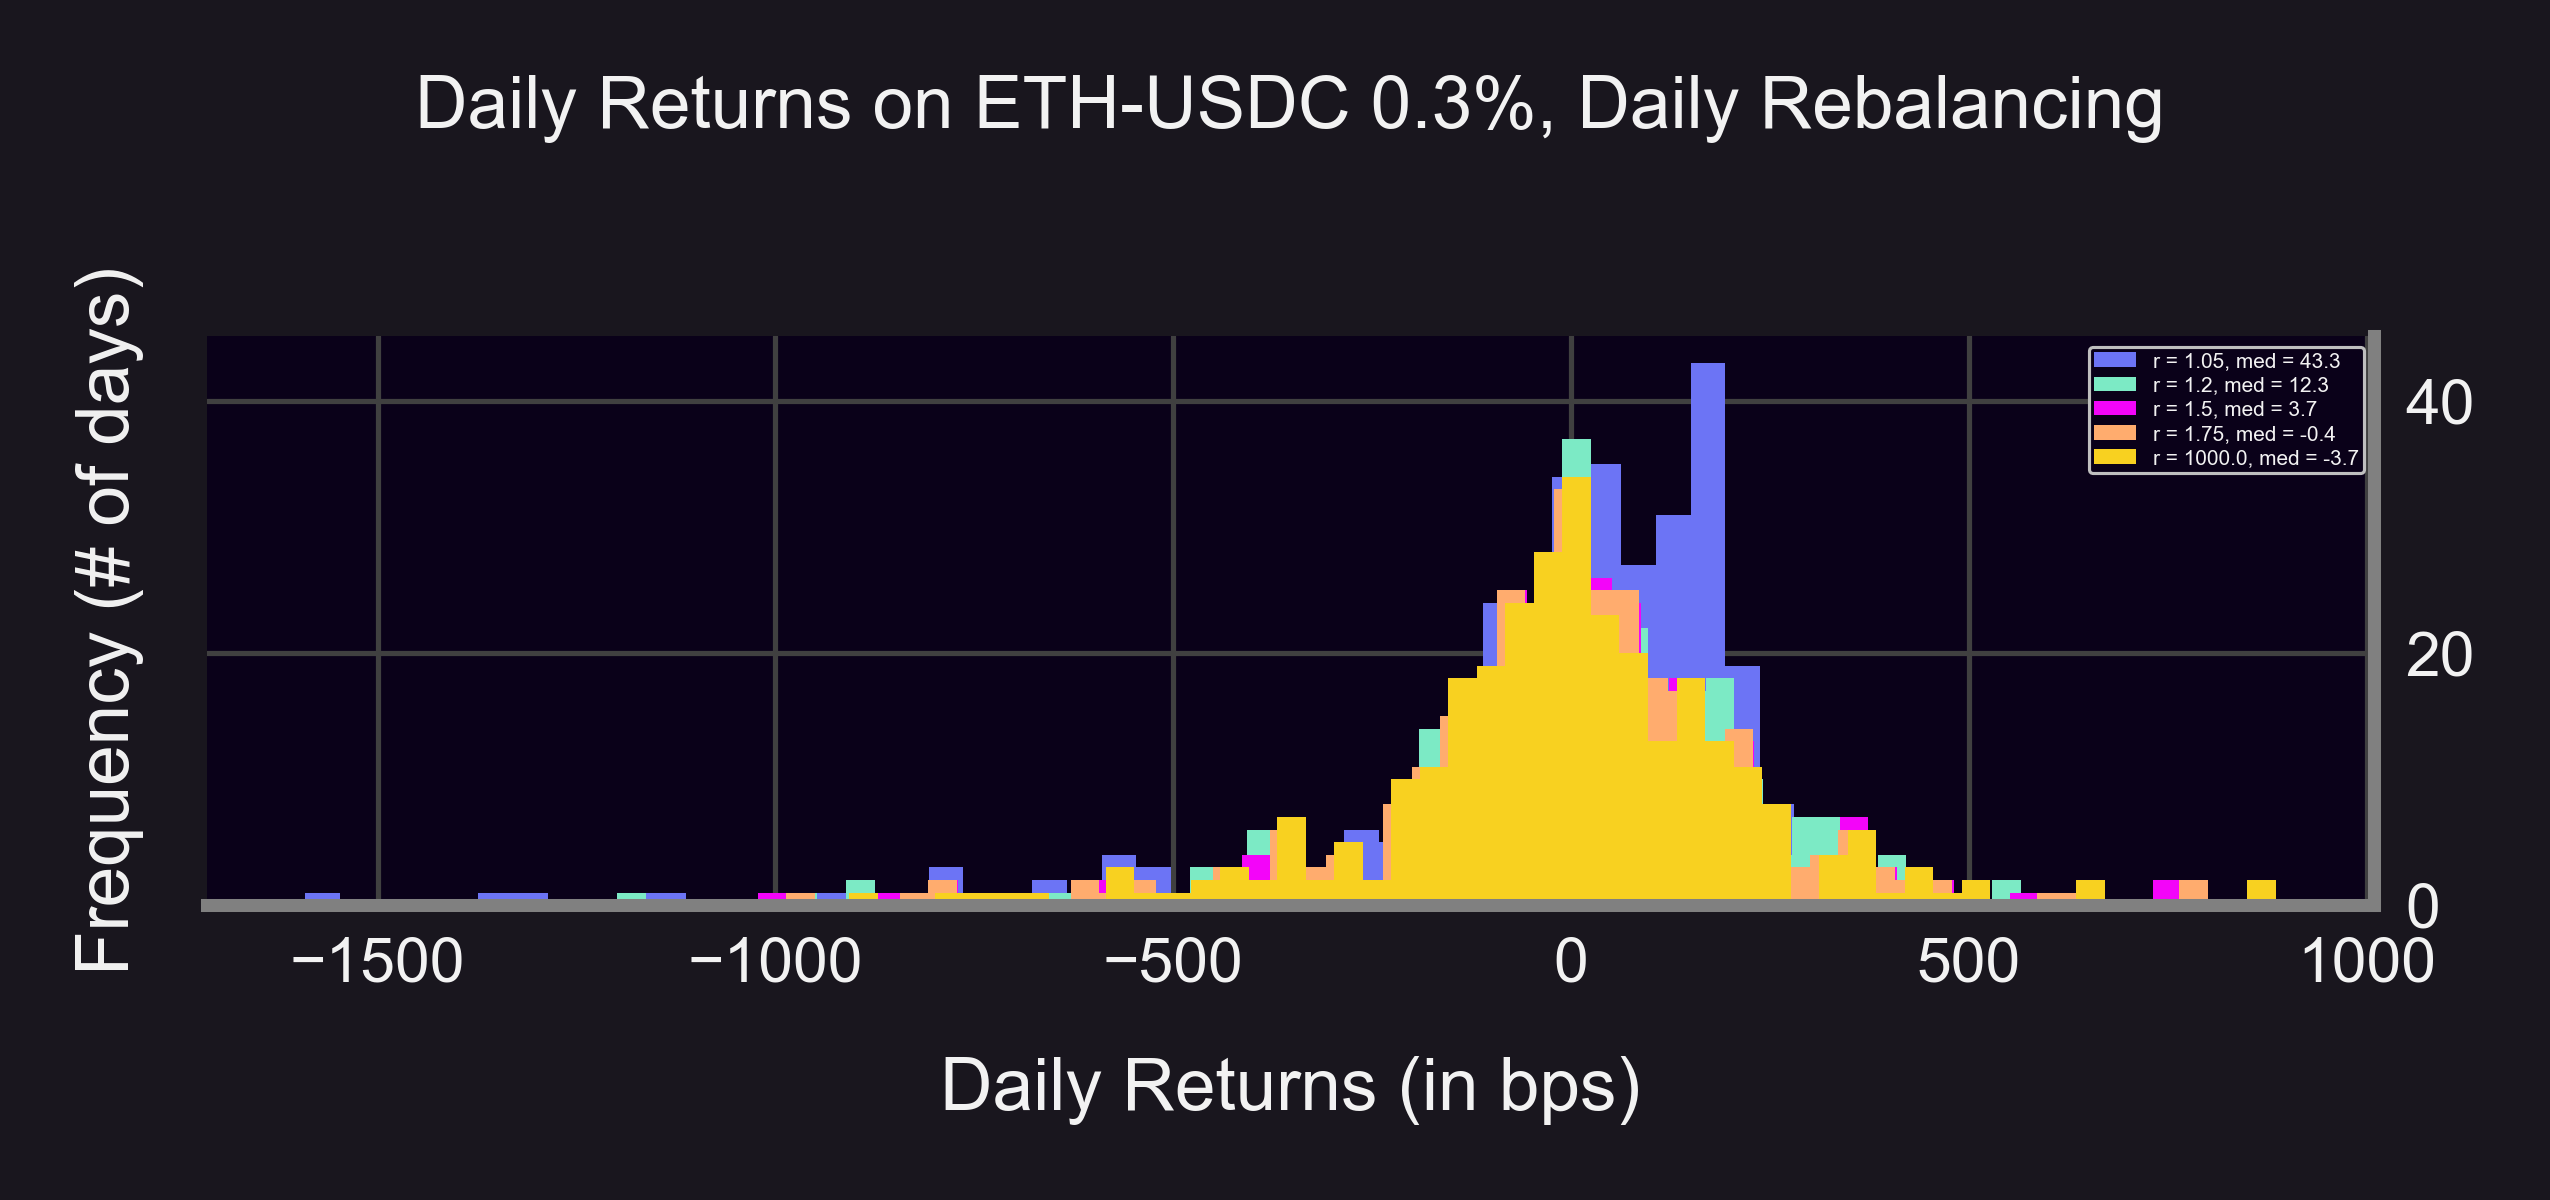

In [29]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['pnl_perc'][mid_idx:]) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['pnl_perc'][mid_idx:]) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['pnl_perc'][mid_idx:]) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Returns (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Returns on {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_rets_P2",
          bins = 50,
)

### Fees minus IL

Period 1

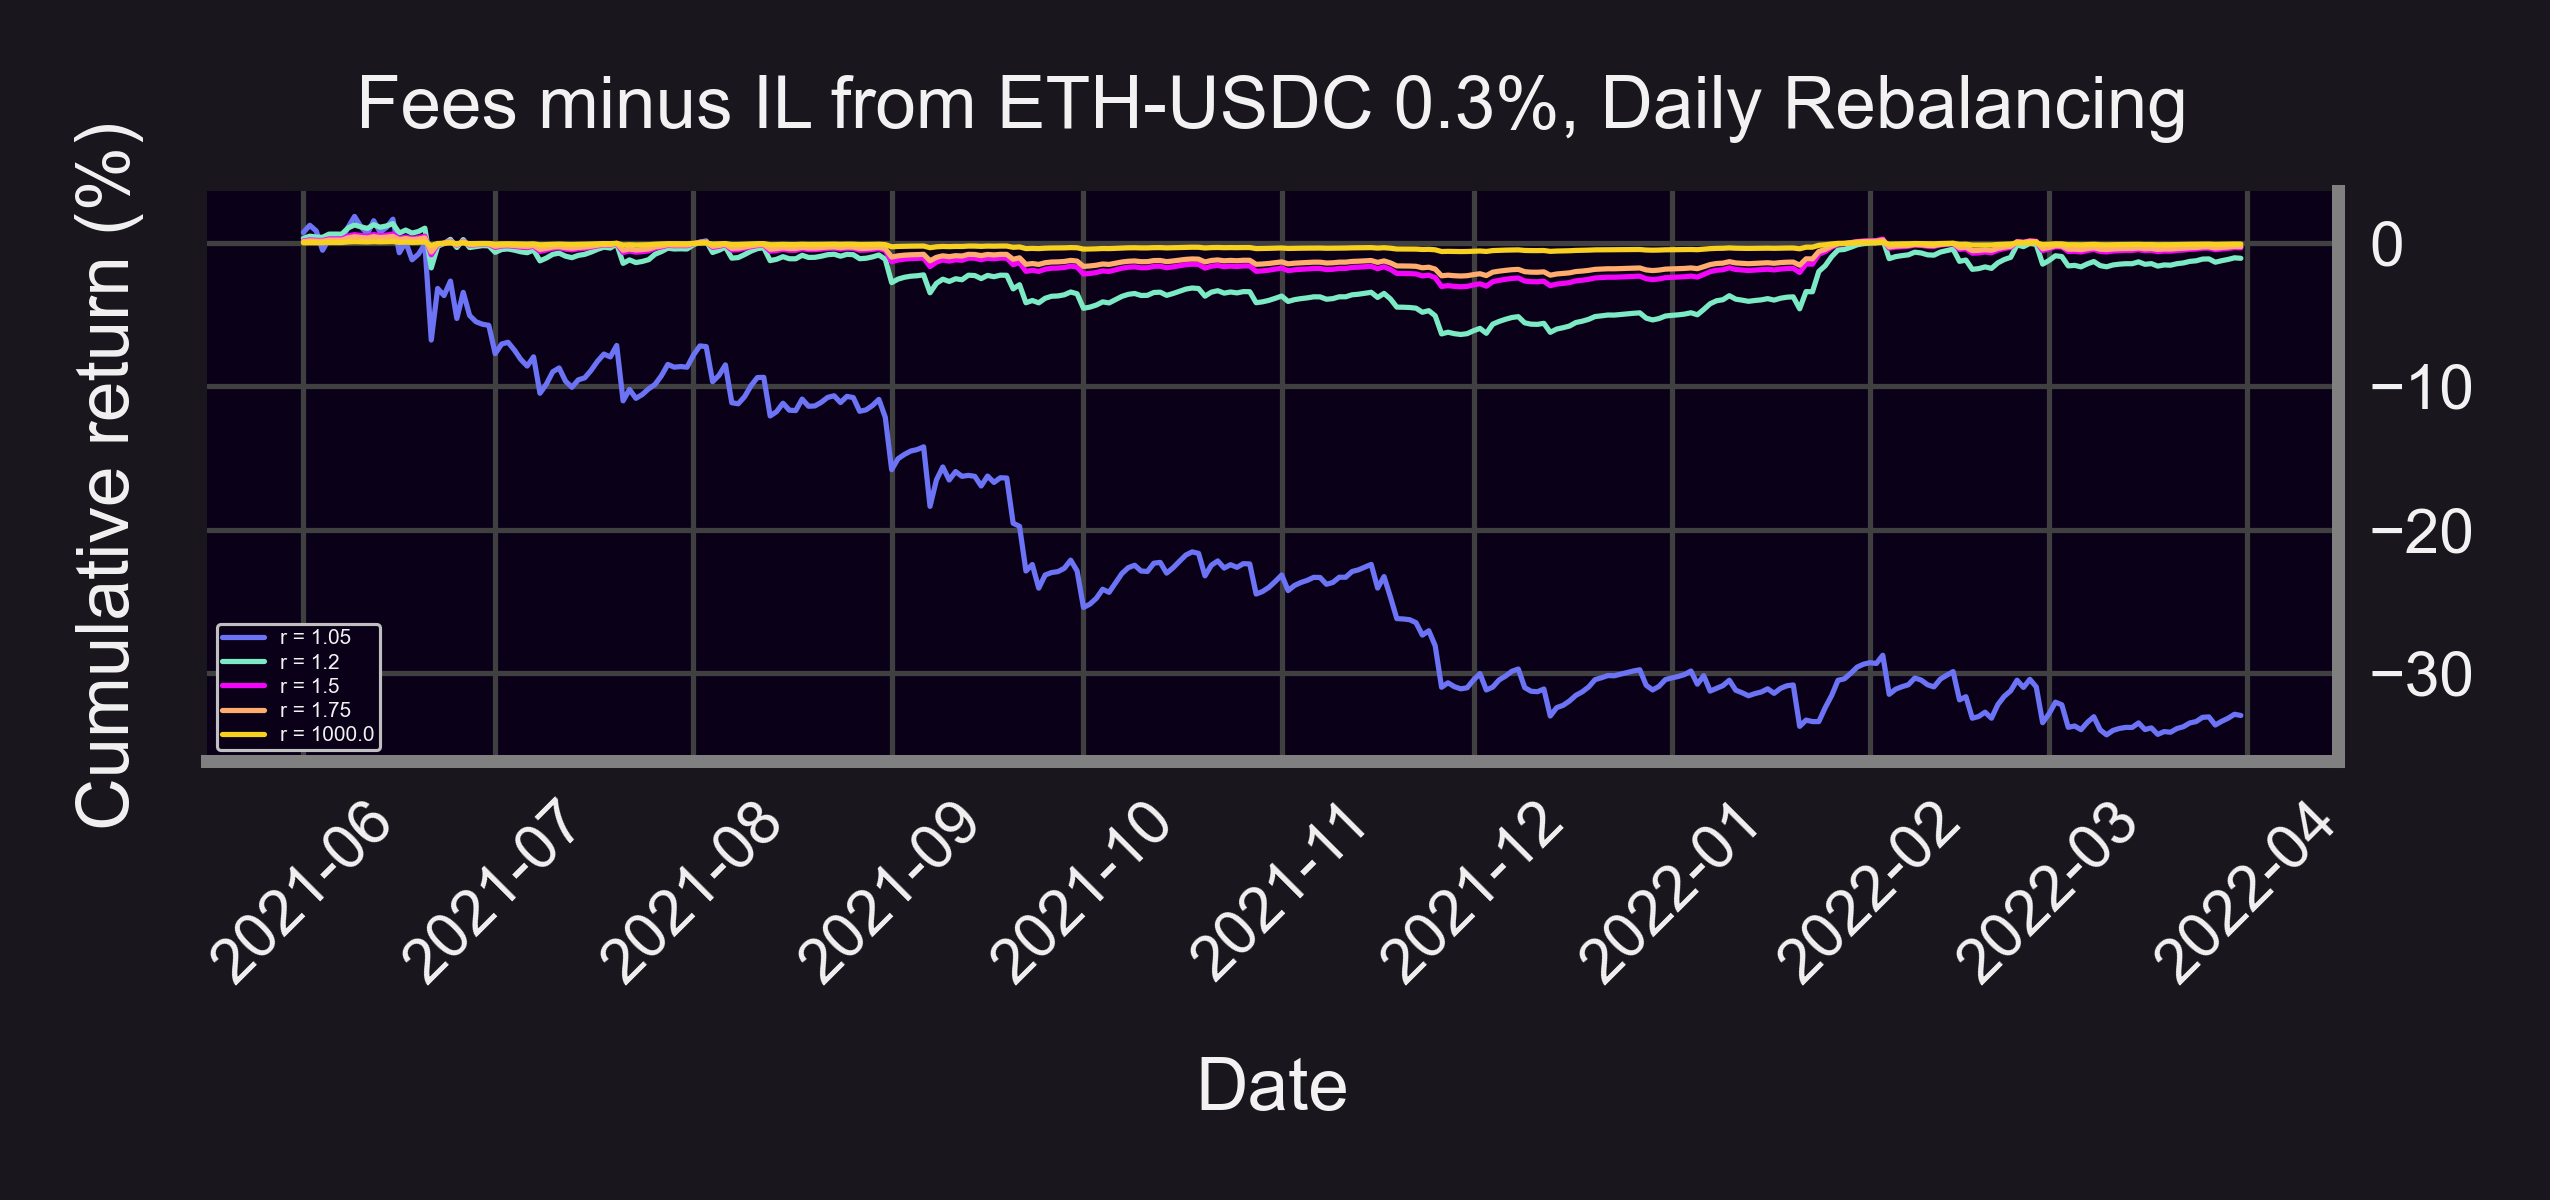

In [30]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['IL_perc'][:mid_idx]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['IL_perc'][:mid_idx]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['IL_perc'][:mid_idx]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees minus IL from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_IL_P1"
)

Period 2

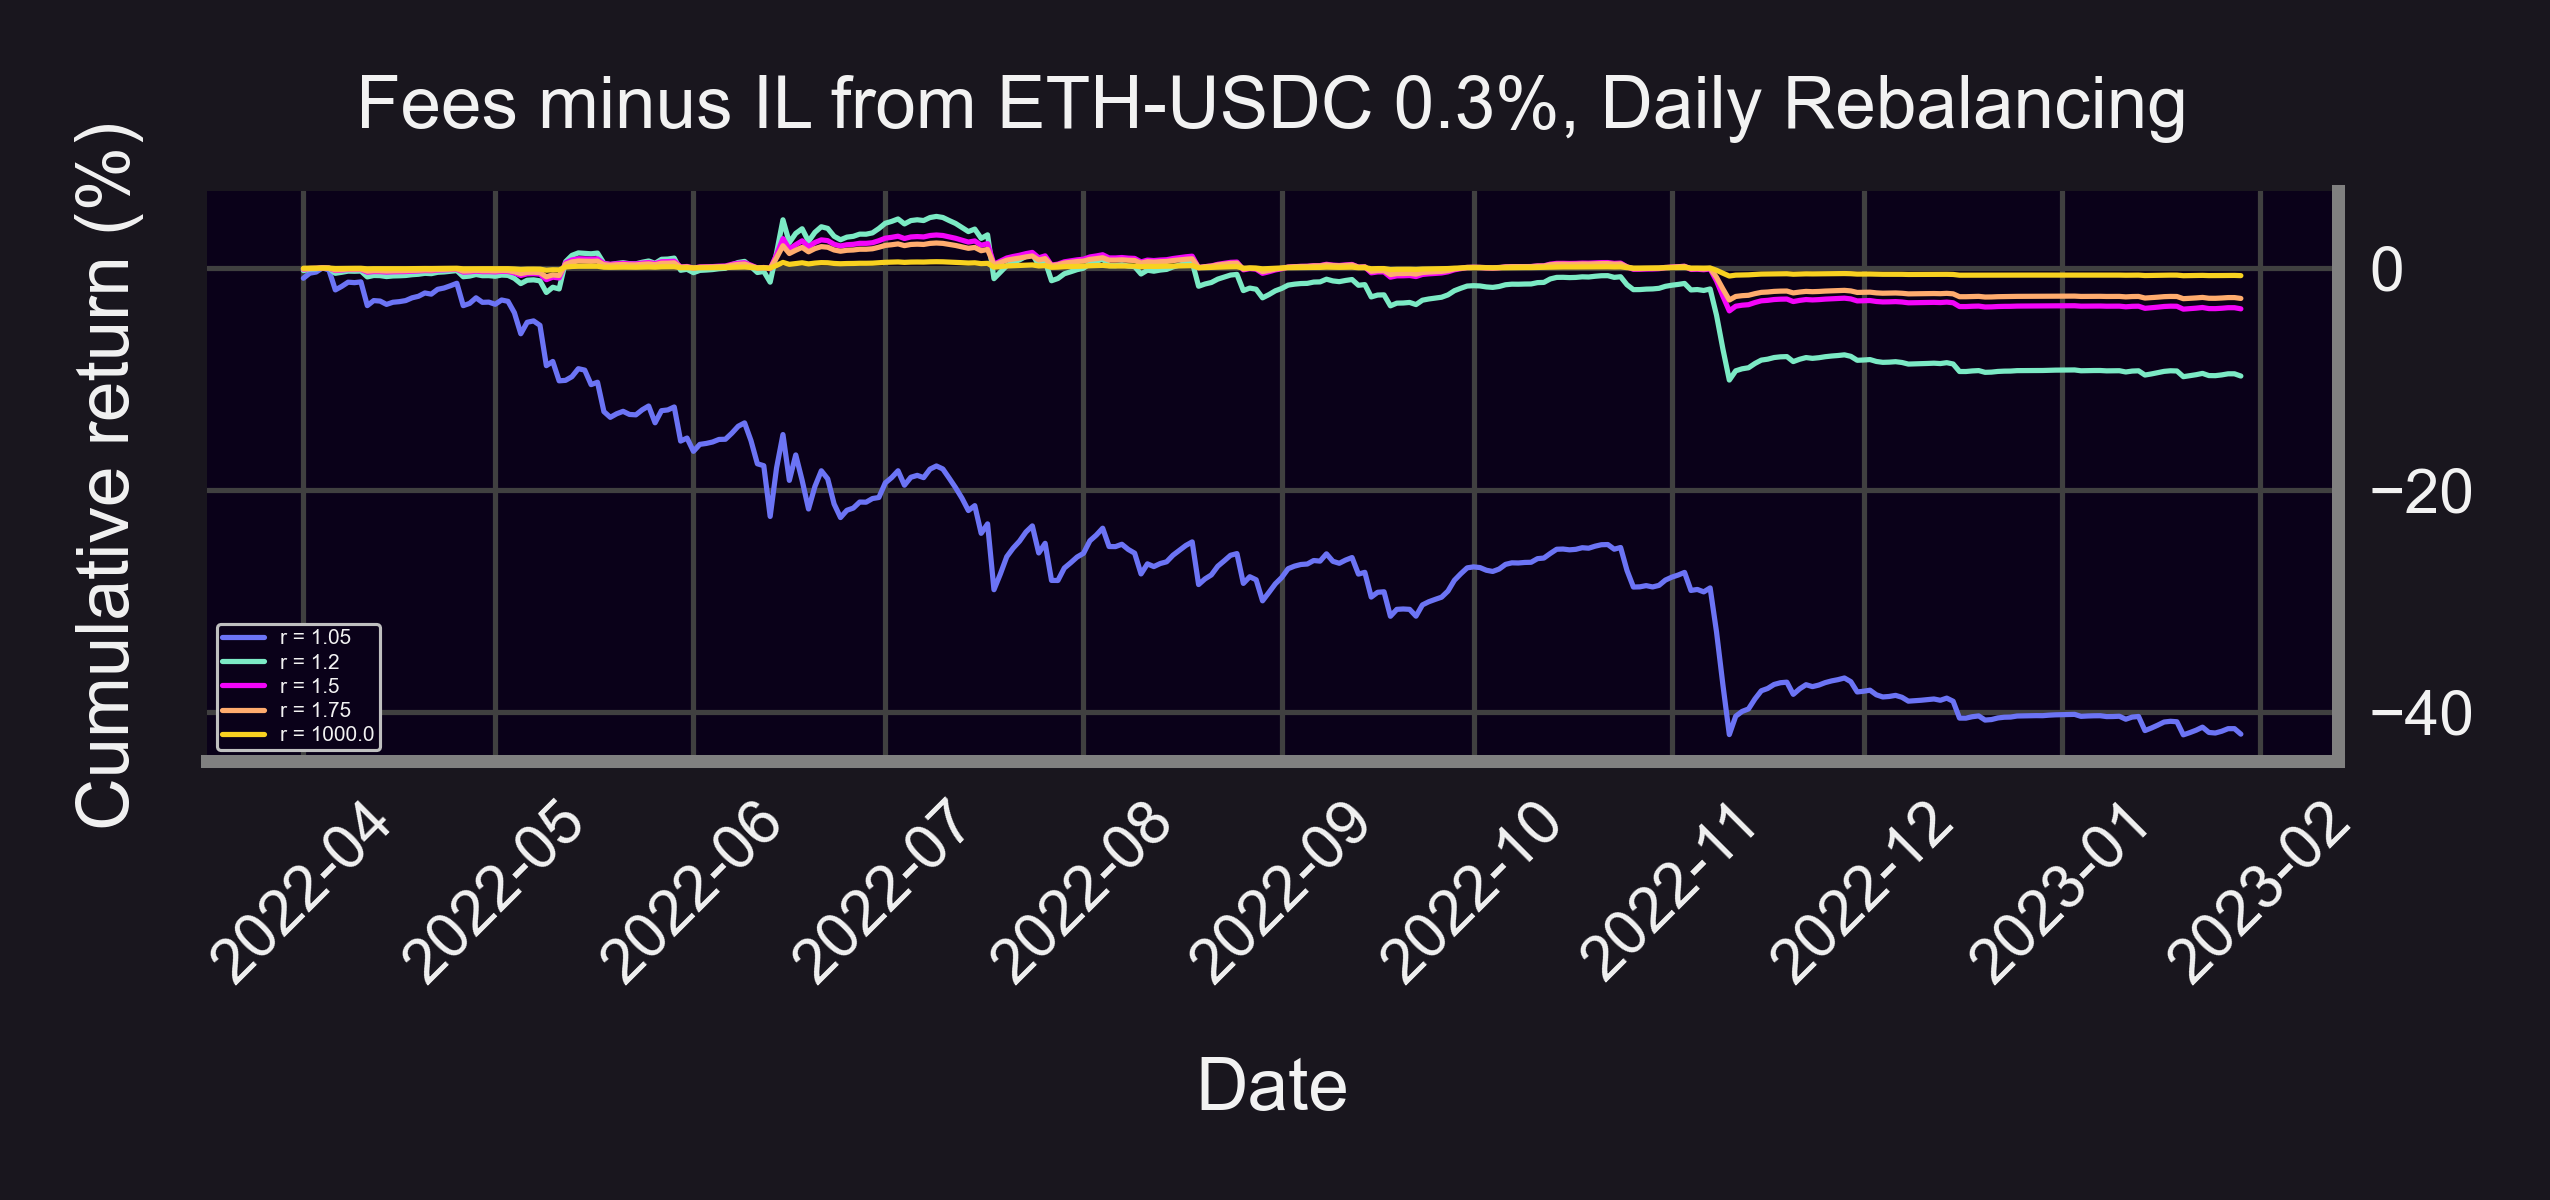

In [31]:
'''Cumulative Returns'''
rets = {}
for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['IL_perc'][mid_idx:]
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['IL_perc'][mid_idx:]
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['IL_perc'][mid_idx:]

# Plot rebalancing strategies
plot_cum_rets(rets = rets,
     xlabel = 'Date',
     ylabel = 'Cumulative return (%)',
     title = f'Fees minus IL from {pool_name}, {reb_period} Rebalancing',
     dir = f"{strat.raw_dir}cum_IL_P2"
)

Period 1

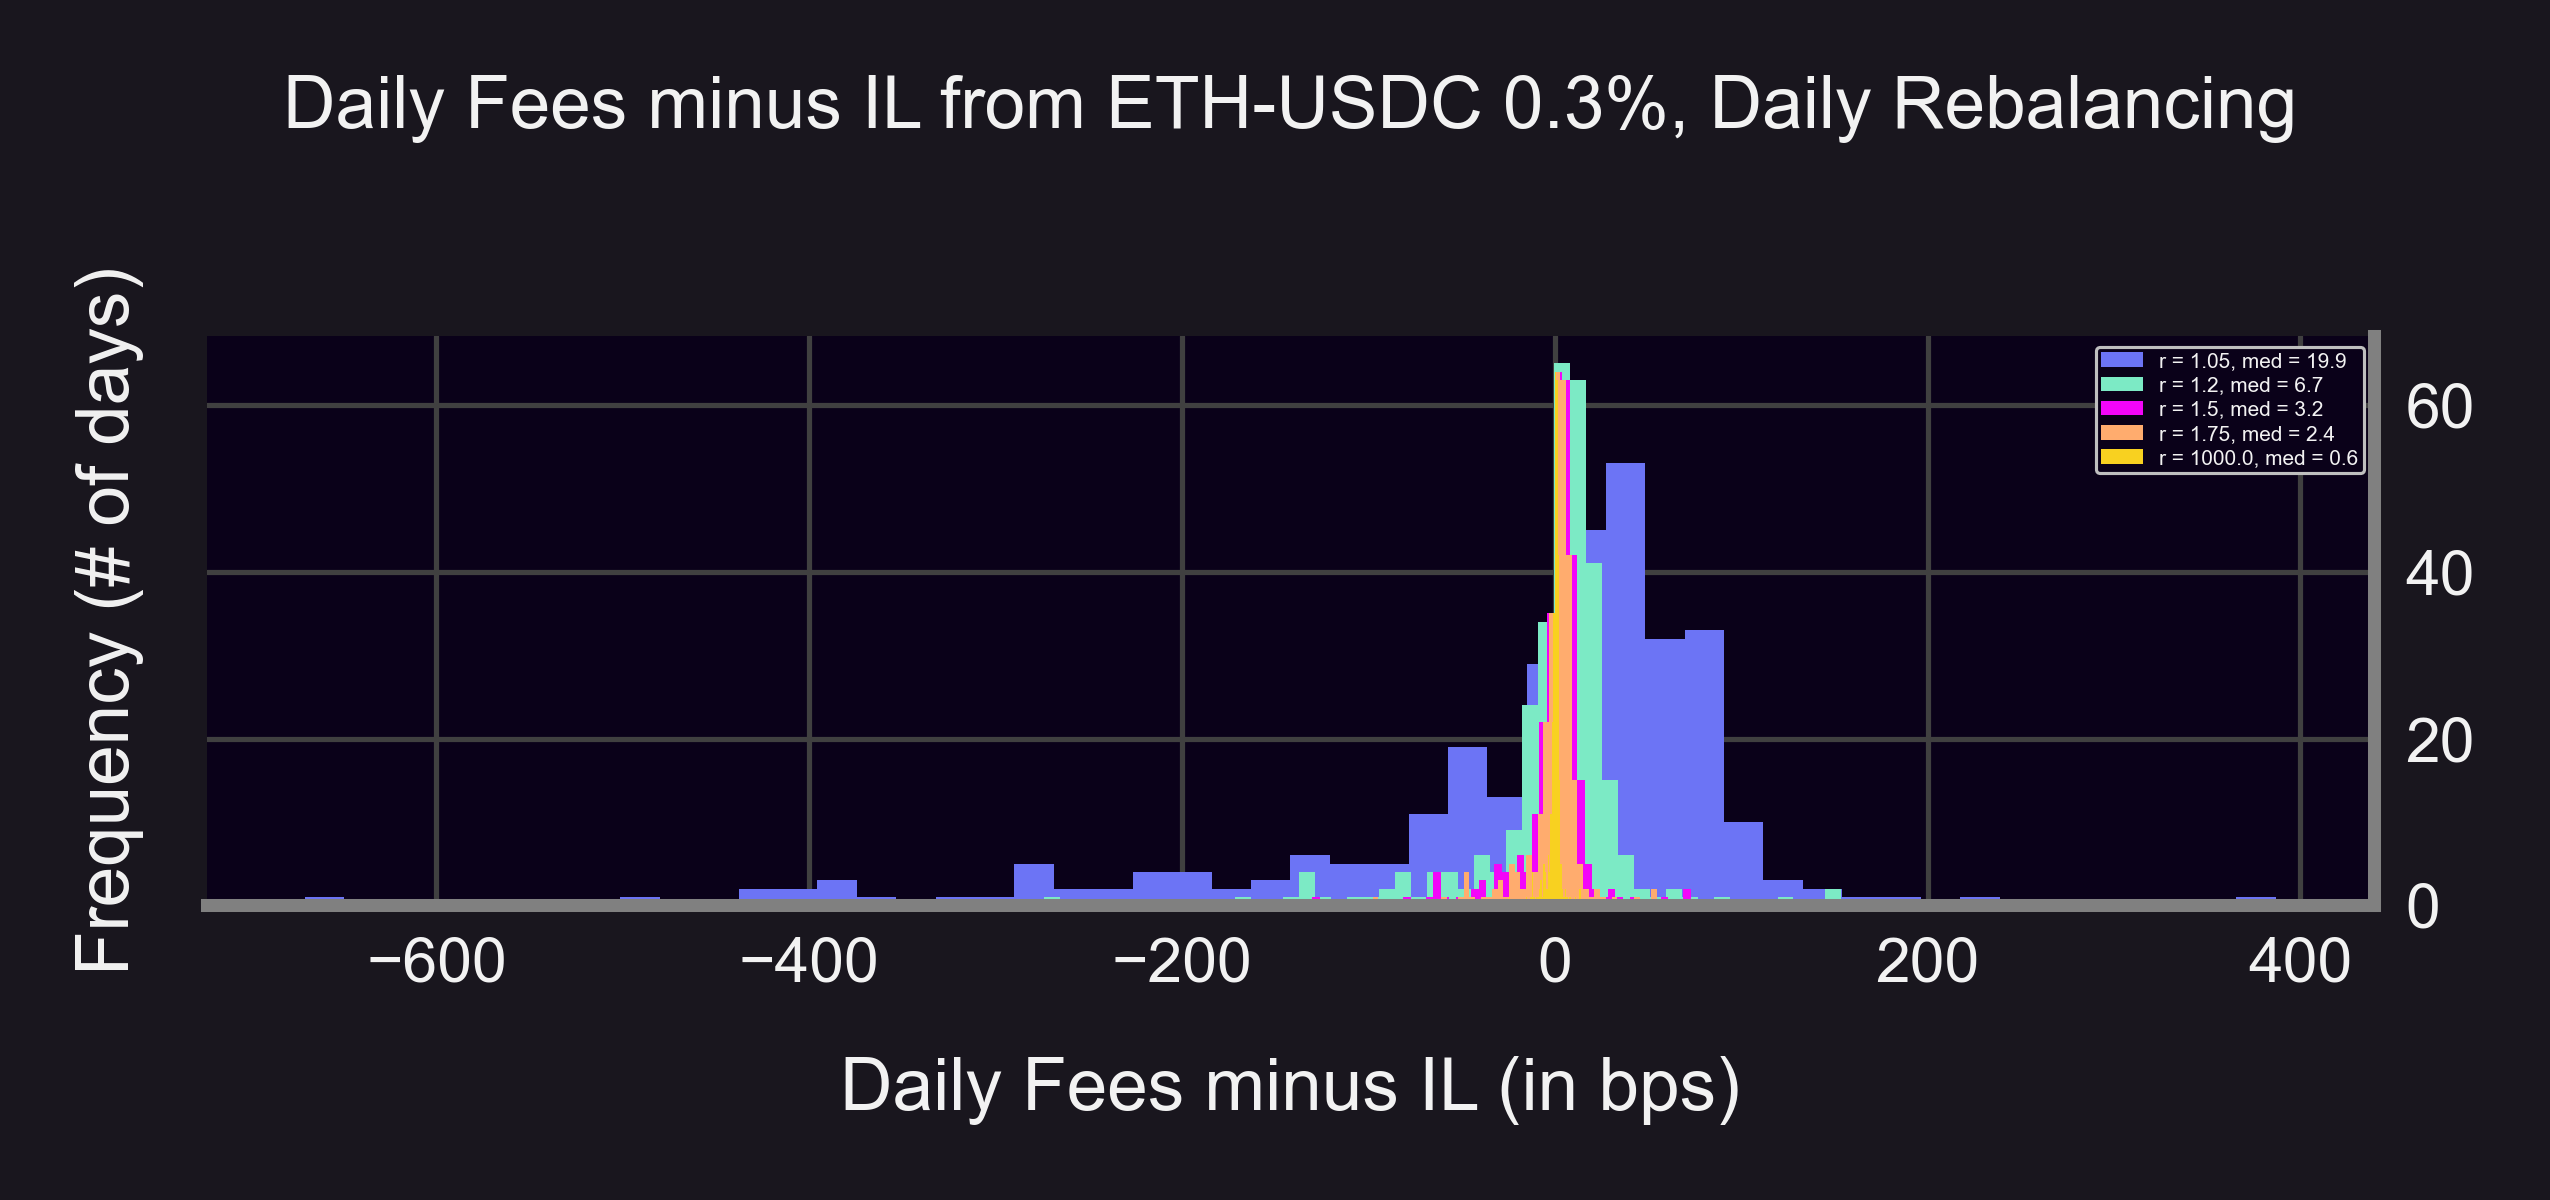

In [32]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['IL_perc'][:mid_idx]) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['IL_perc'][:mid_idx]) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['IL_perc'][:mid_idx]) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees minus IL (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees minus IL from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_IL_P1",
          bins = 50,
)

Period 2

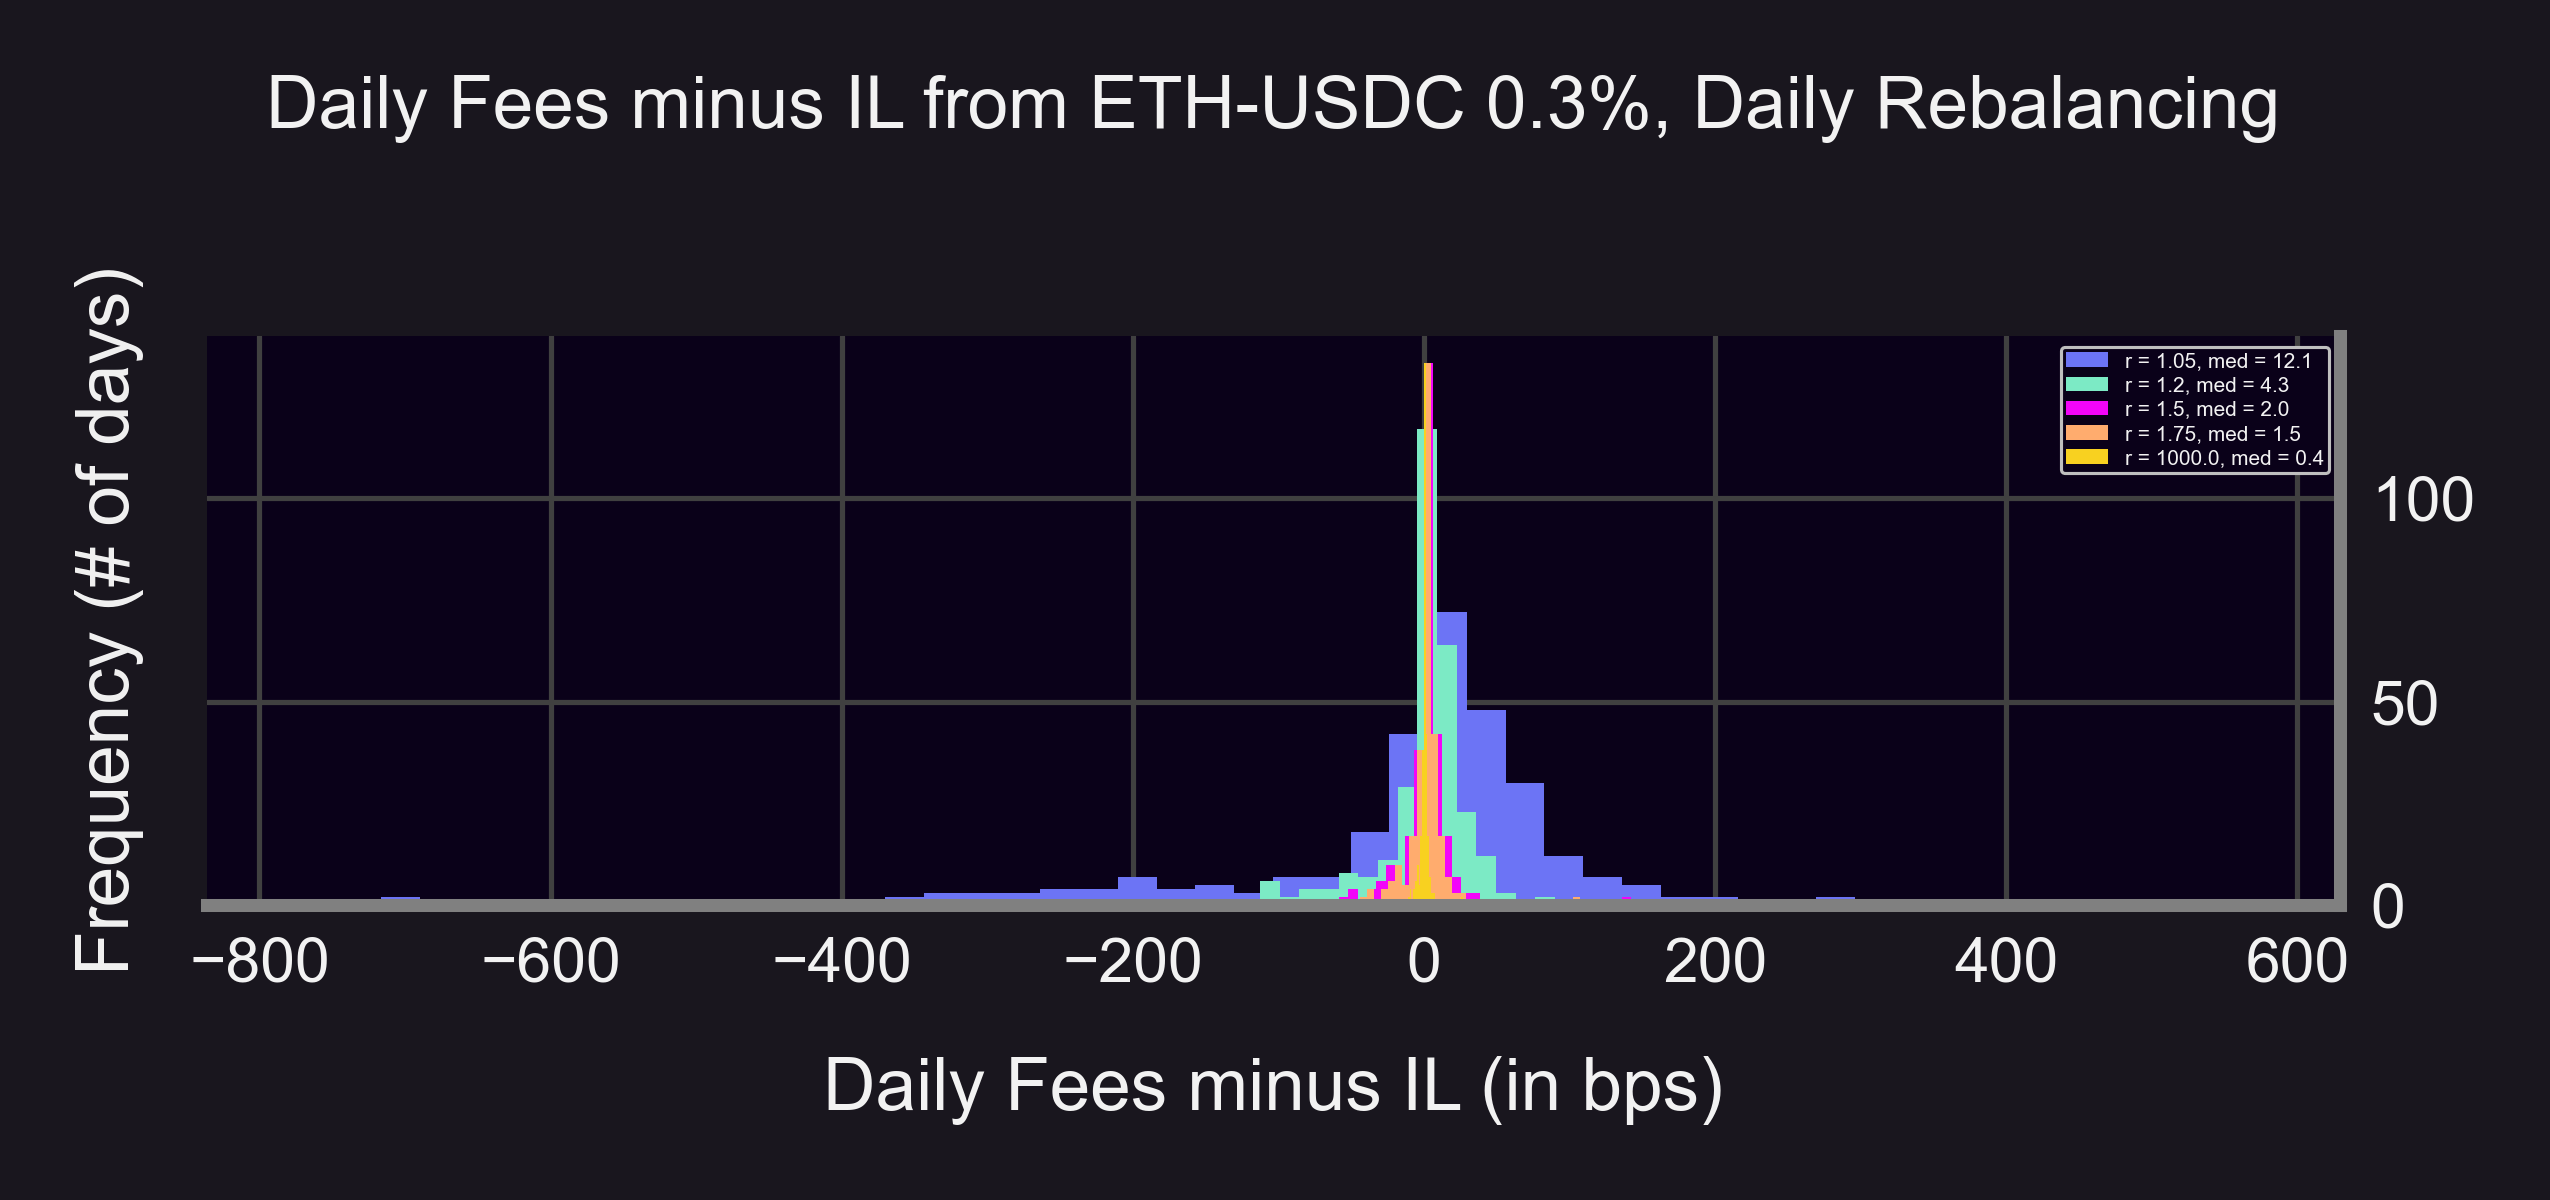

In [33]:
'''Plot all histograms at once'''
rets = {}
BPS = 10_000

for strat, period in strategies.items():
     if 'a' in period or 'd' in period:
          rets[strat_label_2(strat)] = (strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['IL_perc'][mid_idx:]) * BPS
     if 'a' in period or 'w' in period:
          rets[strat_label_2(strat)] = (strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['IL_perc'][mid_idx:]) * BPS
     if 'a' in period or 'm' in period:
          rets[strat_label_2(strat)] = (strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['IL_perc'][mid_idx:]) * BPS

# Plot rebalancing strategies
plot_hist_all(rets = rets,
          xlabel = 'Daily Fees minus IL (in bps)',
          ylabel = 'Frequency (# of days)',
          title = f'Daily Fees minus IL from {pool_name}, {reb_period} Rebalancing',
          dir = f"{strat.raw_dir}/hist_IL_P2",
          bins = 50,
)

### Summary Stats - Fees

Period 1

In [34]:
# Daily Fees summary stats
print("FEES (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][:mid_idx]), columns=['Daily'])
    fees_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][:mid_idx])
    fees_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][:mid_idx])
    print(fees_stats, '\n')
    fees_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_fees_P1.csv")

FEES (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                   Daily      Weekly     Monthly
Sharpe Ratio   32.088775   18.684775   10.146662
Cum Ret       721.834407  200.323246  104.628111
Max Cum Ret   721.834407  200.323246  104.628111
Min Cum Ret     1.084728    1.084728    1.084728
Avg Ret        69.613448   36.307739   23.679137
Med Ret        60.756975   29.675769    0.000000
Max Loss       11.437813    0.000000    0.000000
Avg Loss             NaN         NaN         NaN
Med Loss             NaN         NaN         NaN
Win Rate        1.000000    0.700658    0.355263
Avg Gain       69.613448   51.819497   66.652386
Med Gain       60.756975   46.840161   53.210179
Max Gain      389.525703  207.778161  379.420273 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly     Monthly
Sharpe Ratio   19.996416   25.013929   20.237951
Cum Ret       122.369752  104.059401   67.247942
Max Cum Ret   122.369752  104.059401   67.2479

Period 2

In [35]:
# Daily Fees summary stats
print("FEES (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][mid_idx:]), columns=['Daily'])
    fees_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][mid_idx:])
    fees_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][mid_idx:])
    print(fees_stats, '\n')
    fees_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_fees_P2.csv")

FEES (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                   Daily      Weekly     Monthly
Sharpe Ratio   20.785033   16.003771   10.686254
Cum Ret       636.741881  170.521109   63.745565
Max Cum Ret   636.741881  170.521109   63.745565
Min Cum Ret     0.434634    0.469524    0.434634
Avg Ret        66.089634   32.865938   16.276942
Med Ret        48.515037   20.939933    0.000000
Max Loss        2.125105    0.000000    0.000000
Avg Loss             NaN         NaN         NaN
Med Loss             NaN         NaN         NaN
Win Rate        1.000000    0.720395    0.398026
Avg Gain       66.089634   45.622124   40.894135
Med Gain       48.515037   34.978247   29.806369
Max Gain      563.471208  259.655539  170.549064 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly    Monthly
Sharpe Ratio   13.165462   16.662114  16.483307
Cum Ret       126.204835   86.743410  42.183935
Max Cum Ret   126.204835   86.743410  42.183935
M

### Summary Stats - Returns

Period 1

In [36]:
# Daily Returns summary stats
print("DAILY RETURNS (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    ret_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['pnl_perc'][:mid_idx]), columns=['Daily'])
    ret_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['pnl_perc'][:mid_idx])
    ret_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['pnl_perc'][:mid_idx])
    print(ret_stats, '\n')
    ret_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_rets_P1.csv")

DAILY RETURNS (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                    Daily       Weekly      Monthly
Sharpe Ratio    -0.343991    -0.051644     0.303294
Cum Ret        -21.225932   -14.465108    -0.056967
Max Cum Ret      6.364089     6.426038    27.716248
Min Cum Ret    -34.205455   -35.409651   -28.653649
Avg Ret         -4.544577    -0.788427     4.971548
Med Ret         86.437760    10.122472     0.000000
Max Loss     -1463.074585 -1463.074585 -1585.186013
Avg Loss      -248.222566  -283.980962  -341.809274
Med Loss      -185.815369  -185.185134  -244.447361
Win Rate         0.628289     0.542763     0.424342
Avg Gain       139.620935   163.772670   234.289377
Med Gain       150.717780   107.025587   175.993781
Max Gain       350.406745  1141.531341  1153.793155 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                    Daily       Weekly      Monthly
Sharpe Ratio     0.670867     0.713472     0.481595
Cum Ret         17.256079    20.635917

Period 2

In [37]:
# Daily Returns summary stats
print("DAILY RETURNS (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    ret_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['pnl_perc'][mid_idx:]), columns=['Daily'])
    ret_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['pnl_perc'][mid_idx:])
    ret_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['pnl_perc'][mid_idx:])
    print(ret_stats, '\n')
    ret_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_rets_P2.csv")

DAILY RETURNS (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                    Daily       Weekly      Monthly
Sharpe Ratio    -1.554909    -1.165165    -1.453794
Cum Ret        -56.024160   -56.726564   -63.754090
Max Cum Ret      3.839081     2.490069     2.545420
Min Cum Ret    -62.436233   -66.537634   -68.605700
Avg Ret        -22.854372   -21.283074   -26.931348
Med Ret         43.311116     4.689030     0.000000
Max Loss     -1591.202430 -1761.693653 -1761.693653
Avg Loss      -254.506936  -305.895353  -300.882821
Med Loss      -117.855804  -150.843146  -178.380396
Win Rate         0.608553     0.516447     0.421053
Avg Gain       126.154574   167.265913   204.011810
Med Gain       127.798384   108.121393   126.695752
Max Gain       585.423103  1803.272264  1803.272264 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                    Daily       Weekly      Monthly
Sharpe Ratio    -0.747634    -0.638757    -1.250550
Cum Ret        -30.851366   -36.693654

### Summary Stats - Fees minus IL

Period 1

In [38]:
# Daily Fees minus IL summary stats
print("DAILY FEES - IL (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_IL_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][:mid_idx] + strat.daily_pos['IL_perc'][:mid_idx]), columns=['Daily'])
    fees_IL_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][:mid_idx] + strat.weekly_pos['IL_perc'][:mid_idx])
    fees_IL_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][:mid_idx] + strat.monthly_pos['IL_perc'][:mid_idx])
    print(fees_IL_stats, '\n')
    fees_IL_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_IL_P1.csv")

DAILY FEES - IL (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                   Daily      Weekly     Monthly
Sharpe Ratio   -1.981820   -2.619918   -1.604693
Cum Ret       -32.993881  -33.098935  -17.820571
Max Cum Ret     1.879282    2.415711    1.973169
Min Cum Ret   -34.345046  -35.634681  -18.933238
Avg Ret       -12.433878  -12.771197   -6.179355
Med Ret        19.909470    0.000000    0.000000
Max Loss     -670.481579 -670.481579 -519.603914
Avg Loss     -116.514315 -107.460648 -108.811795
Med Loss      -62.204310  -46.409485  -44.094875
Win Rate        0.615132    0.437500    0.203947
Avg Gain       52.685968   35.446676   50.432561
Med Gain       44.898745   29.169509   37.733136
Max Gain      386.772032  206.672281  257.944301 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly     Monthly
Sharpe Ratio   -0.129266   -1.055196   -1.164154
Cum Ret        -1.047784   -6.476716   -5.292239
Max Cum Ret     1.374540    1.28813

Period 2

In [39]:
# Daily Fees minus IL summary stats
print("DAILY FEES - IL (bps): \n")
for strat in strategies:
    print(strat_name(strat))
    fees_IL_stats = pd.DataFrame(strat_summary(strat.daily_fees['our_fees'][mid_idx:] + strat.daily_pos['IL_perc'][mid_idx:]), columns=['Daily'])
    fees_IL_stats['Weekly'] = strat_summary(strat.weekly_fees['our_fees'][mid_idx:] + strat.weekly_pos['IL_perc'][mid_idx:])
    fees_IL_stats['Monthly'] = strat_summary(strat.monthly_fees['our_fees'][mid_idx:] + strat.monthly_pos['IL_perc'][mid_idx:])
    print(fees_IL_stats, '\n')
    fees_IL_stats.to_csv(f"{strat.raw_dir}{strat_file(strat)}_IL_P2.csv")

DAILY FEES - IL (bps): 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.05)
                   Daily      Weekly     Monthly
Sharpe Ratio   -2.187067   -2.695812   -2.208532
Cum Ret       -41.957228  -35.809760  -20.123291
Max Cum Ret     0.017281   -0.461636   -0.788775
Min Cum Ret   -42.019313  -35.809760  -20.191758
Avg Ret       -16.784783  -14.064322   -7.191605
Med Ret        12.122029    0.000000    0.000000
Max Loss     -769.759208 -769.759208 -512.223300
Avg Loss     -147.002529 -117.771357 -102.014137
Med Loss      -84.420232  -58.134597  -51.514624
Win Rate        0.654605    0.470395    0.256579
Avg Gain       51.923074   32.692792   28.209743
Med Gain       33.524087   21.311301   19.411400
Max Gain      562.371277  259.156370  165.180757 

(USDC-ETH 30 bps, 2021-06-01 - 2023-01-30, r = 1.2)
                   Daily      Weekly     Monthly
Sharpe Ratio   -1.058928   -1.882206   -2.072047
Cum Ret        -9.724347  -12.244412   -9.462693
Max Cum Ret     4.644745    0.03251